In [1]:
from underlying import Underlying, NonTradedUnderlying
from option import Option, Vanilla, Vanilla_on_NonTraded
from trader import Trader, trader_loop

import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

from IPython import display
from time import sleep
from multiprocess import Pool

In [95]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
processors = 8

# Opcja na aktywo niehandlowalne

## I.Wprowadzenie teoretyczne do problemu

## II. Optymalizacja pierwszej funkcji celu

### Parametry wyjściowe

In [3]:
mu_nt = 0.06
mu_t = 0.06
sigma_nt =  0.3
sigma_t =  0.3
r = 0.05
X0_nt = 100
X0_t = 100
T = 1
K = 100
repeat = 10000
values_per_year = 250

In [4]:
underlying_t = Underlying(mu_t, sigma_t, r, values_per_year)

### Proste *sanity checki* wyznaczanego przez przypadek skrajny payoffu

In [5]:
rho = 0.999999
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)

In [6]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [7]:
call_vanilla = Vanilla(underlying_t, K, T, True)
put_vanilla = Vanilla(underlying_t, K, T, False)

#### Cena opcji w świecie Blacka Scholesa- porównanie

In [8]:
price_MC_nontradable = call_nt.get_MC_price(X0_t, X0_nt)
BS_call = call_vanilla.get_price(X0_t)
print(f'Analitycna cena opcji call:{BS_call:.3f}')
print(f'MC cena opcji na niehandlowalne imitującej zwykłego calla:{price_MC_nontradable:.3f}')
assert abs(price_MC_nontradable - BS_call)/BS_call < 0.05

Analitycna cena opcji call:14.231
MC cena opcji na niehandlowalne imitującej zwykłego calla:14.417


In [9]:
price_MC_nontradable = put_nt.get_MC_price(X0_t, X0_nt)
BS_put = put_vanilla.get_price(X0_t)
print(f'Analitycna cena opcji put:{BS_put:.3f}')
print(f'MC cena opcji na niehandlowalne imitującej zwykłego puta:{price_MC_nontradable:.3f}')
assert abs(price_MC_nontradable - BS_put)/BS_put < 0.05

Analitycna cena opcji put:9.354
MC cena opcji na niehandlowalne imitującej zwykłego puta:9.405


Widzimy, że estymacje ceny opcji na aktywo niehandlowalne w przypadku imitującym opcję waniliową są stosunkowo zbliżone. Potencjalny, mniejszy niż 5% ceny właściwej błąd wynikać może z metody symulacji Monte Carlo.

#### Zmodyfikowany payoff do hedgowania połową uzyskanych pieniędzy- porównanie

In [10]:
call_nt.set_m(BS_call / 2, X0_t, X0_nt)
call_nt_quantile_payoff = call_nt.payoff_special(X0_t * reality_t, X0_nt)
put_nt.set_m(BS_put / 2, X0_t, X0_nt)
put_nt_quantile_payoff = put_nt.payoff_special(X0_t * reality_t, X0_nt)

In [11]:
f_call = payoff_from_v0(call_vanilla, BS_call / 2, X0_nt)[0]
call_quantile_payoff = f_call(X0_nt * reality_nt)
f_put = payoff_from_v0(put_vanilla, BS_put / 2, X0_nt)[0]
put_quantile_payoff = f_put(X0_nt * reality_nt)

Text(0.5, 0.98, 'Payoff zmodyfikowany do hedgingu z użyciem połowy ceny calla')

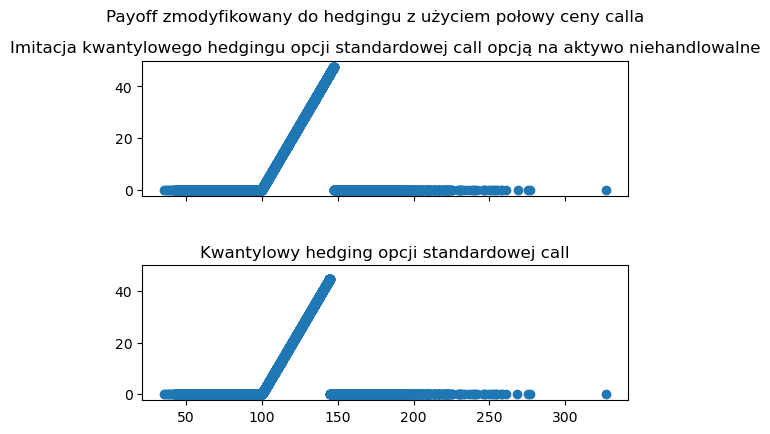

In [12]:
fig, axs = plt.subplots(2,1, sharex = True, sharey = True)
fig.tight_layout(pad=4.0)
axs[0].scatter((X0_t * reality_t).iloc[:,-1], call_nt_quantile_payoff)
axs[0].set_title('Imitacja kwantylowego hedgingu opcji standardowej call opcją na aktywo niehandlowalne')
axs[1].scatter((X0_nt * reality_nt).iloc[:,-1], call_quantile_payoff)
axs[1].set_title('Kwantylowy hedging opcji standardowej call')
plt.suptitle('Payoff zmodyfikowany do hedgingu z użyciem połowy ceny calla')

Widzimy, że dla opcji call zmodyfikowane ze względu na hedging kwantylowy payoffy są bardzo zbliżone.

Text(0.5, 0.98, 'Payoff zmodyfikowany do hedgingu z użyciem połowy ceny puta')

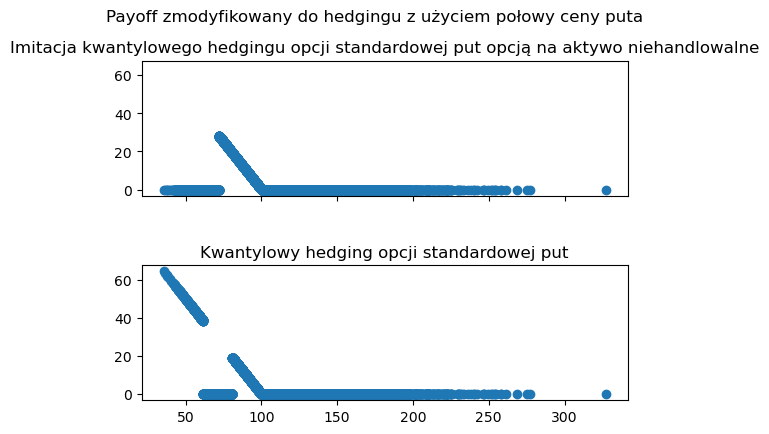

In [13]:
fig, axs = plt.subplots(2,1, sharex = True, sharey = True)
fig.tight_layout(pad=4.0)
axs[0].scatter((X0_t * reality_t).iloc[:,-1], put_nt_quantile_payoff)
axs[0].set_title('Imitacja kwantylowego hedgingu opcji standardowej put opcją na aktywo niehandlowalne')
axs[1].scatter((X0_nt * reality_nt).iloc[:,-1], put_quantile_payoff)
axs[1].set_title('Kwantylowy hedging opcji standardowej put')
plt.suptitle('Payoff zmodyfikowany do hedgingu z użyciem połowy ceny puta')

In [14]:
put_nt.get_MC_price(X0_t, X0_nt)
put_vanilla.payoff_func = f_put
print(f'Imitacja standardowego kwantylowego hedgingu: cena = {put_nt.get_MC_price(X0_t, X0_nt):.3f}, p-stwo sukcesu = {(1 - (put_nt_quantile_payoff == 0) * ((X0_t * reality_t).iloc[:,-1] >= K)).mean():.3f}')
print(f'Standardowy hedging kwantylowy: cena = {put_vanilla.get_MC_price(X0_t):.3f}, p-stwo sukcesu = {(1 - (put_quantile_payoff == 0) * ((X0_nt * reality_nt).iloc[:,-1] >= K)).mean():.3f}')

Imitacja standardowego kwantylowego hedgingu: cena = 4.651, p-stwo sukcesu = 0.485
Standardowy hedging kwantylowy: cena = 4.372, p-stwo sukcesu = 0.484


Widzimy, że w przypadku opcji put zmodyfikowany payoff dla podejścia z aktywem niehandlowalnym ma inną formę niż w przypadku podejścia standardowego (mimo identycznie dobranych parametrów). Jednocześnie ceny tak skonstruowanych zabezpieczń są bardzo zbliżone- podobne są także empiryczne prawdopodobieństwa sukcesu. Kwestia ta nie została przez nas wyjaśniona- nasuwa się, że konstrukcja zmodyfikowanego payoffu nie musi być jednoznaczna. Alternatywnie podejście z dwoma odcięciami payoffu wyprowadzone dla opcji call w artykule źródłowym nie ma bezpośredniego przełożenia na opcję put.

### Wrażliwość nachylenia stycznej do funkcji $G$, a cena zabezpieczenia skonstruowanego w ten sposób payoffu

Poniższe wykresy przedstawiać będą zależność pomiędzy parametrem **m** użytym do konstrukcji zmodyfikowanego payoffu, a kosztem zabezpieczenia takiego payoffu. Dodatkowym czynnikiem wyróżniajacym będzie współczynnik korelacji aktywa głównego (niehandlowalnego) z pomocniczym aktywem handlowalnym, którego używać mielibyśmy do hedgowania.

In [15]:
rho_call = dict()
for rho in [-0.999, -0.75, -0.25, 0, 0.25, 0.75, 0.999]:
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    rho_call[rho] = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
m_s = np.arange(0.00001, 0.02, 0.00001)
plt.figure(figsize=(10,10))
plt.xlabel('m', size = 15)
plt.xlim([np.min(m_s), np.max(m_s)])    
plt.xticks(size = 15)
plt.ylabel('V0', size = 15)
plt.ylim([0, 200])
plt.yticks(size = 15)
for num, rho in enumerate(rho_call):
    prices = []
    for m in tqdm(m_s):
        rho_call[rho].m = m
        V0 = rho_call[rho].get_MC_price(X0_t, X0_nt)
        prices.append(V0)
    plt.plot(m_s, prices, lw = 2, label = f'rho = {rho}')
plt.legend(fontsize = 15)
plt.title(f'Wymagany kapitał początkowy zabezpieczenia opcji call(K = {K}) na aktywo niehandlowalne\nw zależności od przyjętego współczynnika m w podziale\nze wzglęgu na korelację z pomocniczym aktywem handlowalnym',size = 15)


In [ ]:
rho_put = dict()
for rho in [-0.999, -0.75, -0.25, 0, 0.25, 0.75, 0.999]:
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    rho_put[rho] = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
m_s = np.arange(0.00001, 0.02, 0.00001)
plt.figure(figsize=(10,10))
plt.xlabel('m', size = 15)
plt.xlim([np.min(m_s), np.max(m_s)])    
plt.xticks(size = 15)
plt.ylabel('V0', size = 15)
plt.ylim([0, 100])
plt.yticks(size = 15)
for num, rho in enumerate(rho_put):
    prices = []
    for m in tqdm(m_s):
        rho_put[rho].m = m
        V0 = rho_put[rho].get_MC_price(X0_t, X0_nt)
        prices.append(V0)
    plt.plot(m_s, prices, lw = 2, label = f'rho = {rho}')
plt.legend(fontsize = 15)
plt.title(f'Wymagany kapitał początkowy zabezpieczenia opcji put(K = {K}) na aktywo niehandlowalne\nw zależności od przyjętego współczynnika m w podziale\nze wzglęgu na korelację z pomocniczym aktywem handlowalnym',size = 15)


Intuicyjnie **m** określa w pewnym stopniu porządane prawdopodobieństwo zabezpieczenia- im wyższe nachylenie stycznej tym mniejszy jest payoff opcji, na którą mamy zamiar się zabezpieczyć. Pierwszą narzucającą się obserwacją jest fakt, że im bardziej skrajny jest parametr $\rho$ tym większą stabilnością cechują się ceny opcji- od strony implementacyjnej utrudnia to zatem dokładne przełożenie zadanego kapitału początkowego na wymagany do zabezpieczania zmodyfikowany payoff. Ceny opcji są najwyższe dla $\rho$ zbliżonych do $0$- możemy to tłumaczyć faktem, że zabezpieczając się aktywem handlowalnym mamy coraz mniejszą kontrolę nad aktywem, którego dotyczyć będzie ten faktyczny payoff. Widzimy, że ceny opcji są zbliżone dla przeciwnych sobie korelacji- pewnego rodzaju symetryczność ich payoffów zobaczymy w sekcji poniższej.

### Zmodyfikowane payoffy w zależności od parametru **m**

Ostateczna relacja, na której nam zależy to:
$$V_0 \longrightarrow m \longrightarrow \text{zmodyfikowany payoff} \longrightarrow \text{hedging zmodyfikowanego payoffu}$$
Znamy już zależność z poziomu pierwszej strzałki od lewej. Zobaczmy teraz jak parametr **m** wpływa na zmodyfikowany payoff, który ma zostać zabezpieczony. W związku z tym, że nachylenie stycznej do $G$ jest konceptem dość abstrakcyjnym utożsamiajmy je na bazie wykresów poprzednich z odwrotnością posiadanego kapitału- im większe **m** tym mniejszy kapitał, którym dysponuję.

<font color='red'>** UWAGA: Poniższe wykresy będą miały postać animacji- przed jej puszczeniem należy rozwinąć output komórki, a po zakończeniu animacji go zwinąć. **</font>

In [237]:
rho_call = dict()
for rho in [-0.999, -0.5, 0, 0.5, 0.999]: #można sobie wybrać inne korelacje lub mniej
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    rho_call[rho] = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
m = 0.0001
diff = 0.00001
rate = 1.9
booster = 3
V0_prev = len(rho_call) * [np.infty]
i = 0
j = 0
while True:
    j += 1
    plt.figure(figsize=(12,8))
    if j == 50:
        diff *= booster
    else:
        for num, rho in enumerate(rho_call):
            option = rho_call[rho]
            final_index = round(option.underlying.values_per_year * option.T + 1)
            sims_t = pd.DataFrame(np.ones(500), columns = [0])
            sims_t[1] = np.arange(10, 510) / X0_t
            option.m = m
            payoff = option.payoff_special(X0_t * sims_t, X0_nt)
            V0 = np.exp(-option.underlying.r * option.T) * payoff.mean()
            if abs(V0 - V0_prev[num]) < 0.1:
                i += 1
            V0_prev[num] = V0
            plt.plot((X0_t * sims_t).iloc[:,-1], payoff, label = f'rho = {rho}, V0 = {V0:.2f}', lw = 2)
        plt.title(f'Zabezpieczenie call(K = {K}) na aktywo niehandlowalne w zależności od parametru m\nzmodyfikowany payoff i wymagany kapitał początkowy\nm = {m:.5f}', size = 20)
        plt.xlim([20,500])
        plt.xlabel('Cena końcowa aktywa handlowalnego', size = 12)
        plt.ylim([-5,500])
        plt.ylabel('payoff', size= 12)
        plt.legend(loc = 'upper right', prop={'size': 12})
    m += diff
    if i == len(rho_call):
        i = 0
        diff *= rate
    display.clear_output(wait = True)
    display.display(plt.gcf())
    sleep(0.05)
    if np.max(np.array(V0_prev)) < 1:
        break

Widzimy, że dla $\rho$ zbliżonego do $1$ payoff zmodyfikowany przypomina ten standardowy dla kwantylowo hedgowanej opcji call. W przypadku przeciwnym ma on postać jak dla opcji put- jeśli aktywa zachowują się skrajnie przeciwnie musimy zabezpieczać się na spadki aktywa handlowalnego oczekując tym samym wzrostów aktywa głównego. Kolejną obserwacją jest to, że dla mniejszej, dodatniej korelacji payoff staje się wklęsły oraz niezerowy także dla cen poniżej $K$. Intuicyjnie mamy tu do czynienia z pewnego rodzaju niepewnością faktycznego ruchu aktywa głównego, co skutkuje w większej "konserwatywności" wymaganych końcowych stanów portfela. Podobny trend obserwujemy także dla korelacji ujemnej- tym razem wykres jest jednak wypukły. Wklęsłość tą można tłumaczyć faktem, że o ile spadek aktywa handlowalnego jest ograniczony z dołu tak w tym wypadku potencjalny wzrost aktywa głównego nie ma żadnego ograniczenia. Przypadek, gdzie aktywa są nieskorelowane jest właściwie zabezpieczaniem się na szum. Odpowiada wtedy właściwie dosłownie zakumulowanemu kapitałowi początkowemu- im więcej go mamy tym na wyższy kwantyl losowości jesteśmy zabezpieczeni. W tym wypadku hedging polegałby raczej na trzymaniu odpowiedniej kwoty bez konieczności handlowania aktywem pomocniczym.

In [34]:
rho_put = dict()
for rho in [-0.999, -0.5, 0, 0.5, 0.999]: #można sobie wybrać inne korelacje lub mniej
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    rho_put[rho] = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
m = 0.0001
diff = 0.00002
rate = 1.9
V0_prev = len(rho_put) * [np.infty]
i = 0
j = 0
while True:
    j += 1
    plt.figure(figsize=(12,8))
    if j == 50:
        #img = mpimg.imread('xd.jpeg')
        #plt.imshow(img)
        diff *= 2
    for num, rho in enumerate(rho_put):
        option = rho_put[rho]
        final_index = round(option.underlying.values_per_year * option.T + 1)
        _, sims_full_t = option.MC_setup[0]
        sims_t = pd.DataFrame(np.ones(500), columns = [0])
        sims_t[1] = np.arange(10, 510) / X0_t
        option.m = m
        payoff = option.payoff_special(X0_t * sims_t, X0_nt)
        V0 = np.exp(-option.underlying.r * option.T) * payoff.mean()
        if abs(V0 - V0_prev[num]) < 0.1:
            i += 1
        V0_prev[num] = V0
        plt.plot((X0_t * sims_t).iloc[:,-1], payoff, label = f'rho = {rho}, V0 = {V0:.2f}', lw = 2)
    plt.title(f'Zabezpieczenie put(K = {K}) na aktywo niehandlowalne w zależności od parametru m\nzmodyfikowany payoff i wymagany kapitał początkowy\nm = {m:.5f}', size = 20)
    plt.xlim([20,500])
    plt.xlabel('Cena końcowa aktywa handlowalnego', size = 12)
    plt.ylim([-5,100])
    plt.ylabel('payoff', size= 12)
    plt.legend(loc = 'upper right', prop={'size': 12})
    m += diff
    if i == 5:
        i = 0
        diff *= rate
    display.clear_output(wait = True)
    display.display(plt.gcf())
    sleep(0.15)
    if np.max(np.array(V0_prev)) < 1:
        break

Podobne zachowanie możemy zaobserwować dla opcji put. Warto odnotować, że w tym wypadku payoff zmodyfikowany nie może przekroczyć ceny wykonania $K$- jest to maksymalna wypłata payoffu faktycznego. Warto zauważyć, że dla dużych **m** payoffy (poza przypadkiem bez korelacji) zaczynają zbiegać do punktów skupienia z największą masą aktywa niehandlowalnego- przykładowo dla korelacji zbliżonej do $1$ są to okolice ceny początkowej tego aktywa. Trend ten widoczny był także dla opcji kupna.

#### Rezultaty $\Delta$-hedgingu opcji na aktywo niehandlowalne

Ostatnim elementem zaprezentowanego wcześniej ciągu zależności było skonstruowanie strategii zabezpieczającej opcję przy zadanym kapitale początkowym. Teraz przyjrzyjmy się zatem jakie wyniki osiągają tak skonstruowane strategie.

Rozpocznijmy od opcji call i kapitału początkowego w kwocie połowy ceny opcji standardowej (o handlowalnym aktywie bazowym). Oczekujemy zatem, że dla $\rho$ zbliżonego do $1$ zabezpieczenie będzie najbliższe pełnemu, a zmodyfikowany payoff dla aktywa handlowalnego odpowiadać będzie zabezpieczonym przypadkom aktywa głównego. Dla wszystkich pozostałych ze względu na dodatkową niepewność (oraz w oparciu o wcześniej widziane wykresy) odpowiednio zahedgowaych przypadków powinno być mniej.

In [ ]:
repeat = 1000

5it [2:15:12, 1622.46s/it]


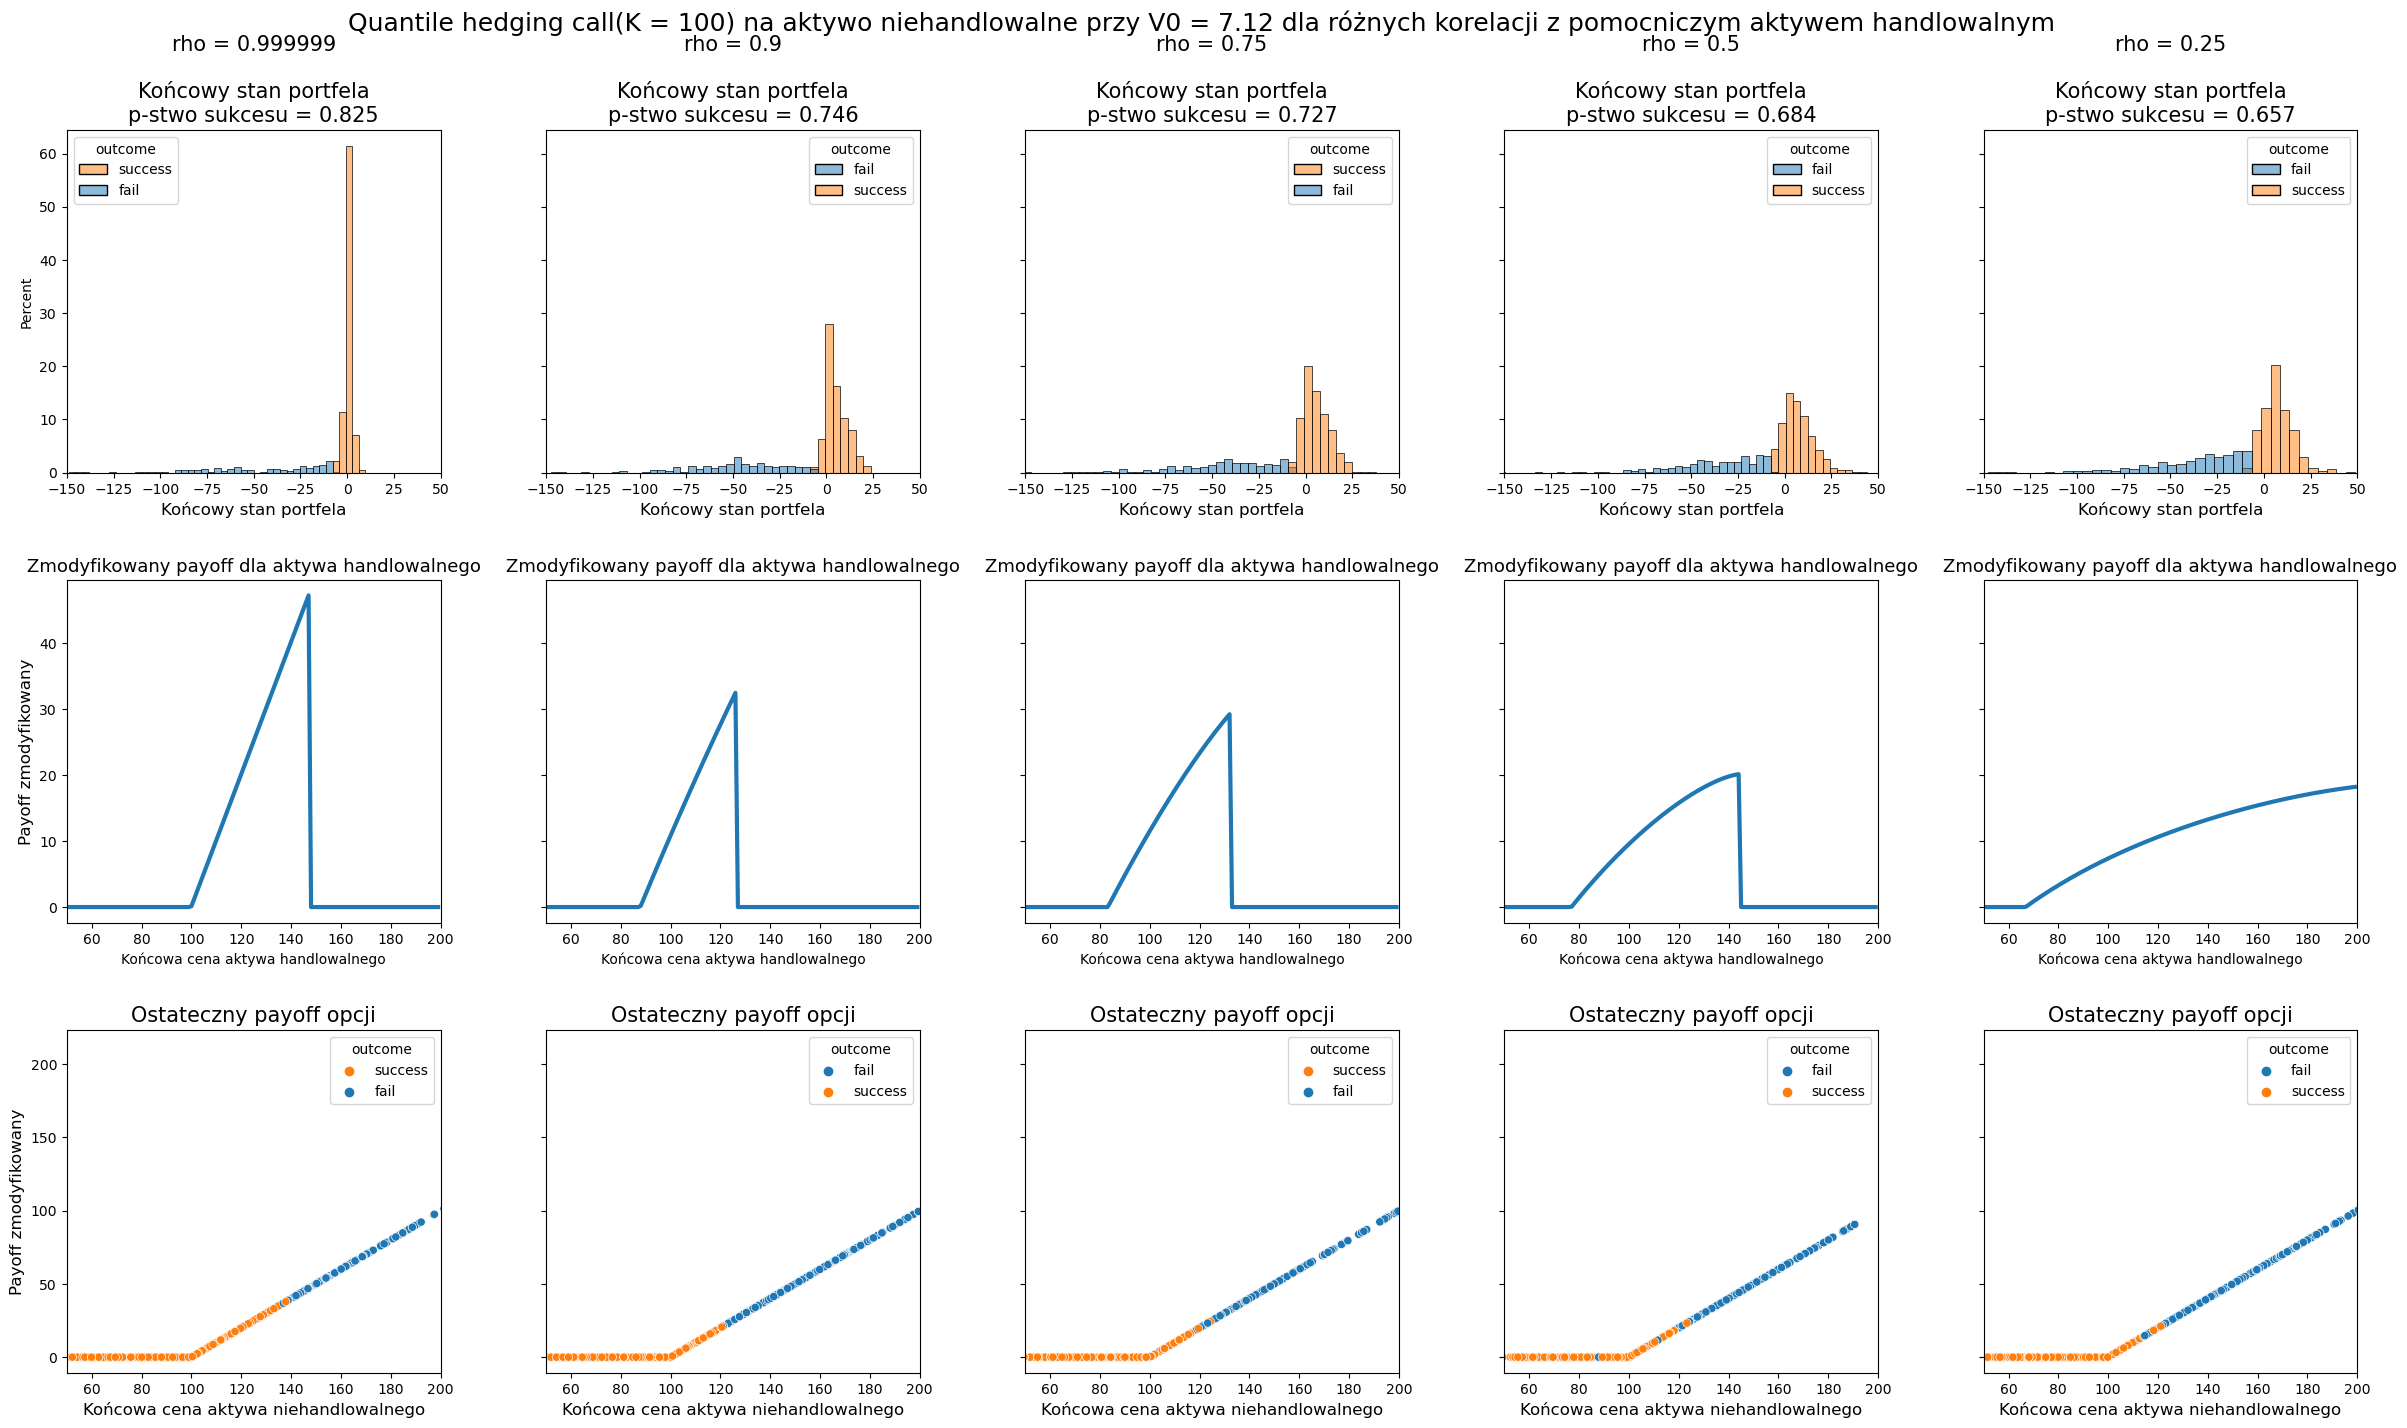

In [24]:
fig, axs = plt.subplots(3,5, figsize = (25, 15), sharey = 'row')
fig.tight_layout(pad=6.0)
V0 = BS_call / 2
for idx, rho in tqdm(enumerate([0.999999, 0.9, 0.75, 0.5, 0.25])):
    underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)
    [_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)
    
    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
    call_nt.set_m(V0, X0_t, X0_nt)
    sims_t = pd.DataFrame(np.ones(150), columns = [0])
    sims_t[1] = np.arange(50, 200) / X0_t
    payoff = call_nt.payoff_special((X0_t * sims_t), X0_nt)

    money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
    delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
    with Pool(processors) as p:
            results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
    for num, item in enumerate(results):
        money_time_call.loc[num] = item[0]
        delta_time_call.loc[num] = item[1]   
    money_time_call_outcome = money_time_call.copy()
    money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - V0 else 'fail', axis = 1)
    sb.histplot(ax = axs[0, idx], x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = repeat // 20, hue = money_time_call_outcome['outcome'], palette = {'fail':'tab:blue','success':'tab:orange'}, legend = True, stat = 'percent')
    axs[0, idx].set_xlim([-150, 50])        
    axs[0, idx].set_title(f'rho = {rho}\n\nKońcowy stan portfela\np-stwo sukcesu = {(money_time_call_outcome["outcome"] == "success").mean():.3f}', fontsize = 15)
    axs[0, idx].set_xlabel('Końcowy stan portfela', fontsize = 12)
    axs[1, idx].plot((X0_t * sims_t).iloc[:,-1], payoff, lw = 3)
    axs[1, idx].set_title('Zmodyfikowany payoff dla aktywa handlowalnego', fontsize = 13)
    axs[1, idx].set_xlim([50,200])    
    axs[1, idx].set_xlabel('Końcowa cena aktywa handlowalnego')
    sb.scatterplot(ax = axs[2, idx], x = (X0_nt*reality_nt).iloc[:,-1], y = np.maximum((X0_nt*reality_nt)[underlying_nt.values_per_year * T] - K,0), hue = money_time_call_outcome['outcome'], palette = {'fail':'tab:blue','success':'tab:orange'}).set_title('Ostateczny payoff opcji', fontsize = 15)
    axs[2, idx].set_xlim([50,200])    
    axs[2, idx].set_xlabel('Końcowa cena aktywa niehandlowalnego', fontsize = 12)
    if idx == 0:
        axs[1, idx].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[2, idx].set_ylabel('Payoff faktyczny', fontsize = 12)    
plt.suptitle(f'Quantile hedging call(K = {K}) na aktywo niehandlowalne przy V0 = {V0:.2f} dla różnych korelacji z pomocniczym aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.9)


W związku z tym, że jest to pierwsze ukazanie tej serii wykresów zacznijmy od słowa wstępu co one faktycznie przedstawiają. Każda kolumna odpowiada opcji call na aktywo niehandlowalne zabezpieczanej aktywem handlowalnym, które jest skorelowane z określonym $\rho$. Pierwszy wiersz wykresów skupia się na ostatecznym wyniku portfeli przeprowadzających proces hedgingu. Wyniki te zaprezentowane są w postaci histogramu. Rząd pierwszy oparty jest o symulacje rzeczywistości- w konsekwencji otrzymane wyniki dzielimy na sukcesy oraz porażki. Podział ten jest tutaj dość liberalny, za sukces uznajemy bowiem wynik portfela nieniższy niż $-10$ zł. Drugi rząd skupia się na ukazaniu payoffu zmodyfikowanego dla aktywa handlowalnego, którego zabezpieczanie ma niejako zastąpić bezpośrednie hedgowanie aktywa głównego. Wiersz ostatni ukazuje nam natomiast faktyczny payoff opcji call w zależności od ceny końcowej aktywa niehandlowalnego (głównego). Wykresy te stworzone są za pomocą faktycznych rezultatów symulacji- w konsekwencji kolorystycznie rozdzielamy je w zgodzie z metodyką z wiersza pierwszego. Frakcja sukcesów reprezentuje nam tutaj także empiryczne prawdopodobieństwo sukcesu umieszczone na górze każdej kolumny.

Przejdźmy teraz do opisu faktycznych otrzymanych wyników dla opcji call i korelacji dodatnich.

Zgodnie z wcześniejszą intuicją widzimy, że w przypadku korelacji bardzo zbliżonej do $1$ (kolumna pierwsza) frakcja sukcesów jest zdecydowanie największa (a w konsekwencji również empiryczne prawdopodobieństwo sukcesu). Niezerowa część payoffu zmodyfikowanego faktycznie odpowiada z pewną niedokładnością zabezpieczonej części payoffów faktycznych (nadal w pierwszej kolumnie- wiersz drugi oraz trzeci). W przypadku mniejszych korelacji prawdopodobieństwa sukcesu maleją- wykresy zaprezentowane wcześniej pokazały nam, że mniejsze korelacje cechują się większym wymaganym kapitałem do zabezpieczenia opcji na określonym poziomie. Same zmodyfikowane payoffy coraz bardziej wypłaszczają się niezerując się jednocześnie na coraz większym przedziale. Wypłaszczenie ma związek oczywiście z niezmieniającą się liczbą kapitału- większy przedział całkowity oznacza mniejsze zabezpieczenie na każdym z podprzedziałów. Wraz ze wzrostem losowości aktywa niehandlowalnego w stosunku do aktywa handlowalnego spada zakres zabezpieczonych ostatecznie payoffów- dla $\rho=0.25$ ogranicza się on właściwie tylko do payoffów zerowych.

4it [1:43:19, 1549.92s/it]


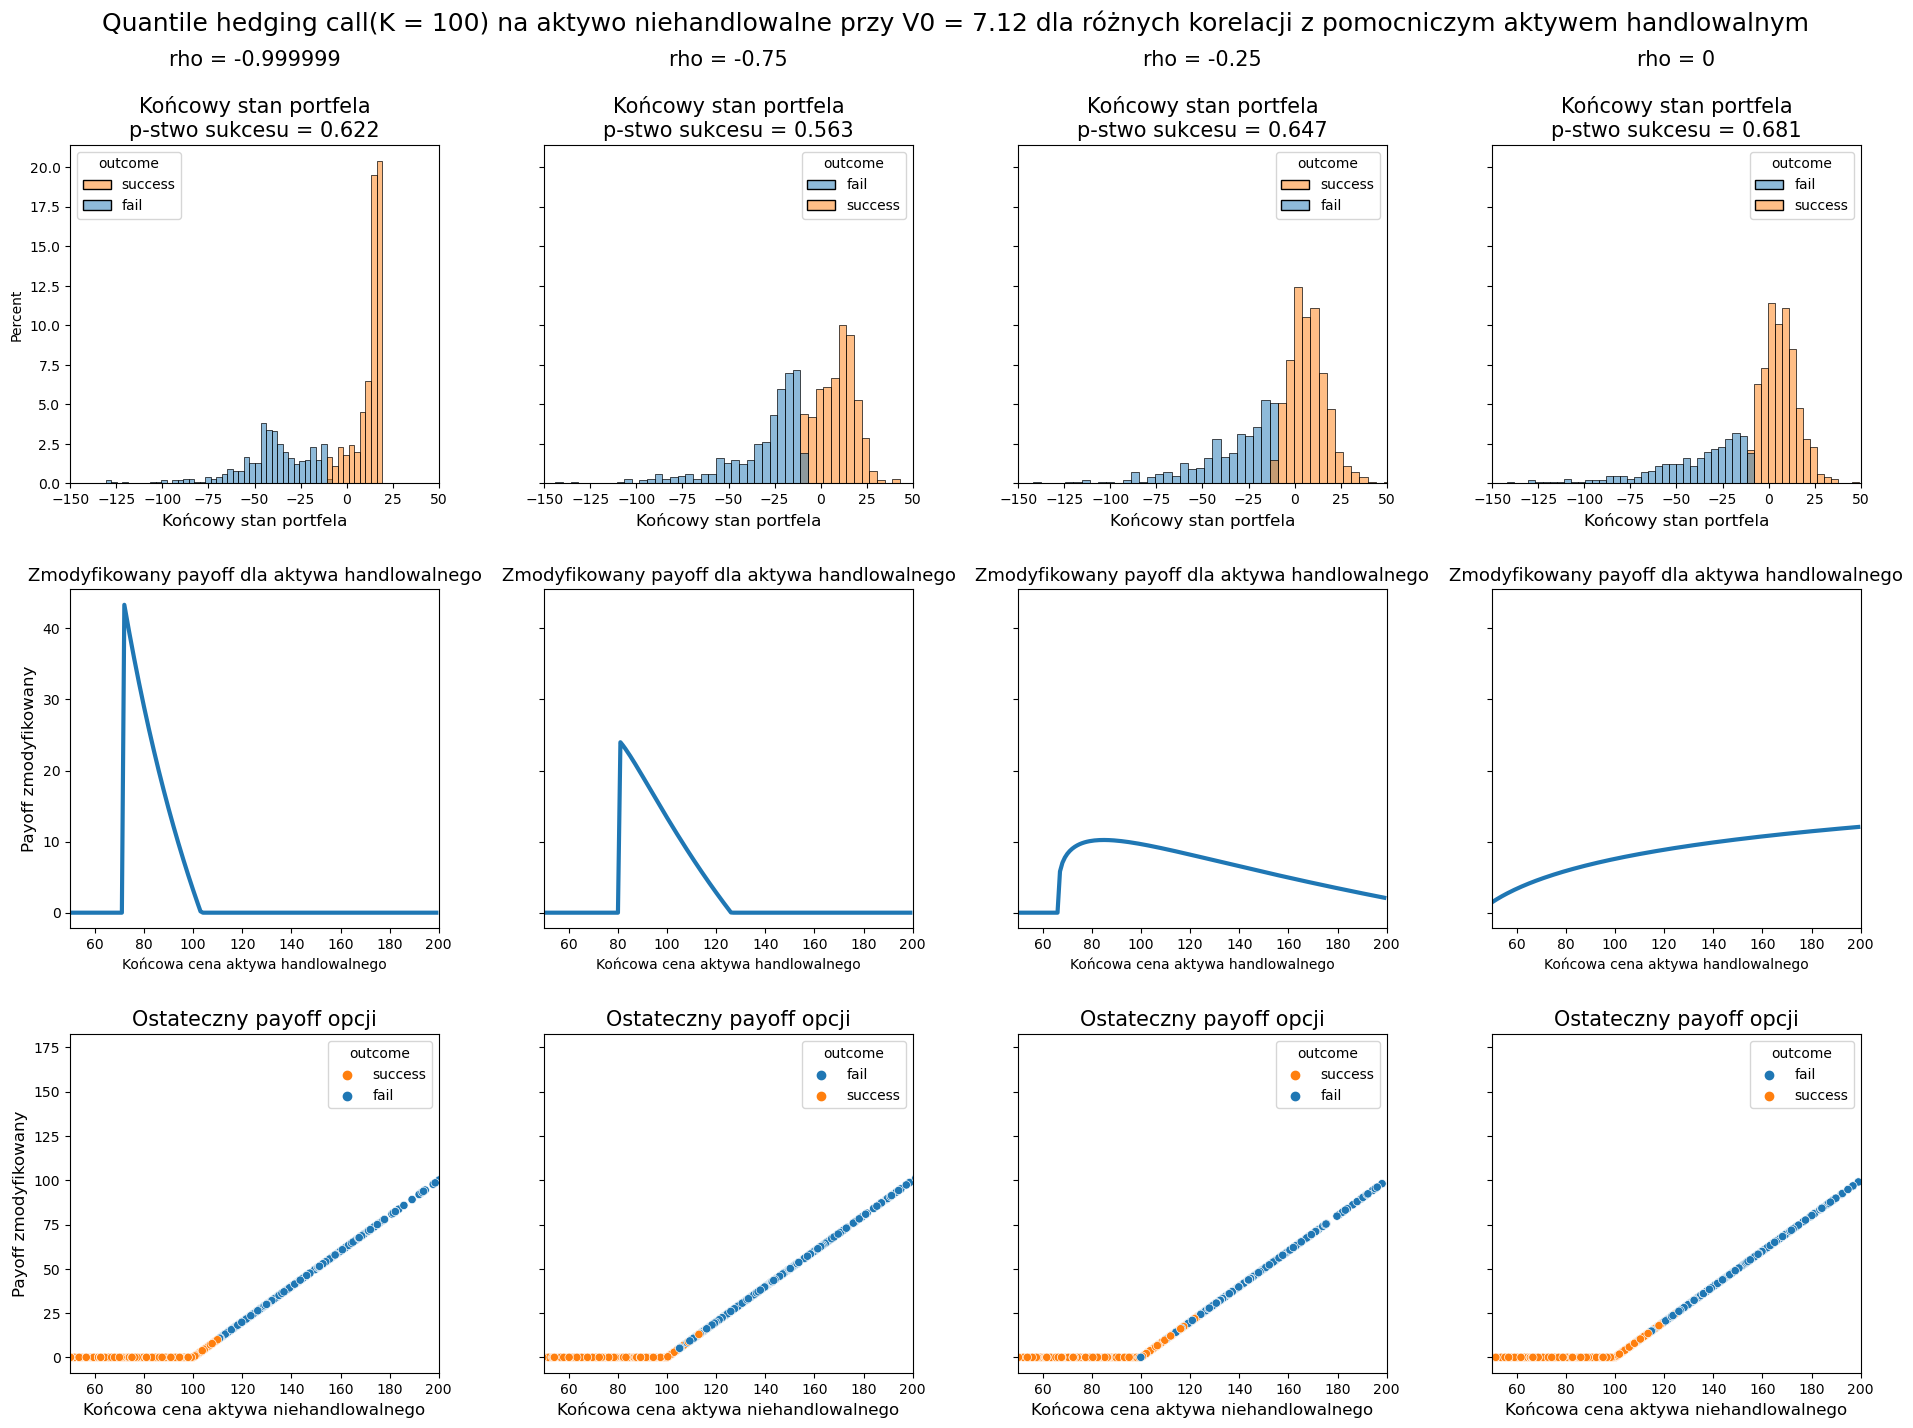

In [25]:
fig, axs = plt.subplots(3,4, figsize = (20, 15), sharey = 'row')
fig.tight_layout(pad=6.0)
V0 = BS_call / 2
for idx, rho in tqdm(enumerate([-0.999999, -0.75, -0.25, 0])):
    underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)
    [_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)
    
    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
    call_nt.set_m(V0, X0_t, X0_nt)
    sims_t = pd.DataFrame(np.ones(150), columns = [0])
    sims_t[1] = np.arange(50, 200) / X0_t
    payoff = call_nt.payoff_special((X0_t * sims_t), X0_nt)

    money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
    delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
    with Pool(processors) as p:
            results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
    for num, item in enumerate(results):
        money_time_call.loc[num] = item[0]
        delta_time_call.loc[num] = item[1]   
    money_time_call_outcome = money_time_call.copy()
    money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 10 else 'fail', axis = 1)
    sb.histplot(ax = axs[0, idx], x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = repeat // 20, hue = money_time_call_outcome['outcome'], palette = {'fail':'tab:blue','success':'tab:orange'}, legend = True, stat = 'percent')
    axs[0, idx].set_xlim([-150, 50])        
    axs[0, idx].set_title(f'rho = {rho}\n\nKońcowy stan portfela\np-stwo sukcesu = {(money_time_call_outcome["outcome"] == "success").mean():.3f}', fontsize = 15)
    axs[0, idx].set_xlabel('Końcowy stan portfela', fontsize = 12)
    axs[1, idx].plot((X0_t * sims_t).iloc[:,-1], payoff, lw = 3)
    axs[1, idx].set_title('Zmodyfikowany payoff dla aktywa handlowalnego', fontsize = 13)
    axs[1, idx].set_xlim([50,200])    
    axs[1, idx].set_xlabel('Końcowa cena aktywa handlowalnego')
    sb.scatterplot(ax = axs[2, idx], x = (X0_nt*reality_nt).iloc[:,-1], y = np.maximum((X0_nt*reality_nt)[underlying_nt.values_per_year * T] - K,0), hue = money_time_call_outcome['outcome'], palette = {'fail':'tab:blue','success':'tab:orange'}).set_title('Ostateczny payoff opcji', fontsize = 15)
    axs[2, idx].set_xlim([50,200])    
    axs[2, idx].set_xlabel('Końcowa cena aktywa niehandlowalnego', fontsize = 12)
    if idx == 0:
        axs[1, idx].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[2, idx].set_ylabel('Payoff faktyczny', fontsize = 12)    
plt.suptitle(f'Quantile hedging call(K = {K}) na aktywo niehandlowalne przy V0 = {V0:.2f} dla różnych korelacji z pomocniczym aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.89)


Na zamieszczonych wykresach niejednoznaczna okazuje się relacja pomiędzy frakcją sukcesów, a wielkością korelacji. Mimo, że dla $\rho=-0.75$ p-stwo zabezpieczenia było niższe niż w przypadku skrajnym to już w dla korelacji na poziomie $-0.25$ wynik okazał się lepszy. Dodatkowo uwzględniony tu przypadek nieskorelowania aktywów otrzymał co ciekawe najlepsze prawdopodobieńswo sukcesu. Może to wynikać z faktu, że portfel w czasie jest tutaj dużo bardziej stabilny- skoro nie mamy żadnej kontroli nad aktywem głównym nie mamy potrzeby wykonywać transakcji na tym handlowalnym. W kontekście zmodyfikowanych payoffów widzimy analogiczny trend jak dla korelacji dodatnich choć oczywiście wykresy są tutaj odwrócone. Zauważmy, że jeśli korelacja jest ujemna zabezpieczamy niejako nielimitowany wzrost aktywa niehandlowalnego tracącym jednocześnie na wartości aktywem handlowalnym- pierwsze z aktywów jest zatem dużo bardziej zmienne niż drugie, które od dołu ogranicza nieosiągalna wartość $0$. Ta dysproporcja może stanowić o stosunkowo słabych wynikach hedgingów, które zabezpieczają głównie przypadki, gdzie do payoffu nie doszło.

Rozważmy teraz opcję put na aktywo niehandlowalne o tych samych parametrach, co analizowany wyżej call oraz z kapitałem początkowym równym połowie ceny jaką zapłacilibyśmy za jej waniliowy odpowiednik.

5it [2:17:51, 1654.39s/it]


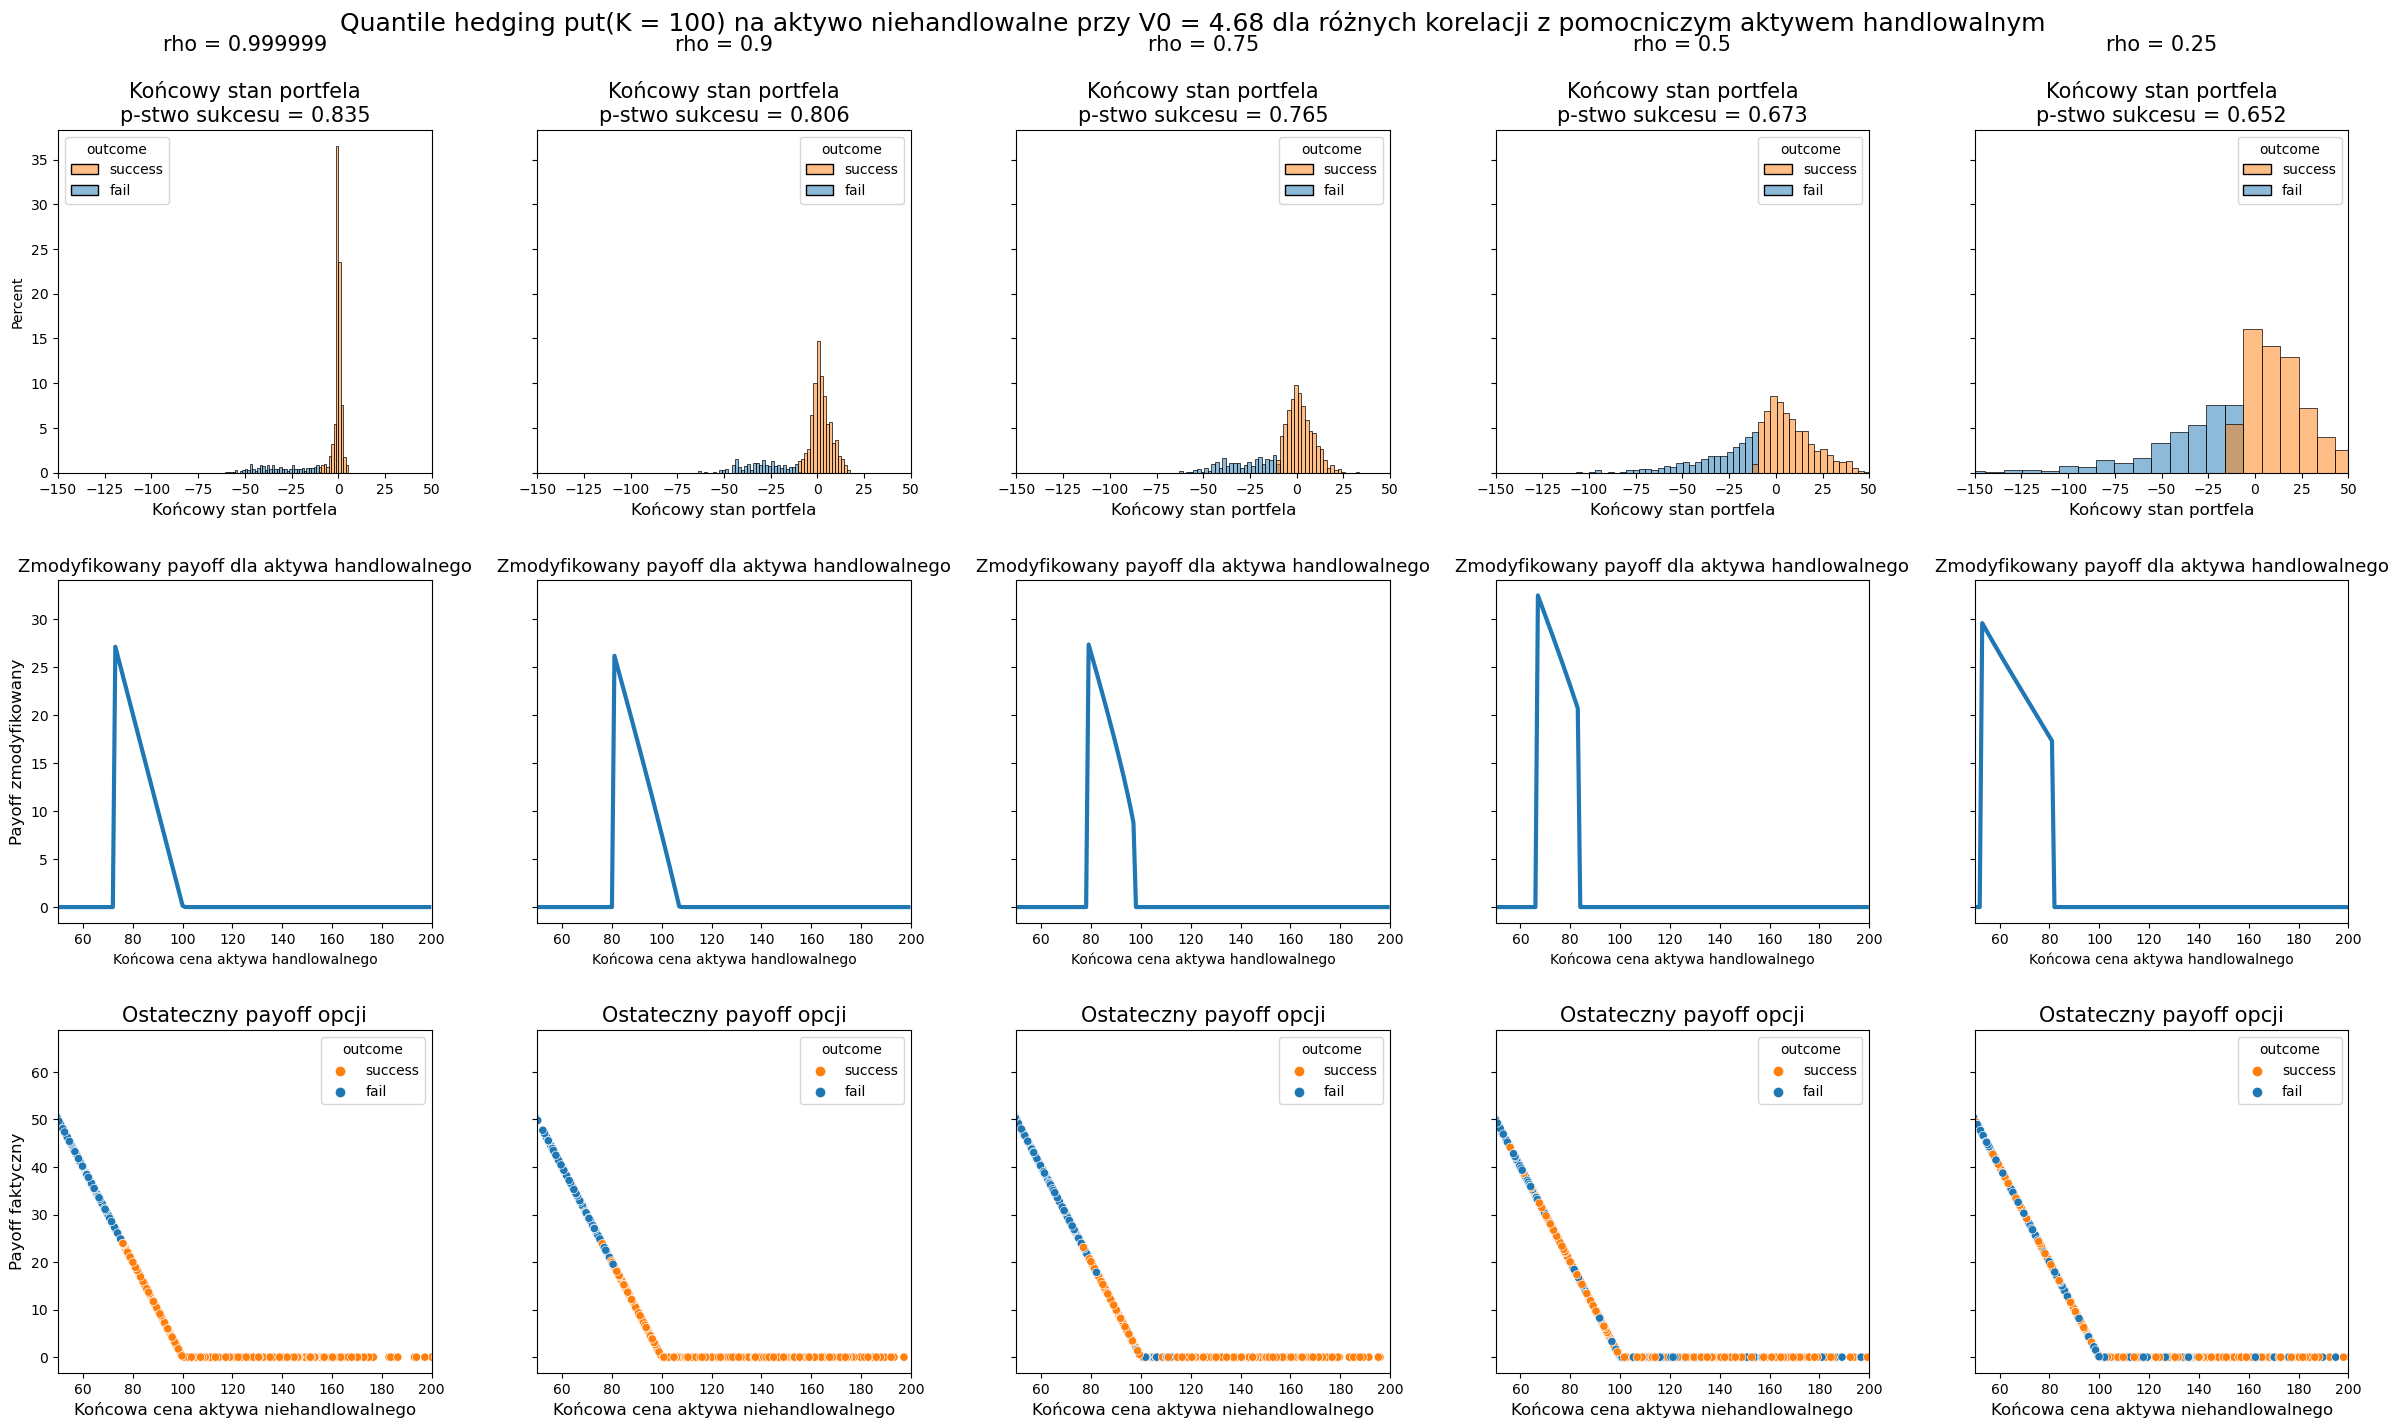

In [29]:
fig, axs = plt.subplots(3,5, figsize = (25, 15), sharey = 'row')
fig.tight_layout(pad=6.0)
V0 = BS_put / 2
for idx, rho in tqdm(enumerate([0.999999, 0.9, 0.75, 0.5, 0.25])):
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    [_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)
    
    put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)
    put_nt.set_m(V0, X0_t, X0_nt)
    sims_t = pd.DataFrame(np.ones(150), columns = [0])
    sims_t[1] = np.arange(50, 200) / X0_t
    payoff = put_nt.payoff_special((X0_t * sims_t), X0_nt)

    money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
    delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
    with Pool(processors) as p:
            results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
    for num, item in enumerate(results):
        money_time_put.loc[num] = item[0]
        delta_time_put.loc[num] = item[1]   
    money_time_put_outcome = money_time_put.copy()
    money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 10 else 'fail', axis = 1)
    sb.histplot(ax = axs[0, idx], x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = repeat // 20, hue = money_time_put_outcome['outcome'], palette = {'fail':'tab:blue','success':'tab:orange'}, legend = True, stat = 'percent')
    axs[0, idx].set_xlim([-150, 50])        
    axs[0, idx].set_title(f'rho = {rho}\n\nKońcowy stan portfela\np-stwo sukcesu = {(money_time_put_outcome["outcome"] == "success").mean():.3f}', fontsize = 15)
    axs[0, idx].set_xlabel('Końcowy stan portfela', fontsize = 12)
    axs[1, idx].plot((X0_t * sims_t).iloc[:,-1], payoff, lw = 3)
    axs[1, idx].set_title('Zmodyfikowany payoff dla aktywa handlowalnego', fontsize = 13)
    axs[1, idx].set_xlim([50,200])    
    axs[1, idx].set_xlabel('Końcowa cena aktywa handlowalnego')
    sb.scatterplot(ax = axs[2, idx], x = (X0_nt*reality_nt).iloc[:,-1], y = np.maximum(K - (X0_nt*reality_nt)[underlying_nt.values_per_year * T],0), hue = money_time_put_outcome['outcome'], palette = {'fail':'tab:blue','success':'tab:orange'}).set_title('Ostateczny payoff opcji', fontsize = 15)
    axs[2, idx].set_xlim([50,200])    
    axs[2, idx].set_xlabel('Końcowa cena aktywa niehandlowalnego', fontsize = 12)
    if idx == 0:
        axs[1, idx].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[2, idx].set_ylabel('Payoff faktyczny', fontsize = 12)    
plt.suptitle(f'Quantile hedging put(K = {K}) na aktywo niehandlowalne przy V0 = {V0:.2f} dla różnych korelacji z pomocniczym aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.9)


Tak jak w przypadku opcji call widzimy, że dla korelacji dodatnich mniejsza korelacja oznacza przy zadanym kapitale początkowym gorszy procent symulacji zabezpieczonych. W przypadku korelacji praktycznie idealnej widzimy, że zmodyfikowany payoff dla aktywa handlowalnego dobrze oddaje kwantylowy hedging opcji na aktywo handlowalne. Im mniejsze $\rho$ tym payoff dla używanego aktywa handlowalnego skupia się (pozostając niezerowym) na coraz mniejszym i bardziej przesuniętym w lewo przedziale. Oddalanie się prawego krańca od ceny wykonania możemy tłumaczyć tym, że jeśli korelacja jest mniejsza to bardziej prawdopodobne jest, że przy malejącej cenie aktywa handlowalnego, aktywo niehandlowalne urośnie, a więc nie poskutkuje żadnym payoffem. Nie mamy tu zatem zachowania znanego nam z opcji call, payoff nie może wypłaszczać się niejako ku coraz mniejszym cenom, ponieważ z dołu ogranicza go wartość $0$. W konsekwencji staje się on dla opcji put coraz "wyższy" kumulując coraz większy kapitał w zabezpieczenie coraz węższego obszaru. Tendencja ta nie do końca sprawdza się dla najmniejszej z rozważanych tu korelacji, gdzie niezerowy fragment ponownie się poszerza- może to mieć związek z ograniczeniem górnym wartości samego payoffu równym cenie wykonania. Jeśli zaś chodzi o faktyczne payoffy, na które okazaliśmy się zabezpieczeni widzimy, że im mniejsza korelacja między aktywami tym potencjalne zabezpieczenie staje się coraz bardziej losowe. Portfel nie jest idealnie skalibrowany pod aktywo, które decyduje o wypłacie opcji- potencjalne sukcesy wynikają bardziej z ułożenia cen dwóch instrumentów.

4it [1:49:13, 1638.37s/it]


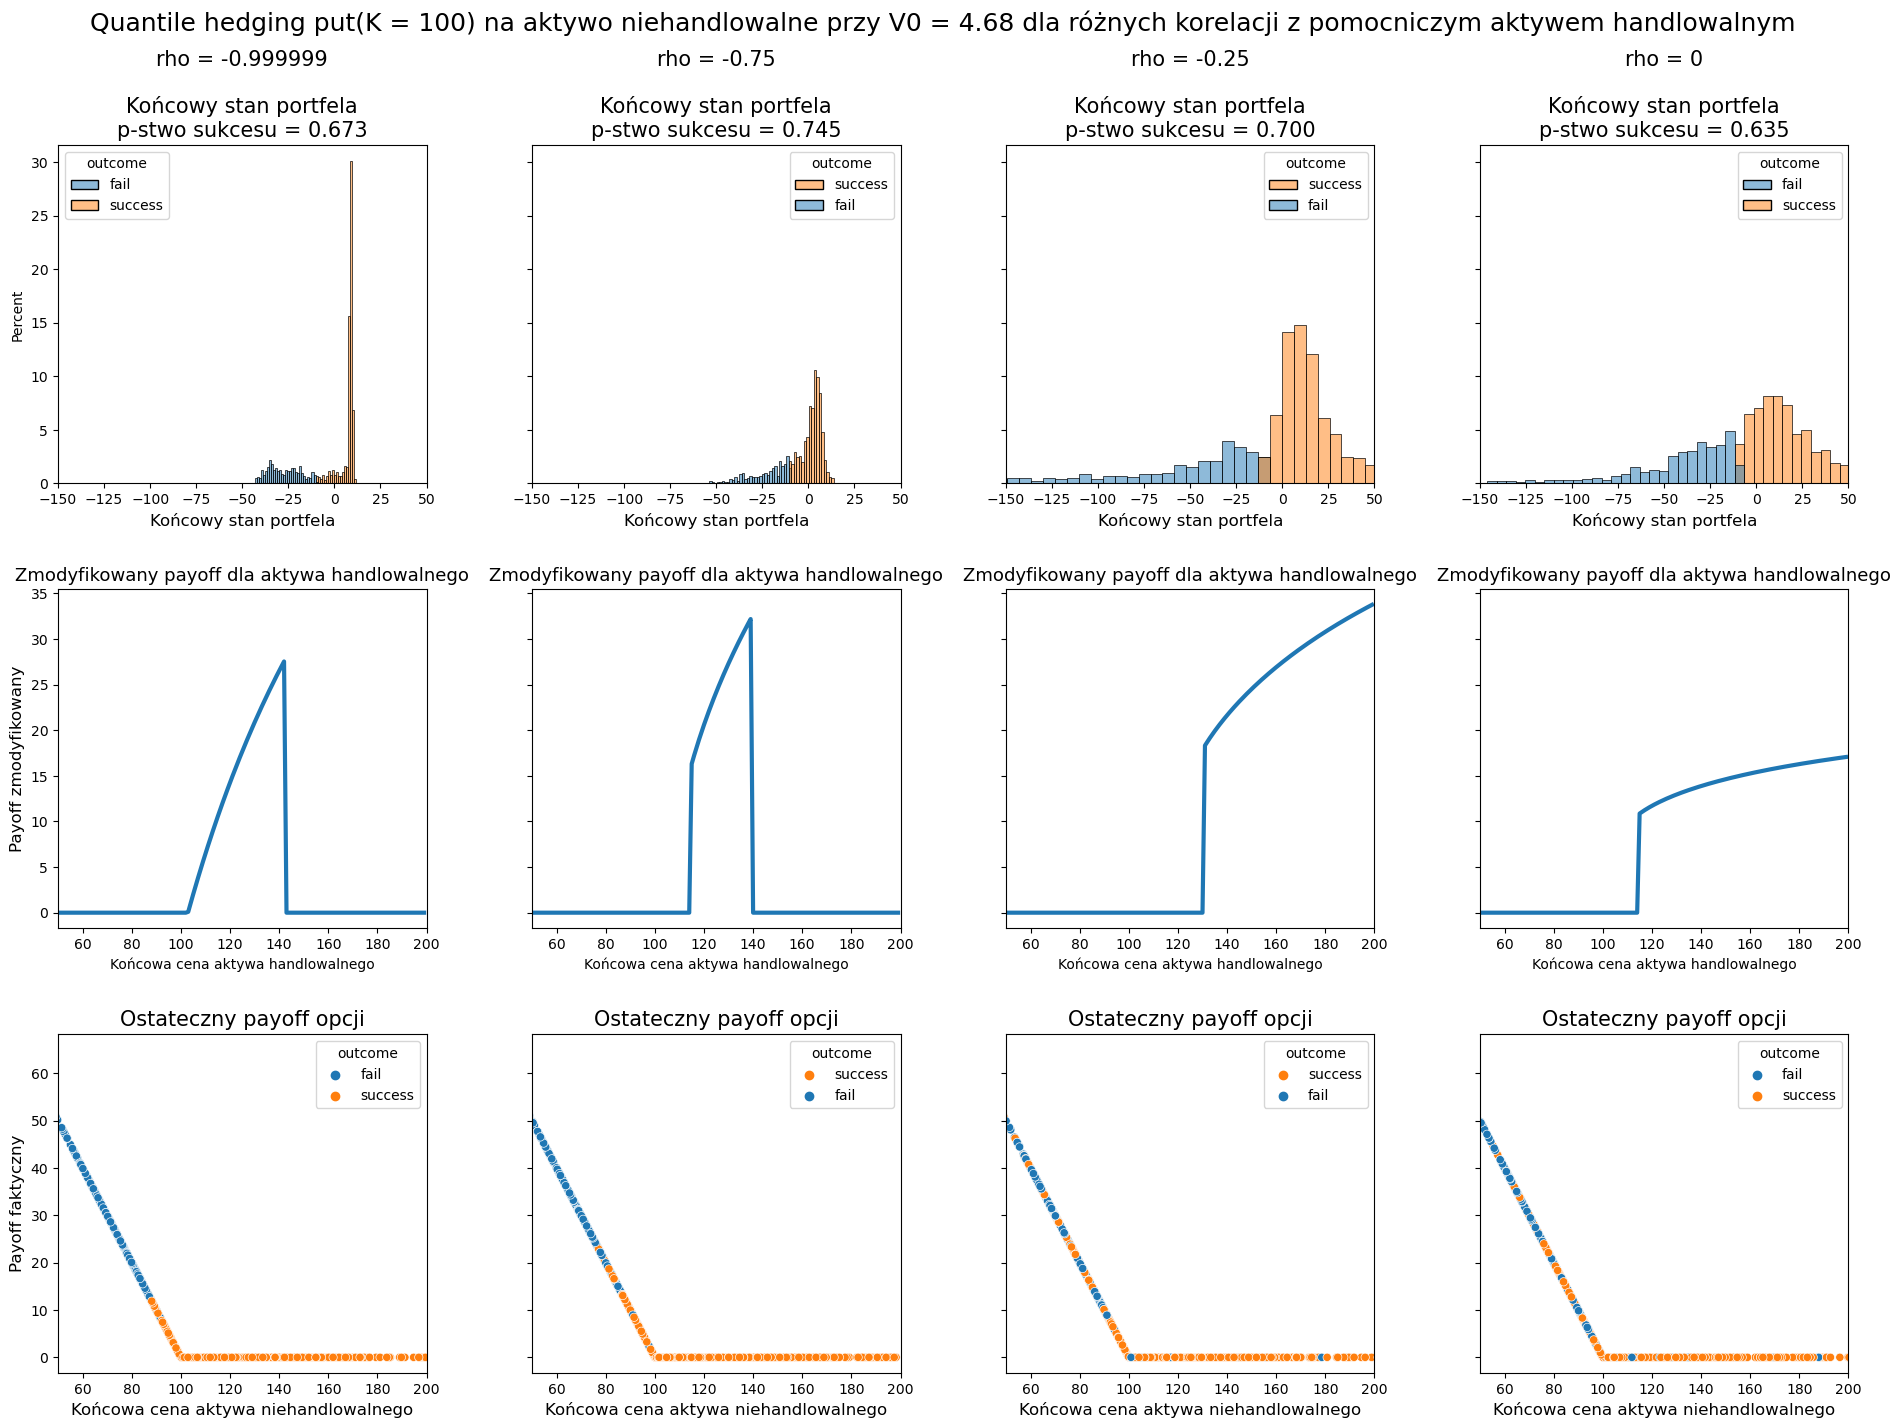

In [57]:
fig, axs = plt.subplots(3,4, figsize = (20, 15), sharey = 'row')
fig.tight_layout(pad=6.0)
V0 = BS_put / 2
for idx, rho in tqdm(enumerate([-0.999999, -0.75, -0.25, 0])):
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    [_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)
    
    put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)
    put_nt.set_m(V0, X0_t, X0_nt)
    sims_t = pd.DataFrame(np.ones(150), columns = [0])
    sims_t[1] = np.arange(50, 200) / X0_t
    payoff = put_nt.payoff_special((X0_t * sims_t), X0_nt)

    money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
    delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
    with Pool(processors) as p:
            results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
    for num, item in enumerate(results):
        money_time_put.loc[num] = item[0]
        delta_time_put.loc[num] = item[1]   
    money_time_put_outcome = money_time_put.copy()
    money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 10 else 'fail', axis = 1)
    sb.histplot(ax = axs[0, idx], x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = repeat // 20, hue = money_time_put_outcome['outcome'], palette = {'fail':'tab:blue','success':'tab:orange'}, legend = True, stat = 'percent')
    axs[0, idx].set_xlim([-150, 50])        
    axs[0, idx].set_title(f'rho = {rho}\n\nKońcowy stan portfela\np-stwo sukcesu = {(money_time_put_outcome["outcome"] == "success").mean():.3f}', fontsize = 15)
    axs[0, idx].set_xlabel('Końcowy stan portfela', fontsize = 12)
    axs[1, idx].plot((X0_t * sims_t).iloc[:,-1], payoff, lw = 3)
    axs[1, idx].set_title('Zmodyfikowany payoff dla aktywa handlowalnego', fontsize = 13)
    axs[1, idx].set_xlim([50,200])    
    axs[1, idx].set_xlabel('Końcowa cena aktywa handlowalnego')
    sb.scatterplot(ax = axs[2, idx], x = (X0_nt*reality_nt).iloc[:,-1], y = np.maximum(K - (X0_nt*reality_nt)[underlying_nt.values_per_year * T],0), hue = money_time_put_outcome['outcome'], palette = {'fail':'tab:blue','success':'tab:orange'}).set_title('Ostateczny payoff opcji', fontsize = 15)
    axs[2, idx].set_xlim([50,200])    
    axs[2, idx].set_xlabel('Końcowa cena aktywa niehandlowalnego', fontsize = 12)
    if idx == 0:
        axs[1, idx].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[2, idx].set_ylabel('Payoff faktyczny', fontsize = 12)    
plt.suptitle(f'Quantile hedging put(K = {K}) na aktywo niehandlowalne przy V0 = {V0:.2f} dla różnych korelacji z pomocniczym aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.89)


Kiedy korelacje są ujemne zabezpieczenia stają się gorsze (pod kątem frakcji symulacji zabepieczonych). Wyraźny trend widoczny jest w kontekście maksymalnej straty portfela, rośnie ona wraz ze zbliżaniem się korelacji do $0$- w tym właśnie przypadku sięga ona ponad $-150$. Wynika to z faktu, że zerowa korelacja oznacza całkowity brak kontroli na zachowanie aktywa niehandlowalnego- w tym wypadku także ostateczne payoffy są zabezpieczane w sposób częściowo losowy (pojedyncze pomarańczowe kropki na całym niezerowym payoffie). Wspomniane już prawdopodobieństwo sukcesu nieznacznie różni się pomiędzy przypadkami różnych $\rho$- różnią się natomiast formy payoffu zmodyfikowanego. Payoff ten rośnie wzrast ze wzrostem końcowej ceny aktywa pomocniczego, a więc jego zachowanie jest przeciwne do payoffu faktycznego. Ma to oczywiście związek ze znakiem korelacji- aktywa powinny zachowywac się w sposób sobie częściowo przeciwny.

### Stan portfela w czasie- jak zmienia się ilość posiadanego aktywa handlowalnego w czasie?

Wiemy już, że hedging próbuje posiadanym aktywem handlowalnym niejako dopasowywać się do charakterystyki aktywa niehandlowalnego. Na poniższych wykresach na przykładzie trzech skrajnych symulacji aktywa niehandlowalnego zobaczymy jak zachowywało się aktywo handlowalne oraz zmianę jego ilości w zabezpieczającym portfelu. Kapitał początkowy wynosić będzie ponownie połowę ceny waniliowego odpowiednika rozważanej opcji. W konsekwencji każdy z hedgingów będzie hedgingiem kwantylowym nie gwarantującym pełnego zabezpieczenia. Z tego powodu w pierwszym wierszu ukażemy postać zmodyfikowanego payoffu, który kluczowy jest w ilości posiadanego w portfelu zabezpieczającym aktywa handlowalnego. Czynnikiem zmieniającym się względem każdej z kolumn będzie korelacja $\rho$- zaprezentujemy przypadek idealnego skorelowania dodatniego, ujemnego oraz braku korelacji.

Rozpocznijmy rozważania od opcji kupna.

In [58]:
repeat = 100

Text(0.5, 0.98, 'Hedging kwantylowy calla(K=100) na aktywo niehandlowalne dla skrajnych korelacji z pomocniczym aktywem handlowalnym')

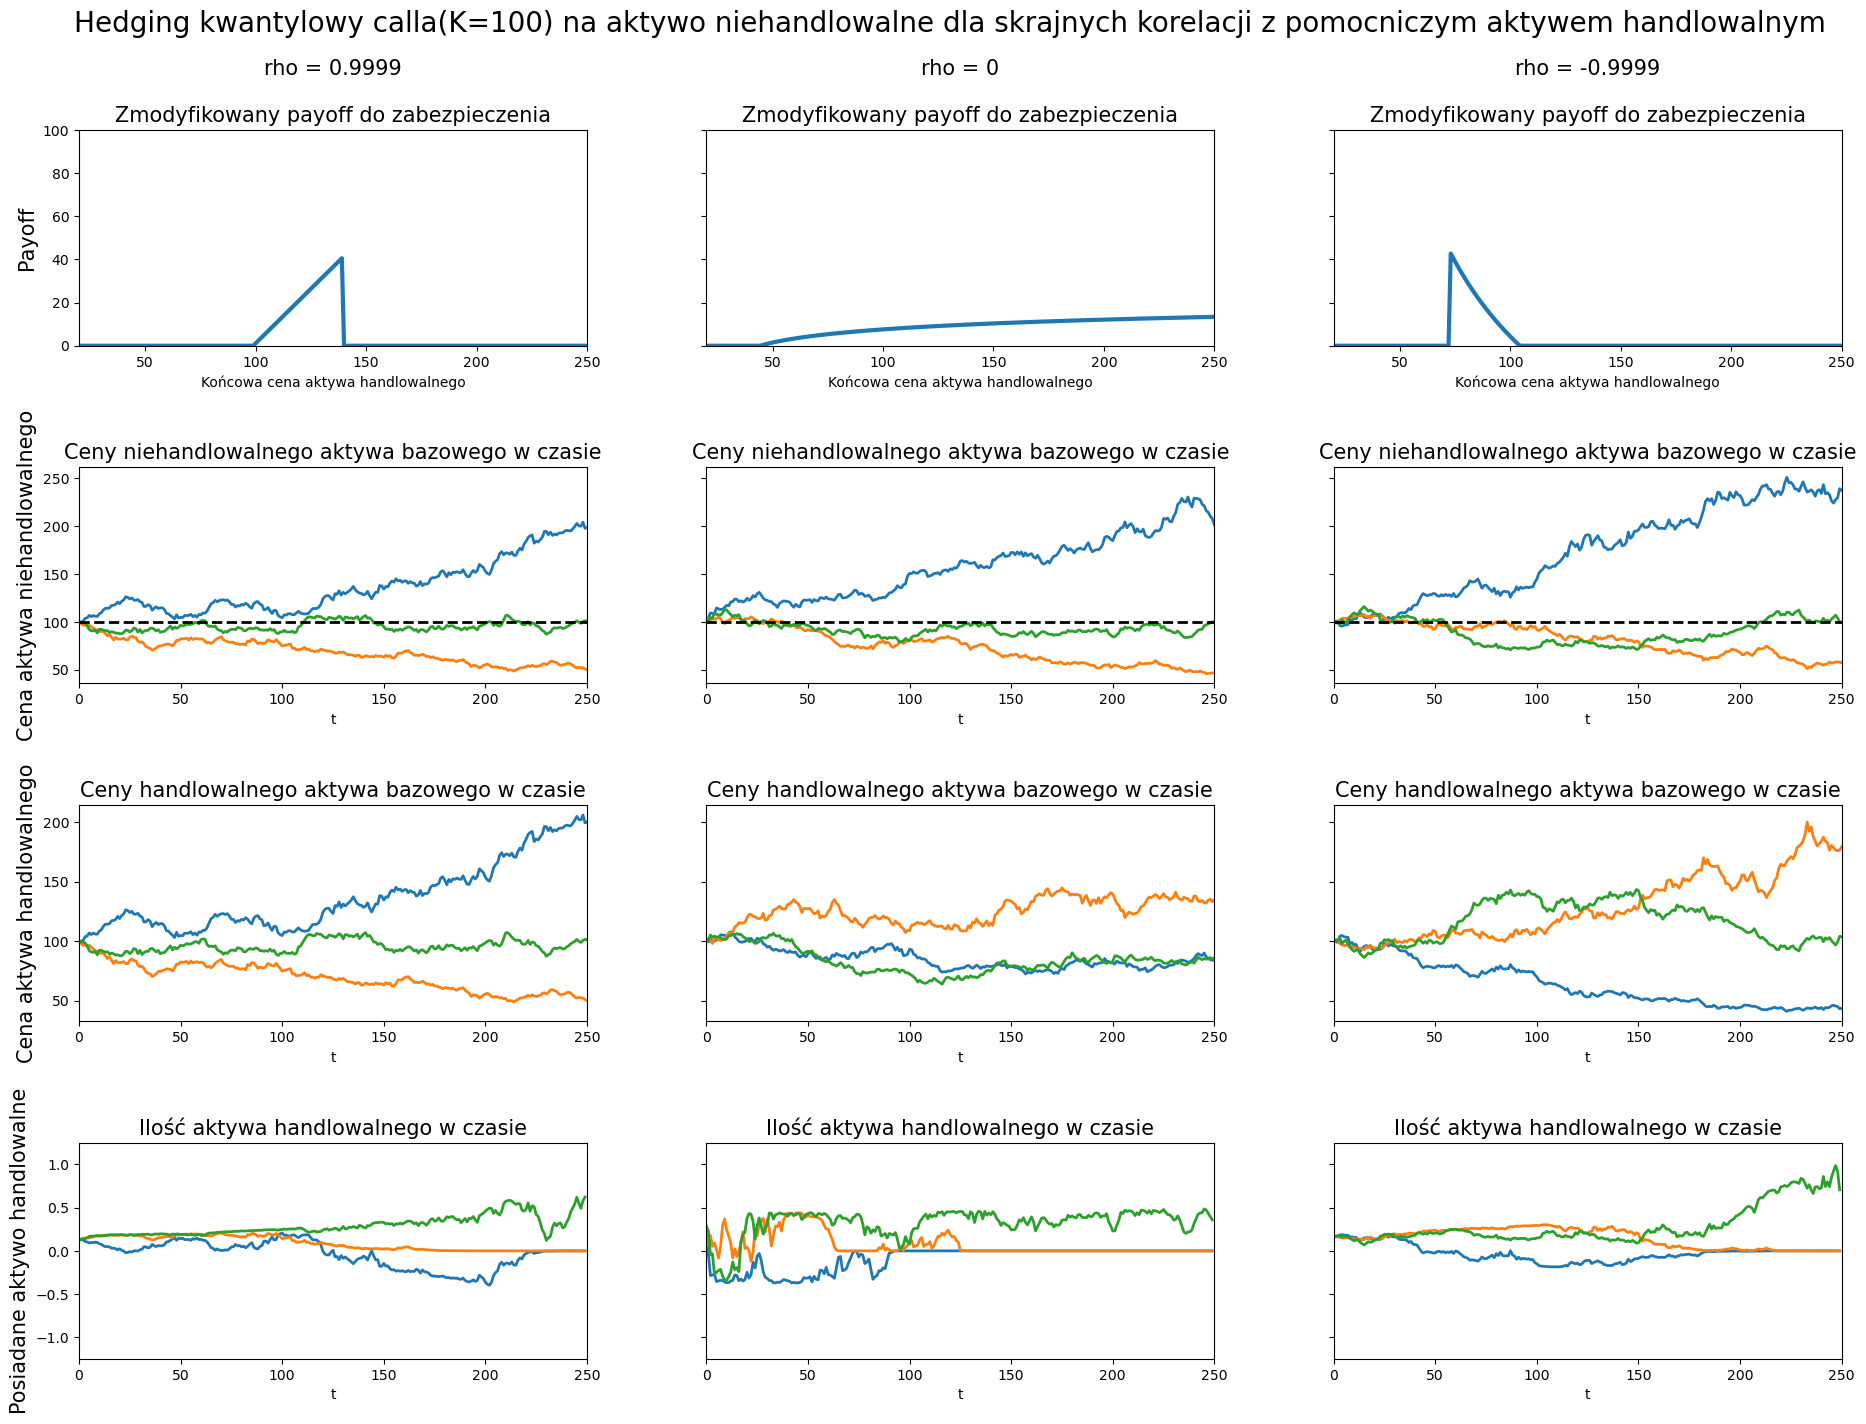

In [59]:
V0 = BS_call / 2
fig, axs = plt.subplots(4,3, figsize = (20, 15), sharey = 'row')
fig.tight_layout(pad=7.0)
plt.subplots_adjust(top=0.9)
for idx, rho in enumerate([0.9999, 0, -0.9999]):
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    [_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)
    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
    call_nt.set_m(V0, X0_t, X0_nt)   
    sims_t = pd.DataFrame(np.ones(250), columns = [0])
    sims_t[1] = np.arange(10, 260) / X0_t
    payoff = call_nt.payoff_special((X0_t * sims_t), X0_nt)
    
    money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
    delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
    with Pool(processors) as p:
            results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
    for num, item in enumerate(results):
        money_time_call.loc[num] = item[0]
        delta_time_call.loc[num] = item[1]   
    axs[0, idx].plot((X0_t * sims_t).iloc[:,-1], payoff, lw = 3)
    axs[0, idx].set_xlim([20, 250])
    axs[0, idx].set_ylim([0, 100])
    axs[0, idx].set_xlabel('Końcowa cena aktywa handlowalnego')
    axs[0, idx].set_ylabel('Payoff', size = 15)
    axs[0, idx].set_title(f'rho = {rho}\n\nZmodyfikowany payoff do zabezpieczenia', size = 15)
    indices = [(X0_nt * reality_nt).iloc[:,-1].idxmax(),(X0_nt * reality_nt).iloc[:,-1].idxmin(), abs((X0_nt * reality_nt).iloc[:,-1] - K).idxmin()]
    (X0_nt*reality_nt.iloc[indices,:]).T.plot.line(legend = False, ax = axs[1, idx], lw=2)
    axs[1, idx].set_xlim([0,values_per_year])
    axs[1, idx].set_xlabel('t')
    axs[1, idx].set_ylabel('Cena aktywa niehandlowalnego', size = 15)
    axs[1, idx].set_title('Ceny niehandlowalnego aktywa bazowego w czasie', size = 15)
    axs[1, idx].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
    (X0_t*reality_t.iloc[indices,:]).T.plot.line(legend = False, ax = axs[2, idx], lw=2)
    axs[2, idx].set_xlim([0,values_per_year])
    axs[2, idx].set_xlabel('t')
    axs[2, idx].set_ylabel('Cena aktywa handlowalnego', size = 15)
    axs[2, idx].set_title('Ceny handlowalnego aktywa bazowego w czasie', size = 15)
    (delta_time_call.iloc[indices,:-1]).T.plot(legend = False, ax = axs[3, idx], lw=2)
    axs[3, idx].set_xlim([0,values_per_year])
    axs[3, idx].set_xlabel('t')
    axs[3, idx].set_ylabel('Posiadane aktywo handlowalne', size = 15)
    axs[3, idx].set_title('Ilość aktywa handlowalnego w czasie', size = 15)
    axs[3, idx].set_ylim([-1.25, 1.25])
plt.suptitle(f'Hedging kwantylowy calla(K={K}) na aktywo niehandlowalne dla skrajnych korelacji z pomocniczym aktywem handlowalnym', size = 20)

W przypadku opcji kupna i korelacji skrajnie dodatniej widzimy, że trend obu aktywów jest podobny. Zacznijmy od analizy stanu portfela w przypadku symulacji pomarańczowych- aktywo niehandlowalne (jak również handlowalne) szybko spada poniżej cenę wykonania, co zeruje ilość posiadanego instrumentu. Symulacje niebieskie, a więc te z najwyższymi cenami w przypadku wystarczającego kapitału na pełne zabezpieczenie powinny skutkować zbliżającą się ku $1$ wartością parametru $\Delta$. Zauważmy jednak, że ze względu na kapitał ograniczony payoff, na który się przygotowujemy zeruje się powyżej $140$- w konsekwencji zeruje się także ilość aktywa bazowego służącego do zabezpieczania. Ostatnia z par symulacji- te układające się blisko ceny wykonania skutkują stosunkowo wysoką wartością posiadanej $\Delta$ ze względu na dużą szansę, że do dojdzie do "wykonania" dla payoffu zmodyfikowanego. W przypadku korelacji skrajnie ujemnej wnioski są stosunkowo podobne choć oczywiście znak $\rho$ obraca nam "wymogi" na aktywie handlowalnym. Warto tu odnotować dodatkowy wniosek- rezultaty portfela mogą być w tym wypadku gorsze niż dla korelacji dodatniej ze względu na nieintuicyjne zachowanie kupowania intensywnie aktywa, którego wartość spada. Dla korelacji zerowej zachowanie ilości aktywa bazowego w portfelu jest najbardziej losowe ze względu na brak żadnej kontroli aktywa głównego. Próbujemy tutaj niejako zabezpieczać szum, skutkuje to dużą niepewnością i $\Delta$, która nigdy nie przekracza co do wartości bezwzględnej $0.5$.

Text(0.5, 0.98, 'Hedging kwantylowy puta(K=100) na aktywo niehandlowalne dla skrajnych korelacji z pomocniczym aktywem handlowalnym')

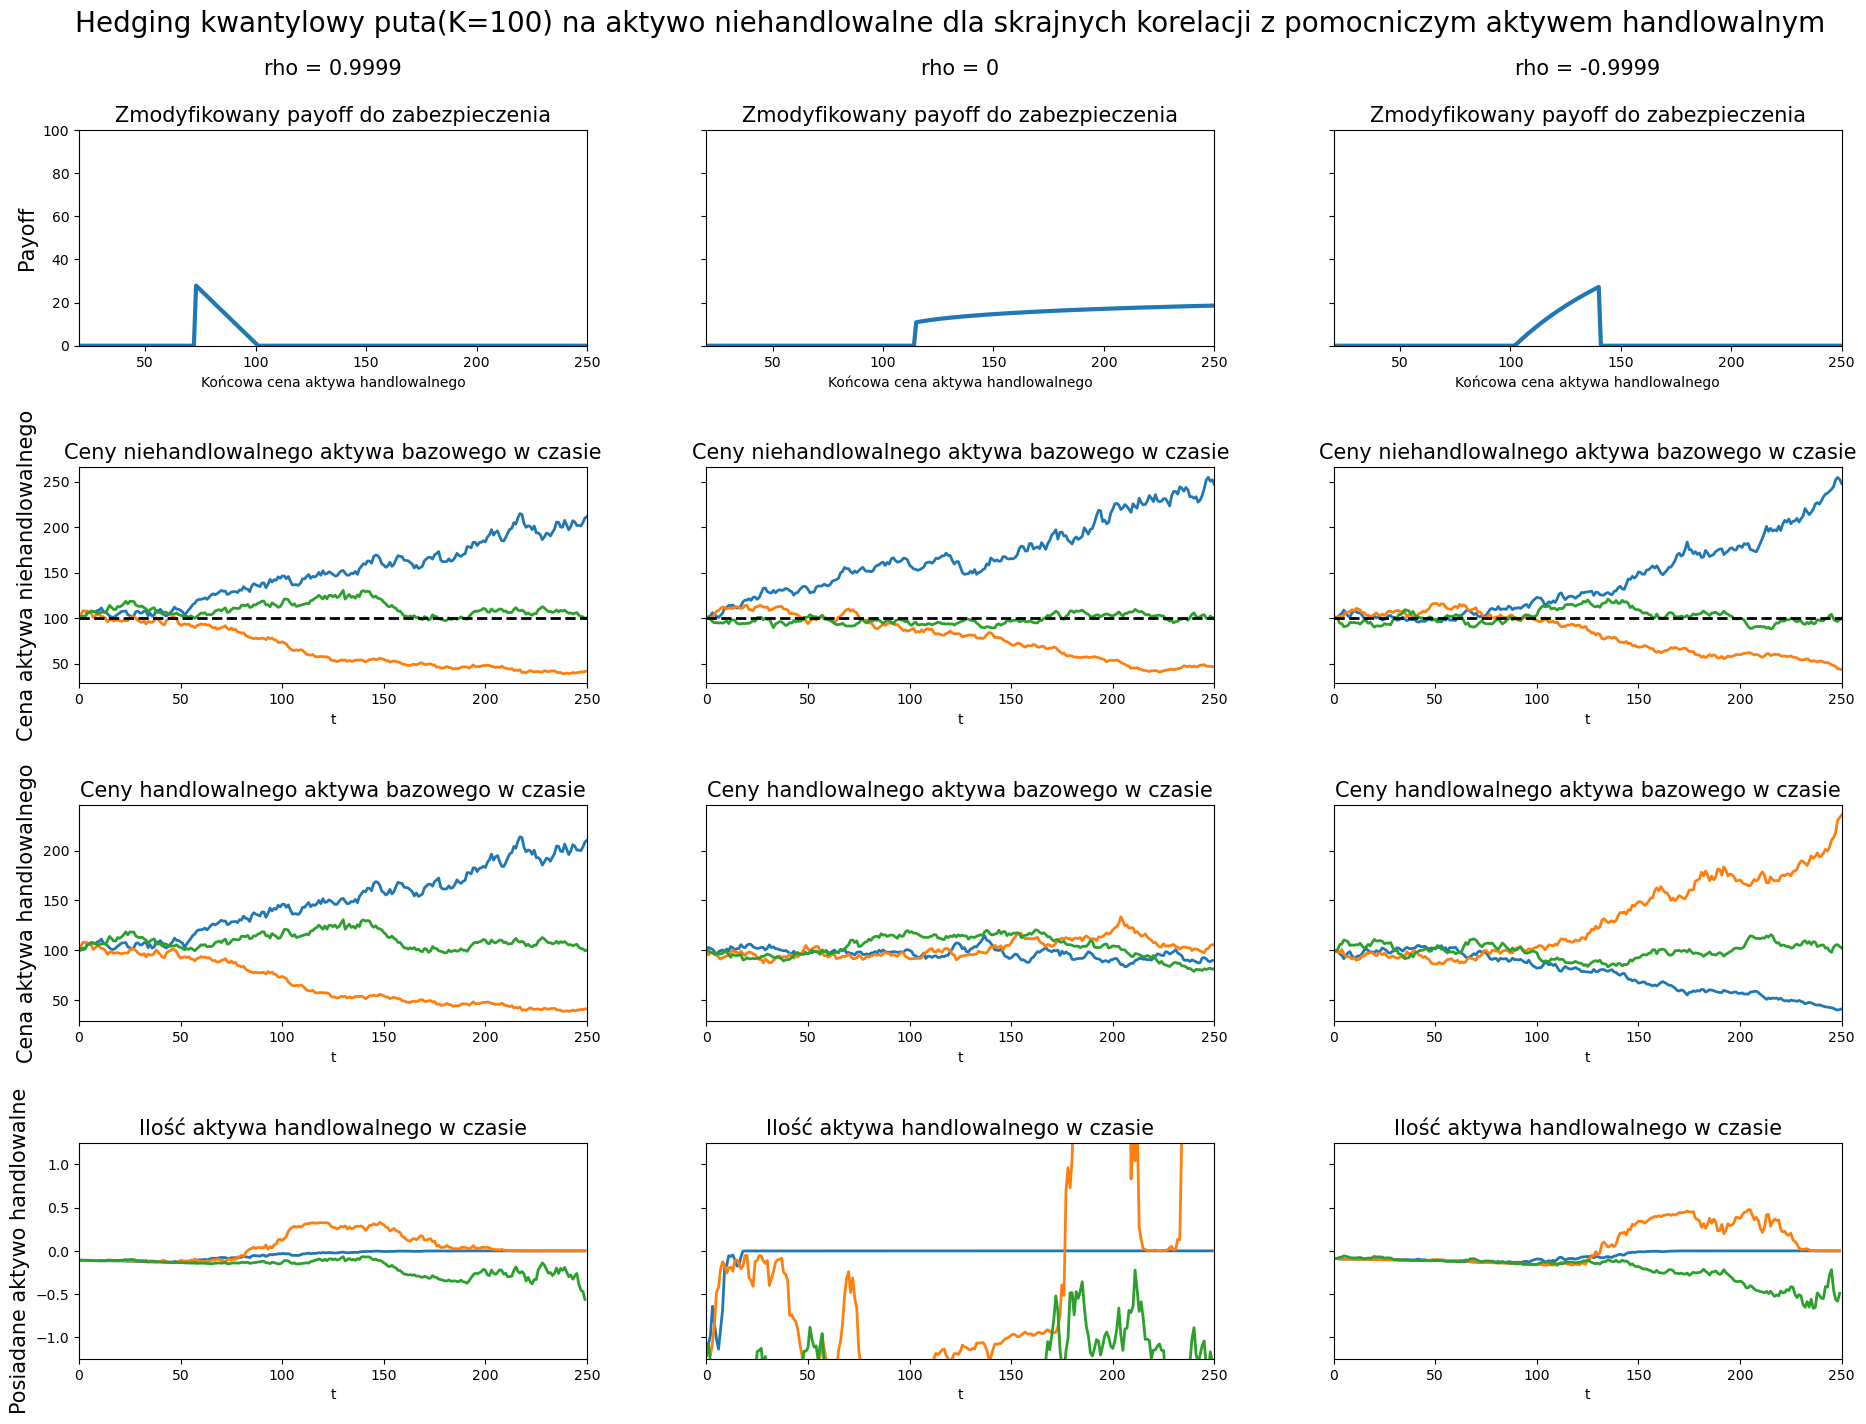

In [60]:
V0 = BS_put / 2
fig, axs = plt.subplots(4,3, figsize = (20, 15), sharey = 'row')
fig.tight_layout(pad=7.0)
plt.subplots_adjust(top=0.9)
for idx, rho in enumerate([0.9999, 0, -0.9999]):
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    [_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)
    put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)
    put_nt.set_m(V0, X0_t, X0_nt)    
    sims_t = pd.DataFrame(np.ones(250), columns = [0])
    sims_t[1] = np.arange(10, 260) / X0_t
    payoff = put_nt.payoff_special((X0_t * sims_t), X0_nt)
    
    money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
    delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
    with Pool(processors) as p:
            results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
    for num, item in enumerate(results):
        money_time_put.loc[num] = item[0]
        delta_time_put.loc[num] = item[1]   
    axs[0, idx].plot((X0_t * sims_t).iloc[:,-1], payoff, lw = 3)
    axs[0, idx].set_xlim([20, 250])
    axs[0, idx].set_ylim([0, 100])
    axs[0, idx].set_xlabel('Końcowa cena aktywa handlowalnego')
    axs[0, idx].set_ylabel('Payoff', size = 15)
    axs[0, idx].set_title(f'rho = {rho}\n\nZmodyfikowany payoff do zabezpieczenia', size = 15)
    indices = [(X0_nt * reality_nt).iloc[:,-1].idxmax(),(X0_nt * reality_nt).iloc[:,-1].idxmin(), abs((X0_nt * reality_nt).iloc[:,-1] - K).idxmin()]
    (X0_nt*reality_nt.iloc[indices,:]).T.plot.line(legend = False, ax = axs[1, idx], lw=2)
    axs[1, idx].set_xlim([0,values_per_year])
    axs[1, idx].set_xlabel('t')
    axs[1, idx].set_ylabel('Cena aktywa niehandlowalnego', size = 15)
    axs[1, idx].set_title('Ceny niehandlowalnego aktywa bazowego w czasie', size = 15)
    axs[1, idx].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
    (X0_t*reality_t.iloc[indices,:]).T.plot.line(legend = False, ax = axs[2, idx], lw=2)
    axs[2, idx].set_xlim([0,values_per_year])
    axs[2, idx].set_xlabel('t')
    axs[2, idx].set_ylabel('Cena aktywa handlowalnego', size = 15)
    axs[2, idx].set_title('Ceny handlowalnego aktywa bazowego w czasie', size = 15)
    (delta_time_put.iloc[indices,:-1]).T.plot(legend = False, ax = axs[3, idx], lw=2)
    axs[3, idx].set_xlim([0,values_per_year])
    axs[3, idx].set_xlabel('t')
    axs[3, idx].set_ylabel('Posiadane aktywo handlowalne', size = 15)
    axs[3, idx].set_title('Ilość aktywa handlowalnego w czasie', size = 15)
    axs[3, idx].set_ylim([-1.25,1.25])
plt.suptitle(f'Hedging kwantylowy puta(K={K}) na aktywo niehandlowalne dla skrajnych korelacji z pomocniczym aktywem handlowalnym', size = 20)

W porównaniu do opcji call tutaj dla korelacji skrajnie dodatniej niebieska oraz pomarańczowa "rzeczywistość, gdzie aktywo niehandlowalne jest odpowiednio największe i najmniejsze zamieniają się niejako miejscami. Ilość posiadanego aktywa handlowalnego w przypadku symulacji niebieskiej zeruje się z powodu charakteru opcji put, dla symulacji pomarańczowej natomiast wynika to z niepełnego kapitału początkowego, a w konsekwencji obcięcia payoffu zmodyfikowanego identycznie wycenianego aktywa handlowalnego. Dla korelacji skrajnie ujemnej mamy sytuacje dość analogiczną. W obu rozważanych kolumnach zestaw określający rzeczywistość związaną z oscylującą wokół ceny wykonania ceną aktywa niehandlowalnego (i podobnie zachowującym się aktywem handlowalnym) nie zeruje ilości aktywa ze względu na szansę dodatniego payoffu zmodyfikowanego. Korelacja zerowa daje nam wyniki bardzo nieregularne- nie jesteśmy w stanie zabezpieczać opcji na aktywo niehandlowalne niezwiązanym z nim aktywem handlowalnym.

### Analiza wrażliwości zmodyfikowanego payoffu opcji

Kolejne wykresy przedstawiać będą wrażliwość funkcji zmodyfikowanego payoffu dla używanego do zabezpieczania opcji aktywa handlowalnego. Skupimy się na zależności względem rodzaju opcji, ceny wykonania, stosunku zmienności obu aktywów oraz procentu użytej pełnej ceny analogicznej opcji standardowej jako kapitału początkowego. Jeśli dany parametr nie jest w danym przypadku zmienny to przyjmujemy $K = 100$, $\sigma_{NH}=1 \cdot \sigma_{H}=0.3$ oraz $V_0$ w postaci połowy pełnej ceny standardowej opcji. W każdym z rozważanych wykresów przedstawiać będziemy przypadek z korelacją $\rho = +-0.75$.

#### Wrażliwość na cenę wykonania

6it [00:14,  2.38s/it]


Text(0.5, 0.98, 'Kwantylowy hedging na callu na aktywo niehandlowalne w zależności od ceny wykonania K\nzmodyfikowany payoff')

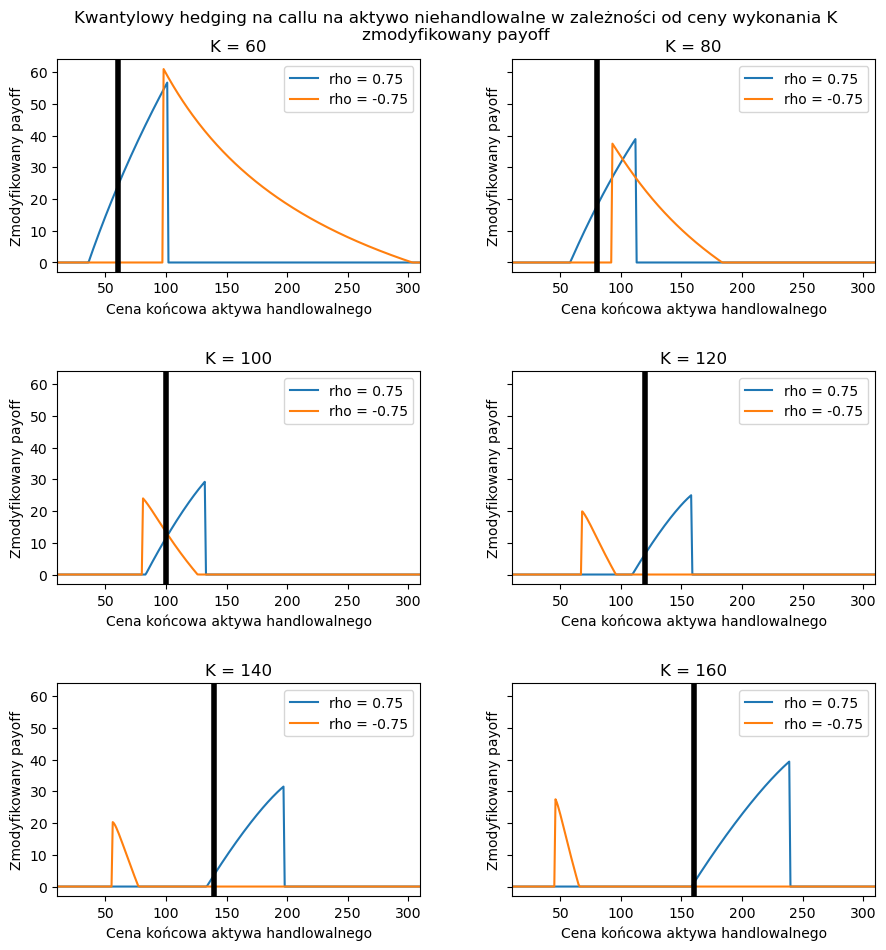

In [135]:
rho = 0.75
V0 = BS_call / 2
Ks = [60, 80, 100, 120, 140, 160]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(3, 2, figsize=(10,10), sharey = True)
fig.tight_layout(pad=5.0)
for num, K in tqdm(enumerate(Ks)):
    sims_t = pd.DataFrame(np.ones(300), columns = [0])
    sims_t[1] = np.arange(10, 310) / X0_t
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
    V0 = Vanilla(underlying_t, K, T, True).get_price(X0_nt) / 2
    call_nt.set_m(V0, X0_t, X0_nt)
    payoff1 = call_nt.payoff_special((X0_t * sims_t), X0_nt)   
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, -rho)
    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
    call_nt.set_m(V0, X0_t, X0_nt)
    payoff2 = call_nt.payoff_special((X0_t * sims_t), X0_nt)  
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff1, label = f'rho = {rho}')
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff2, label = f'rho = {-rho}')
    axs[num//2, num%2].legend(loc = 'upper right')
    axs[num//2, num%2].set_title(f'K = {K}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
    axs[num//2, num%2].set_xlim([10, 310])
    axs[num//2, num%2].set_xlabel('Cena końcowa aktywa handlowalnego')
    axs[num//2, num%2].set_ylabel('Zmodyfikowany payoff')
plt.subplots_adjust(top=0.93)
plt.suptitle(f'Kwantylowy hedging na callu na aktywo niehandlowalne w zależności od ceny wykonania K\nzmodyfikowany payoff', size = 12)

Widzimy, że w przypadku opcji kupna i korelacji dodatniej im większa cena wykonania $K$ tym szerszy przedział niezerowego payoffu. Wynika to z faktu, że ilość symulacji aktywa niehandlowalnego, które osiągną wartości powyżej $K$ w tym przypadku maleje, w konsekwencji możemy tym samym kosztem być zabezpieczeni dla wyższych wartości końcowych. Przypadek z korelacją ujemną jest podobny z dokładnością do odwrócenia payoffu- wydzimu tu jednak że od pewnego momentu nie zabezpieczamy się na coraz mniejsze ceny aktywa handlowego, a jedynie na ten sam przedział, ale z wyższym potencjalnym payoffem. Wynika to z faktu pewnej nieprzeskalowalności nieskończonego potencjalnego wzrostu aktywa niehandlowalnego, a ograniczonej straty instrumentu pomocniczego.

6it [00:14,  2.39s/it]


Text(0.5, 0.98, 'Kwantylowy hedging na puta na aktywo niehandlowalne w zależności od ceny wykonania K\nzmodyfikowany payoff')

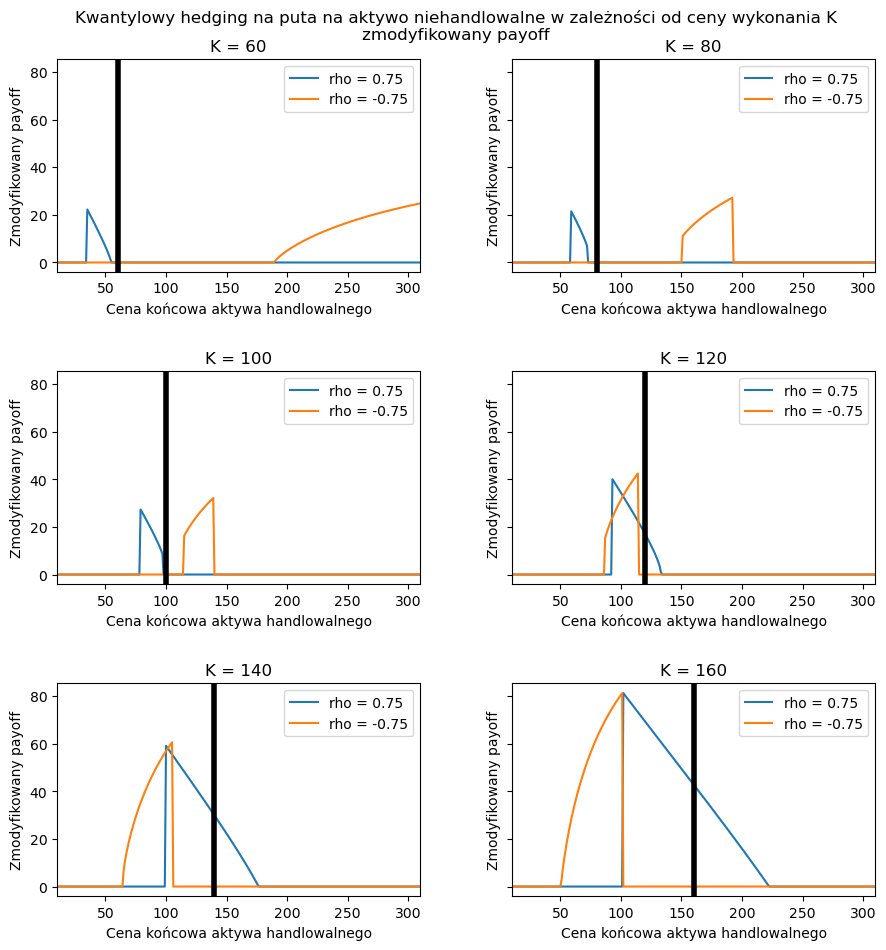

In [136]:
rho = 0.75
Ks = [60, 80, 100, 120, 140, 160]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(3, 2, figsize=(10,10), sharey = True)
fig.tight_layout(pad=5.0)
for num, K in tqdm(enumerate(Ks)):
    sims_t = pd.DataFrame(np.ones(300), columns = [0])
    sims_t[1] = np.arange(10, 310) / X0_t
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    V0 = Vanilla(underlying_t, K, T, False).get_price(X0_nt) / 2
    put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)
    put_nt.set_m(V0, X0_t, X0_nt)
    payoff1 = put_nt.payoff_special((X0_t * sims_t), X0_nt)   
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, -rho)
    put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)
    put_nt.set_m(V0, X0_t, X0_nt)
    payoff2 = put_nt.payoff_special((X0_t * sims_t), X0_nt)  
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff1, label = f'rho = {rho}')
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff2, label = f'rho = {-rho}')
    axs[num//2, num%2].legend(loc = 'upper right')
    axs[num//2, num%2].set_title(f'K = {K}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
    axs[num//2, num%2].set_xlim([10, 310])
    axs[num//2, num%2].set_xlabel('Cena końcowa aktywa handlowalnego')
    axs[num//2, num%2].set_ylabel('Zmodyfikowany payoff')
plt.subplots_adjust(top=0.93)
plt.suptitle(f'Kwantylowy hedging na puta na aktywo niehandlowalne w zależności od ceny wykonania K\nzmodyfikowany payoff', size = 12)

Przypadek opcji sprzedaży jest dużo trudniejszy do interpretacji. Zauważalna jest pewna nieidealna symetryczność obu wykresów względem ceny początkowej $X_{0,NH}=X_{0,H}=100$. Skrajnie mała cena wykonania upodabnia wykresy (szczególnie ten z $\rho = 0.75$) do payoffu standardowego opcji put. Dla skrajnie wysokiego $K$ widzimy natomiast, że choć korelacja jest ujemna payoff pomarańczowy znajduje się w całości po lewej stronie ceny wykonania. Wynika to z faktu, że jak już wspomniano ceny obu aktywów są w pewnym stopniu symetryczne do ich początkowej wartości $100$. W konsekwencji wartości aktywa bazowego pomiędzy $60$, a $70$ mogą sugerować wyniki z zakresu $130-140$ instrumentu głównego, a więc takie, gdzie payoff faktyczny byłby istotnie niezerowy i trzeba się na niego przygotować.

#### Wrażliwość na procent ceny analogicznej opcji waniliowej użyty do zabezpieczania

8it [00:18,  2.26s/it]


Text(0.5, 0.98, 'Kwantylowy hedging na callu(K = 100) na aktywo niehandlowalne w zależności od procenta użytej ceny zwykłego calla\nzmodyfikowany payoff')

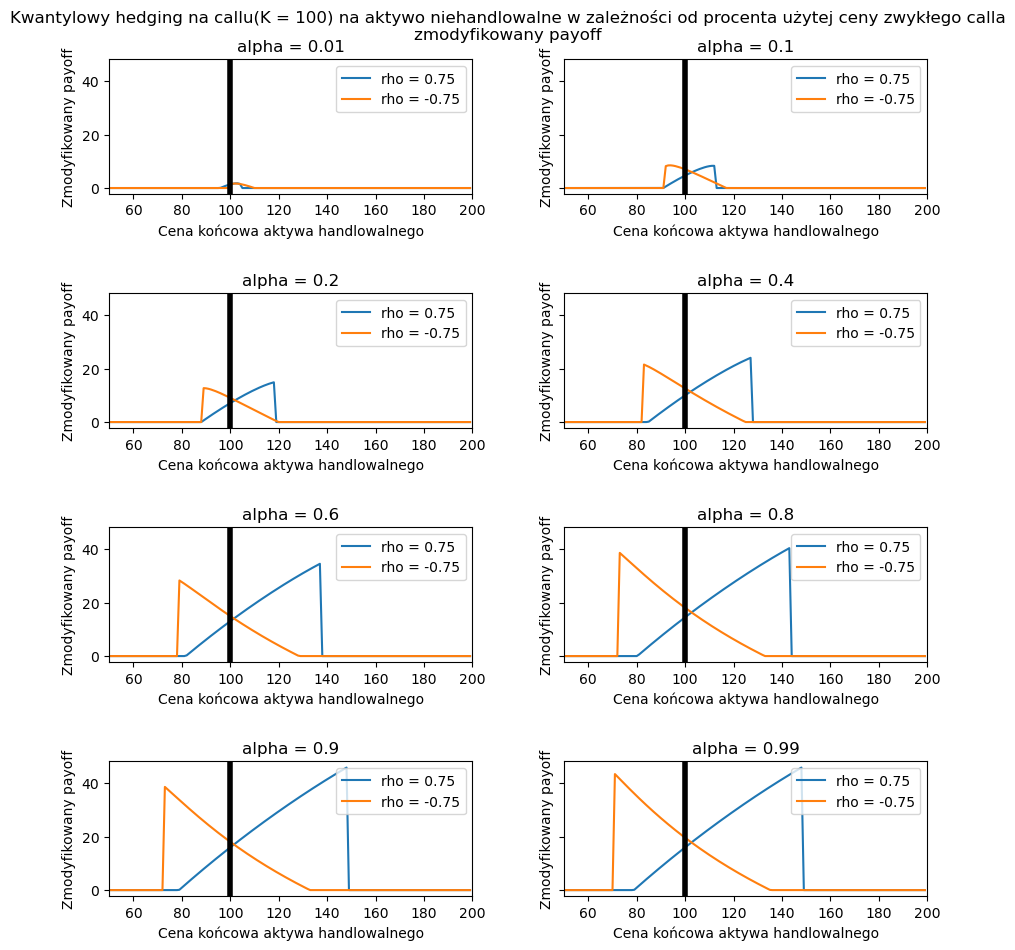

In [114]:
K = 100
rho = 0.75
alphas = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharey = True)
fig.tight_layout(pad=5.0)
for num, alpha in tqdm(enumerate(alphas)):
    sims_t = pd.DataFrame(np.ones(150), columns = [0])
    sims_t[1] = np.arange(50, 200) / X0_t
    V0 = BS_call * alpha
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
    call_nt.set_m(V0, X0_t, X0_nt)
    payoff1 = call_nt.payoff_special((X0_t * sims_t), X0_nt)   
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, -rho)
    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
    call_nt.set_m(V0, X0_t, X0_nt)
    payoff2 = call_nt.payoff_special((X0_t * sims_t), X0_nt)  
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff1, label = f'rho = {rho}')
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff2, label = f'rho = {-rho}')
    axs[num//2, num%2].legend(loc = 'upper right')
    axs[num//2, num%2].set_title(f'alpha = {alpha}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
    axs[num//2, num%2].set_xlim([50,200])
    axs[num//2, num%2].set_xlabel('Cena końcowa aktywa handlowalnego')
    axs[num//2, num%2].set_ylabel('Zmodyfikowany payoff')
plt.subplots_adjust(top=0.93)
plt.suptitle(f'Kwantylowy hedging na callu(K = {K}) na aktywo niehandlowalne w zależności od procenta użytej ceny zwykłego calla\nzmodyfikowany payoff', size = 12)

W tym wypadku wszystkie wykresy są stosunkowo łatwo interpretowalne- im większy procent ceny opcji standardowej tym na większy przedział końcowej wartości aktywa handlowalnego rzutujący także na przedział aktywa głownego możemy się przygotować. 

8it [00:18,  2.34s/it]


Text(0.5, 0.98, 'Kwantylowy hedging na puta(K = 100) na aktywo niehandlowalne w zależności od procenta użytej ceny zwykłego calla\nzmodyfikowany payoff')

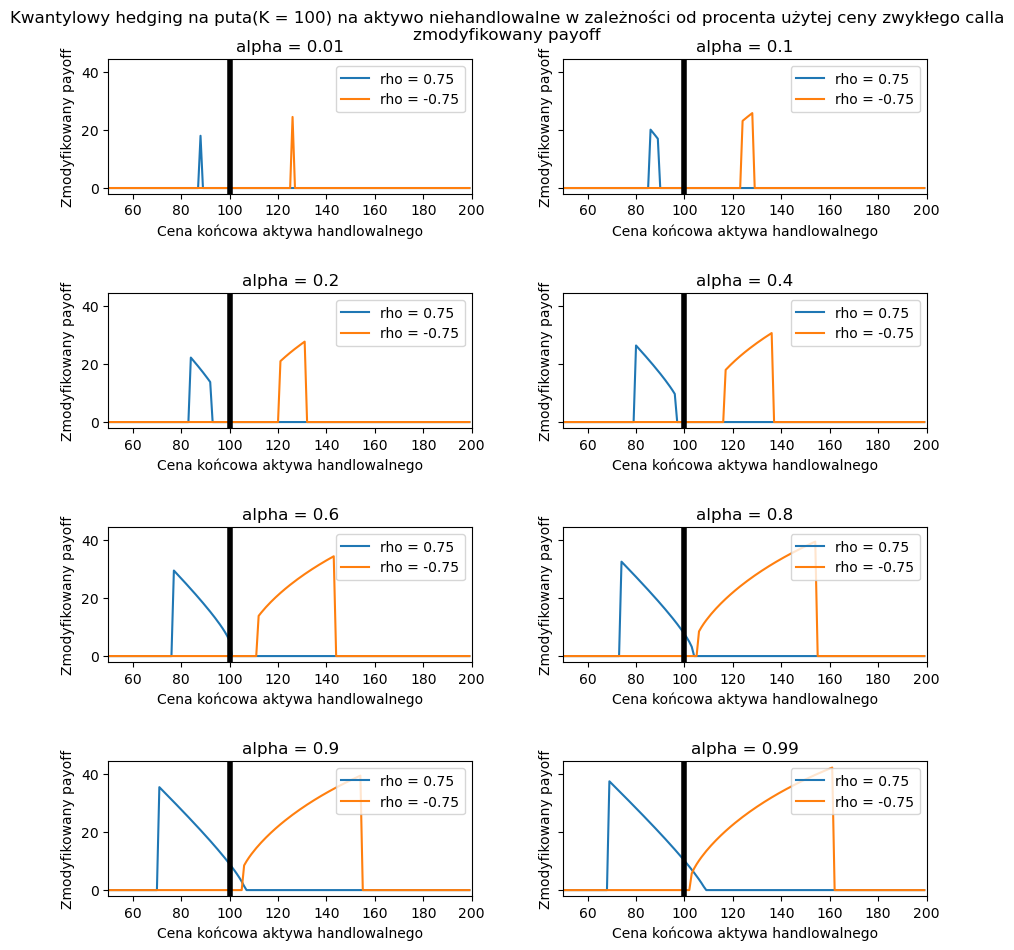

In [115]:
K = 100
rho = 0.75
alphas = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(4, 2, figsize=(10,10), sharey = True)
fig.tight_layout(pad=5.0)
for num, alpha in tqdm(enumerate(alphas)):
    sims_t = pd.DataFrame(np.ones(150), columns = [0])
    sims_t[1] = np.arange(50, 200) / X0_t
    V0 = BS_put * alpha
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)
    put_nt.set_m(V0, X0_t, X0_nt)
    payoff1 = put_nt.payoff_special((X0_t * sims_t), X0_nt)   
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, -rho)
    put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)
    put_nt.set_m(V0, X0_t, X0_nt)
    payoff2 = put_nt.payoff_special((X0_t * sims_t), X0_nt)  
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff1, label = f'rho = {rho}')
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff2, label = f'rho = {-rho}')
    axs[num//2, num%2].legend(loc = 'upper right')
    axs[num//2, num%2].set_title(f'alpha = {alpha}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
    axs[num//2, num%2].set_xlim([50,200])
    axs[num//2, num%2].set_xlabel('Cena końcowa aktywa handlowalnego')
    axs[num//2, num%2].set_ylabel('Zmodyfikowany payoff')
plt.subplots_adjust(top=0.93)
plt.suptitle(f'Kwantylowy hedging na puta(K = {K}) na aktywo niehandlowalne w zależności od procenta użytej ceny zwykłego calla\nzmodyfikowany payoff', size = 12)

Opcja put niesie ze sobą wnioski podobne- wraz z rosnącym kapitałem początkowym niezerowy przedział wartości aktywa bazowego, na które mamy się przygotować rośnie. Więcej zabezpieczonych symulacji tego instrumentu oznacza przy tej dość mocnej korelacji również więcej zabezpieczonych symulacji faktycznego payoffu na aktywie niehandlowalnym.

#### Wrażliwość na zmienności obu aktywów

6it [00:13,  2.19s/it]


Text(0.5, 0.98, 'Kwantylowy hedging na callu(K = 100) na aktywo niehandlowalne w zależności od proporcji zmienności obu aktywów\nzmodyfikowany payoff')

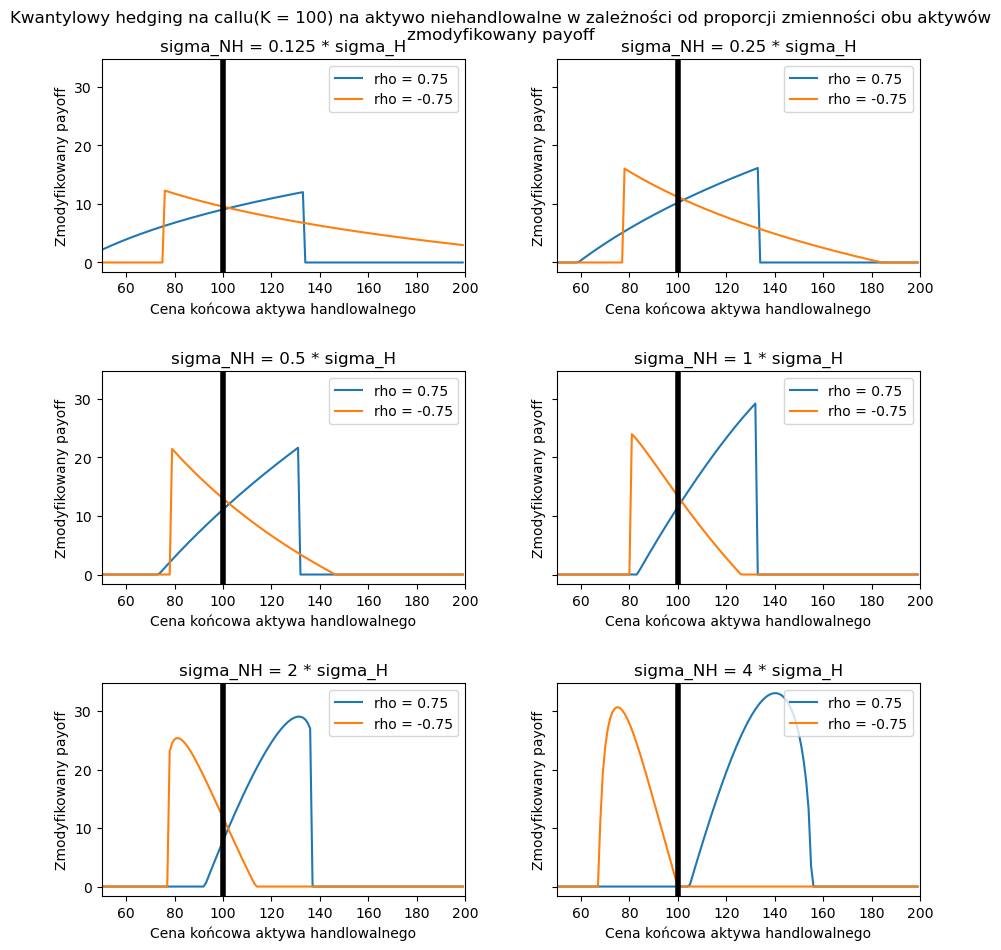

In [116]:
K = 100
rho = 0.75
V0 = BS_call / 2
sigmas_prop = [0.125, 0.25, 0.5, 1, 2, 4]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(3, 2, figsize=(10,10), sharey = True)
fig.tight_layout(pad=5.0)
for num, prop in tqdm(enumerate(sigmas_prop)):
    sims_t = pd.DataFrame(np.ones(150), columns = [0])
    sims_t[1] = np.arange(50, 200) / X0_t
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_t * prop, underlying_t, rho)
    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
    call_nt.set_m(V0, X0_t, X0_nt)
    payoff1 = call_nt.payoff_special((X0_t * sims_t), X0_nt)   
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_t * prop, underlying_t, -rho)
    call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
    call_nt.set_m(V0, X0_t, X0_nt)
    payoff2 = call_nt.payoff_special((X0_t * sims_t), X0_nt)  
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff1, label = f'rho = {rho}')
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff2, label = f'rho = {-rho}')
    axs[num//2, num%2].legend(loc = 'upper right')
    axs[num//2, num%2].set_title(f'sigma_NH = {prop} * sigma_H')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
    axs[num//2, num%2].set_xlim([50,200])
    axs[num//2, num%2].set_xlabel('Cena końcowa aktywa handlowalnego')
    axs[num//2, num%2].set_ylabel('Zmodyfikowany payoff')
plt.subplots_adjust(top=0.93)
plt.suptitle(f'Kwantylowy hedging na callu(K = {K}) na aktywo niehandlowalne w zależności od proporcji zmienności obu aktywów\nzmodyfikowany payoff', size = 12)

Można zauważyć, że im bardziej zmienne jest aktywo niehandlowalne w porównaniu do zabezpieczającego je aktywa handlowalnego tym bardziej "konserwatywny" jest payoff zmodyfikowany. Mówiąc to mamy na myśli fakt, że rośnie on na wartości na niezerowym przedziale oraz staje się coraz bardziej wklęsły. Intuicyjnie owe "wybrzuszenie" stanowi niejako dodatkowy narzut bezpieczeństwa na faktyczny payoff bardziej zmiennego aktywa bazowego. Ze względu na ograniczony kapitał przedziały te wraz z chęcią bycia bardziej konserwatywnym co to samych payoffów węższe.

6it [00:13,  2.30s/it]


Text(0.5, 0.98, 'Kwantylowy hedging na puta(K = 100) na aktywo niehandlowalne w zależności od proporcji zmienności obu aktywów\nzmodyfikowany payoff')

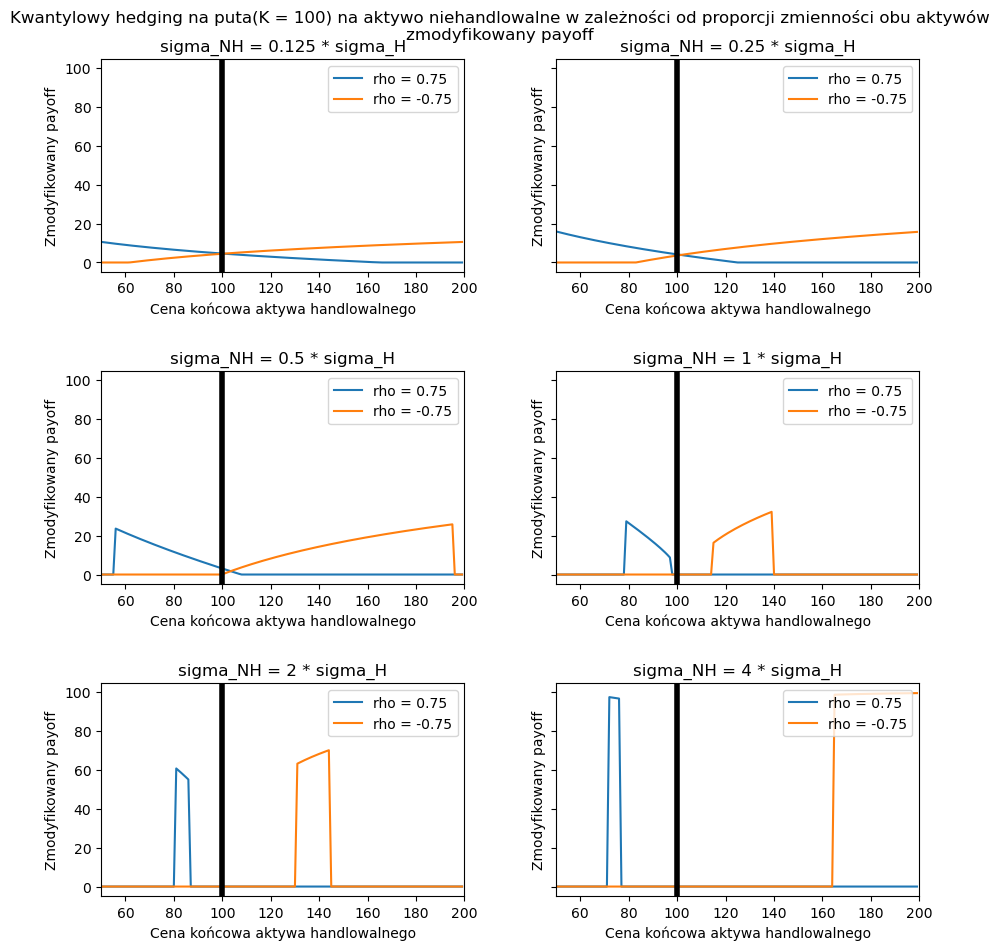

In [117]:
K = 100
rho = 0.75
V0 = BS_put / 2
sigmas_prop = [0.125, 0.25, 0.5, 1, 2, 4]
X = pd.DataFrame(np.arange(0,300))
fig, axs = plt.subplots(3, 2, figsize=(10,10), sharey = True)
fig.tight_layout(pad=5.0)
for num, prop in tqdm(enumerate(sigmas_prop)):
    sims_t = pd.DataFrame(np.ones(150), columns = [0])
    sims_t[1] = np.arange(50, 200) / X0_t
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_t * prop, underlying_t, rho)
    put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)
    put_nt.set_m(V0, X0_t, X0_nt)
    payoff1 = put_nt.payoff_special((X0_t * sims_t), X0_nt)   
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_t * prop, underlying_t, -rho)
    put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)
    put_nt.set_m(V0, X0_t, X0_nt)
    payoff2 = put_nt.payoff_special((X0_t * sims_t), X0_nt)  
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff1, label = f'rho = {rho}')
    axs[num//2, num%2].plot((X0_t * sims_t).iloc[:,-1], payoff2, label = f'rho = {-rho}')
    axs[num//2, num%2].legend(loc = 'upper right')
    axs[num//2, num%2].set_title(f'sigma_NH = {prop} * sigma_H')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
    axs[num//2, num%2].set_xlim([50,200])
    axs[num//2, num%2].set_xlabel('Cena końcowa aktywa handlowalnego')
    axs[num//2, num%2].set_ylabel('Zmodyfikowany payoff')
plt.subplots_adjust(top=0.93)
plt.suptitle(f'Kwantylowy hedging na puta(K = {K}) na aktywo niehandlowalne w zależności od proporcji zmienności obu aktywów\nzmodyfikowany payoff', size = 12)

Opcja pull niesie ze sobą w pewnym stopniu podobną charakterystykę- payoffy rosną co do wartości przez dodatkowy narzut bezpieczeństwa na bardziej zmienne niehandlowalne aktywo.

## II. Optymalizacja drugiej funkcji celu

W tej sekcji skupimy się głównie na zmodyfikowanym payoffie, nie zaprezentujemy niestety wyników samego tradingu na przykładzie symulacji. Wynika to z ciężaru obliczeniowego metody szukania stycznej do funkcji $G$, który nakłada się wielokrotnie w przypadku trade'owania, gdzie cana opcji musi zostać wyliczona każdego dnia dwukrotnie w celu obliczenia $\Delta$. Możliwe, choć nadal stosunkowo czasochłonne jest skonstruowanie jednego pełnego tradingu- nie niesie on jednak informacji, które moglibyśmy przenieść na większą liczbę przypadków. Możliwa jest modyfikacja metody na bardziej optymalną lub postawienie na większą liberalność (choć już plasującą się na dość wysokim poziomie) przyjętych parametrów dokładności obliczeń. W poniższym raporcie na taki krok się jednak nie zdecydowaliśmy.

### Parametry wyjściowe

In [118]:
mu_nt = 0.06
mu_t = 0.06
sigma_nt =  0.3
sigma_t =  0.3
r = 0.05
X0_nt = 100
X0_t = 100
T = 1
K = 100
repeat = 10000
values_per_year = 250

In [119]:
underlying_t = Underlying(mu_t, sigma_t, r, values_per_year)

### Proste *sanity checki* wyznaczanego przez przypadek skrajny payoffu

In [120]:
rho = 0.999999
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)

In [121]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True, 'success_ratio')
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False, 'success_ratio')

In [122]:
call_vanilla = Vanilla(underlying_t, K, T, True)
put_vanilla = Vanilla(underlying_t, K, T, False)

#### Cena opcji w świecie Blacka Scholesa- porównanie

In [123]:
price_MC_nontradable = call_nt.get_MC_price(X0_t, X0_nt)
BS_call = call_vanilla.get_price(X0_t)
print(f'Analitycna cena opcji call:{BS_call:.3f}')
print(f'MC cena opcji na niehandlowalne imitującej zwykłego calla:{price_MC_nontradable:.3f}')
assert abs(price_MC_nontradable - BS_call)/BS_call < 0.1

Analitycna cena opcji call:14.231
MC cena opcji na niehandlowalne imitującej zwykłego calla:14.055


In [124]:
price_MC_nontradable = put_nt.get_MC_price(X0_t, X0_nt)
BS_put = put_vanilla.get_price(X0_t)
print(f'Analitycna cena opcji put:{BS_put:.3f}')
print(f'MC cena opcji na niehandlowalne imitującej zwykłego puta:{price_MC_nontradable:.3f}')
assert abs(price_MC_nontradable - BS_put)/BS_put < 0.1

Analitycna cena opcji put:9.354
MC cena opcji na niehandlowalne imitującej zwykłego puta:9.099


Widzimy, że estymacje ceny opcji na aktywo niehandlowalne w przypadku imitującym opcję waniliową są stosunkowo zbliżone. Potencjalny, mniejszy niż 10% ceny właściwej błąd wynikać może z metody symulacji Monte Carlo. Założony błąd jest tym razem większy ze względu na większą niedokładność obliczeniową definiowania zmodyfikowanego payoffu.

### Analiza różnic pomiędzy zmodyfikowanym payoffem w zależności od tego, która funkcja celu ma być optymalizowana

Poniżej zaprezentujemy porównania zmodyfikowanego payoffu opcji na aktywo niehandlowalne w zależności, czy zależy nam na optymalizacji pierwszej funkcji celu tj. prawdopodobieństwa sukcesu, czy też drugiej (tzw. *success ratio*). Analizy te będą zależne od przyjętej korelacji pomiędzy aktywami, procentu przekazanej do zabezpieczania ceny standardowego odpowiednika opcji, proporcji pomiędzy zmiennością aktywów oraz ceny wykonania.

#### Wrażliwość na cenę wykonania

5it [17:12, 206.40s/it]


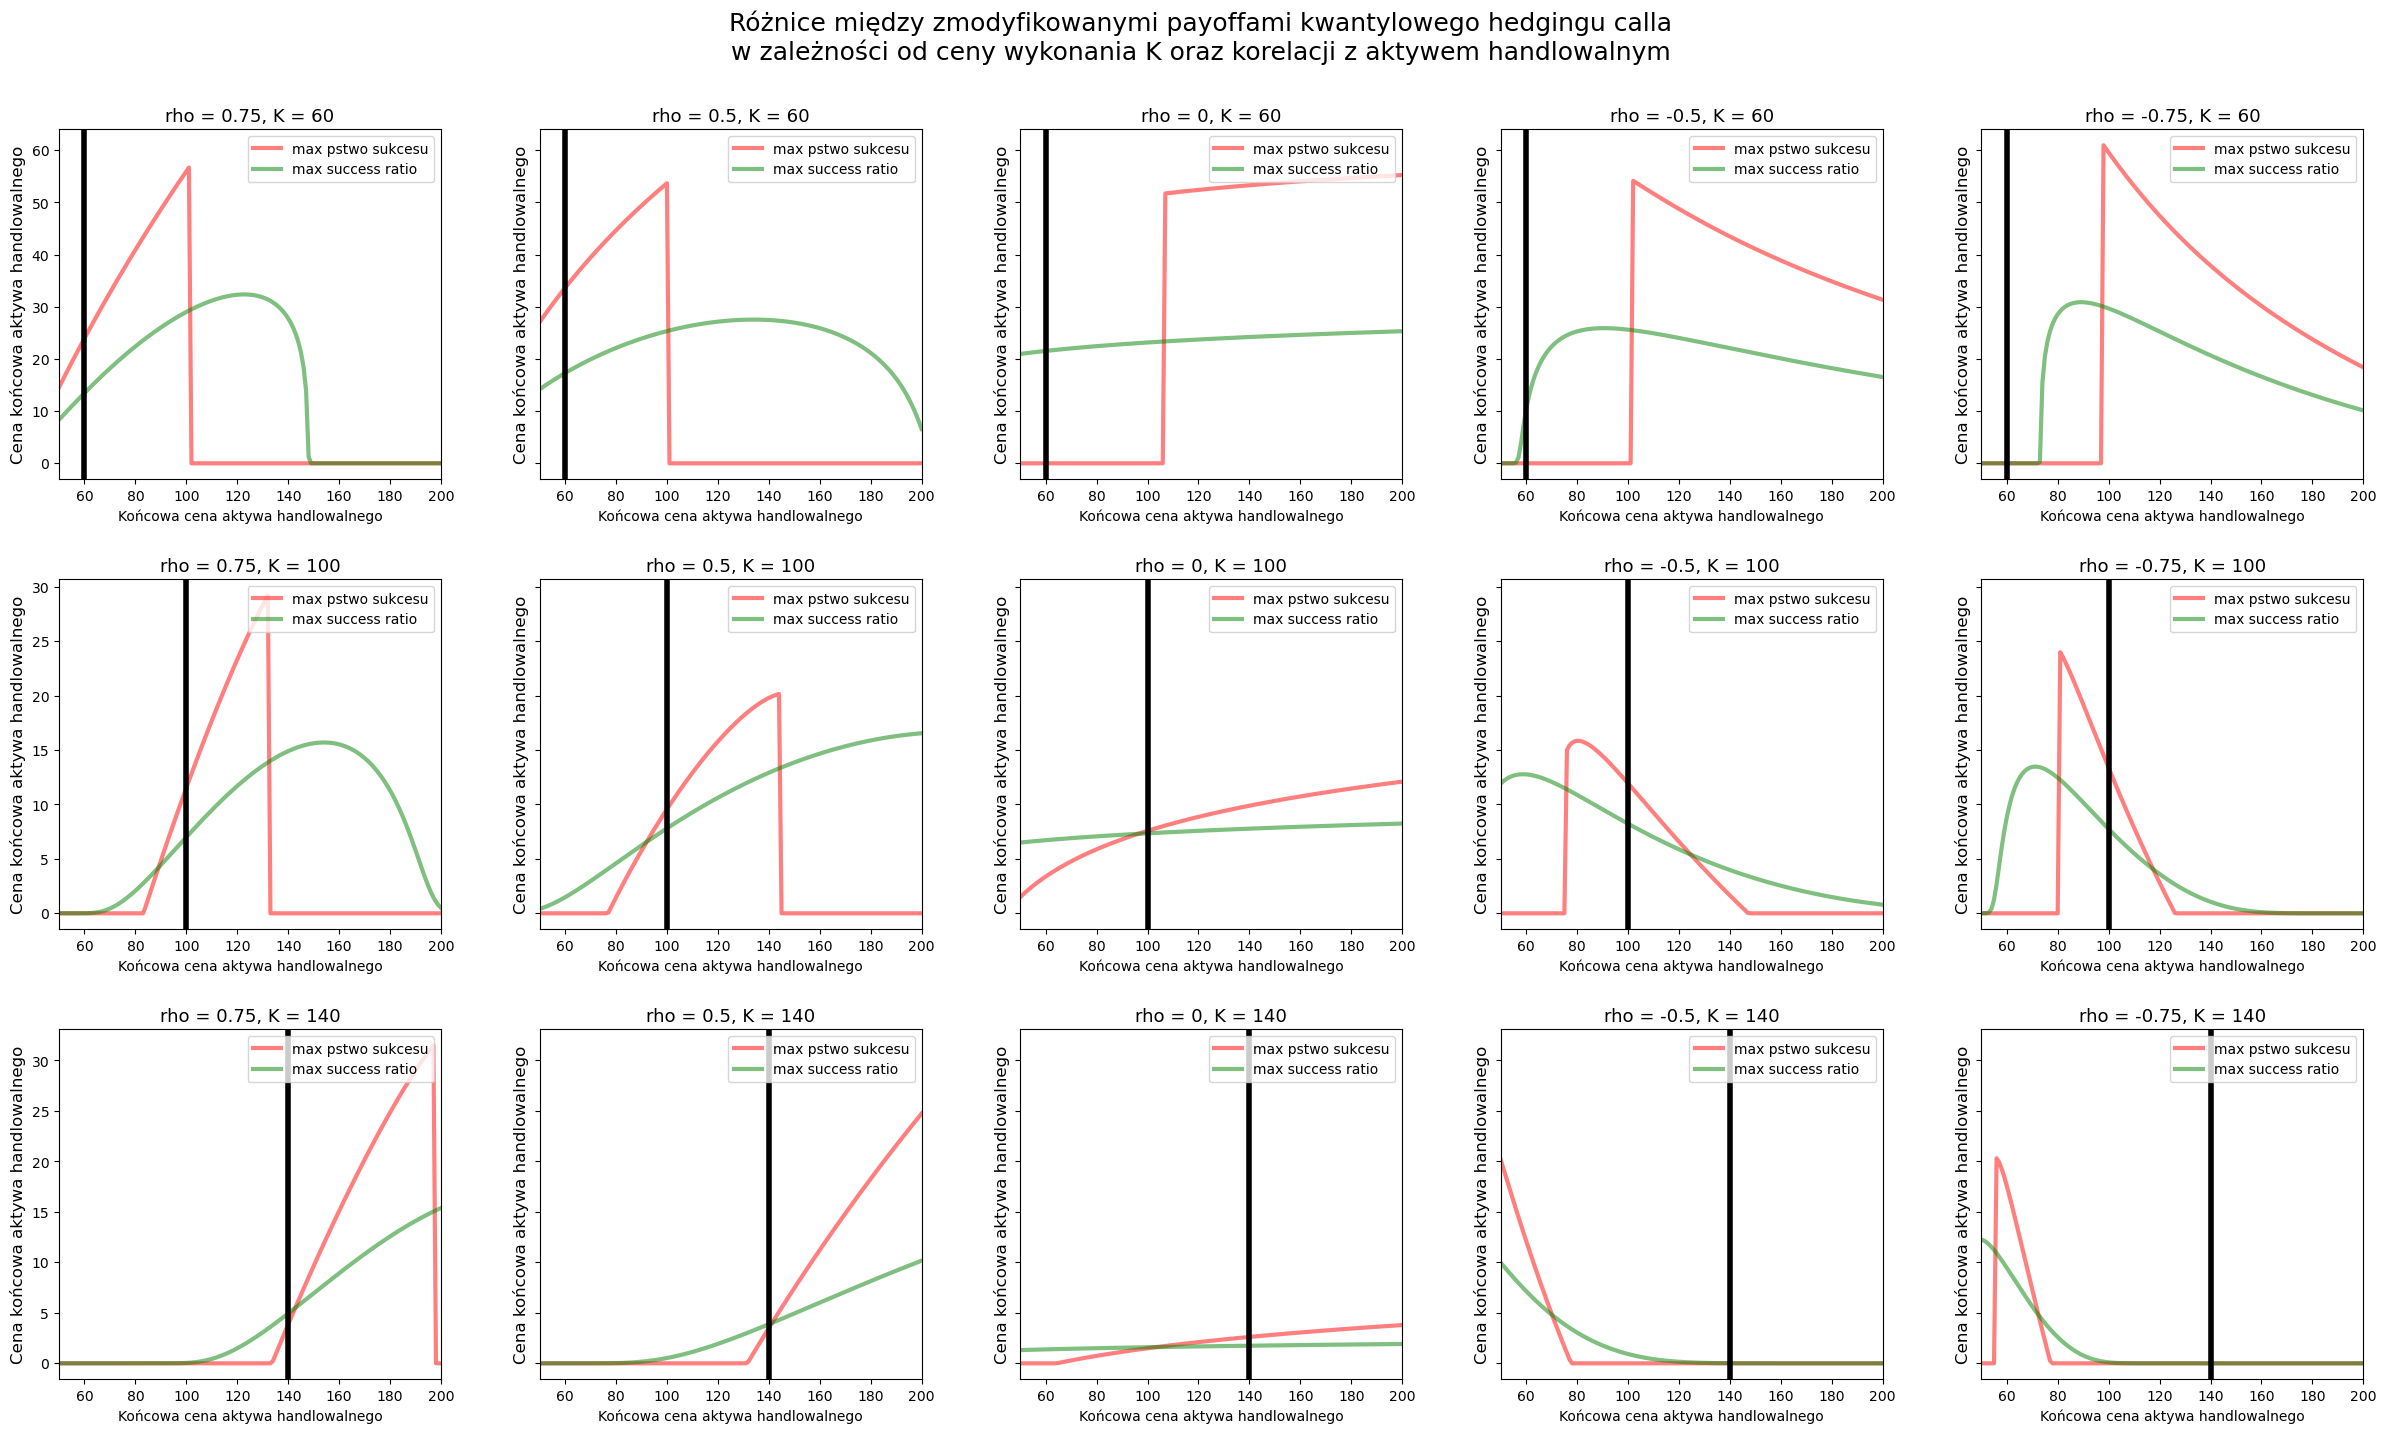

In [137]:
fig, axs = plt.subplots(3,5, figsize = (25, 15), sharey = 'row')
fig.tight_layout(pad=5.5)
plt.suptitle(f'Różnice między zmodyfikowanymi payoffami kwantylowego hedgingu calla\nw zależności od ceny wykonania K oraz korelacji z aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.9)
for idy, rho in tqdm(enumerate([0.75, 0.5, 0, -0.5, -0.75])):
    for idx, K in enumerate([60, 100, 140]):
        underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
        sims_t = pd.DataFrame(np.ones(152), columns = [0])
        sims_t[1] = np.arange(49, 201) / X0_t
        call_nt_sp = Vanilla_on_NonTraded(underlying_nt, K, T, True)
        V0 = Vanilla(underlying_t, K, T, True).get_price(X0_nt) / 2
        call_nt_sp.set_m(V0, X0_t, X0_nt)
        payoff_sp = call_nt_sp.payoff_special((X0_t * sims_t), X0_nt)

        call_nt_sr = Vanilla_on_NonTraded(underlying_nt, K, T, True, 'success_ratio')
        call_nt_sr.set_m(V0, X0_t, X0_nt)
        payoff_sr = call_nt_sr.payoff_special((X0_t * sims_t), X0_nt)

        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sp, lw = 3, alpha = 0.5, color = 'red', label = 'max pstwo sukcesu')
        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sr, lw = 3, alpha = 0.5, color = 'green', label = 'max success ratio')
        axs[idx, idy].legend(loc = 'upper right')
        axs[idx, idy].set_title(f'rho = {rho}, K = {K}', fontsize = 13)
        axs[idx, idy].set_xlim([50, 200])    
        axs[idx, idy].axvline(K, color = 'black', lw = 4)
        axs[idx, idy].set_xlabel('Końcowa cena aktywa handlowalnego')
        axs[idx, idy].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[idx, idy].set_ylabel('Cena końcowa aktywa handlowalnego', fontsize = 12)    

W przypadku opcji call pierwszą narzucającą się obserwacją jest to, że zmodyfikowany payoff w przypadku optymalizacji *success ratio* jest funkcją zdecydowanie bardziej "gładszą" i w konsekwencji obejmującą większy zakres symulacji. Jednocześnie- ze względu na ograniczony kapitał początkowy payoff ten sięga wartości niższych. Możemy to interpretować jako próbę conajmniej częściowego zabezpieczenia większego zakresu symulacji. Wynika to z formy drugiej funkcji celu, która maksymalizuje także stosunek końcowego stanu portfela przed wypłaceniem payoffu faktycznego do tego właśnie payoffu w przypadku scenariuszy, na które nie byliśmy w pełni przygotowani. Wraz ze wzrostem ceny wykonania oba przypadki payoffów dla aktywa handlowalnego przesuwają swoją masę w prawo kiedy korelacja jest dodatnia oraz w lewo w przypadku przeciwnym.

5it [15:23, 184.63s/it]


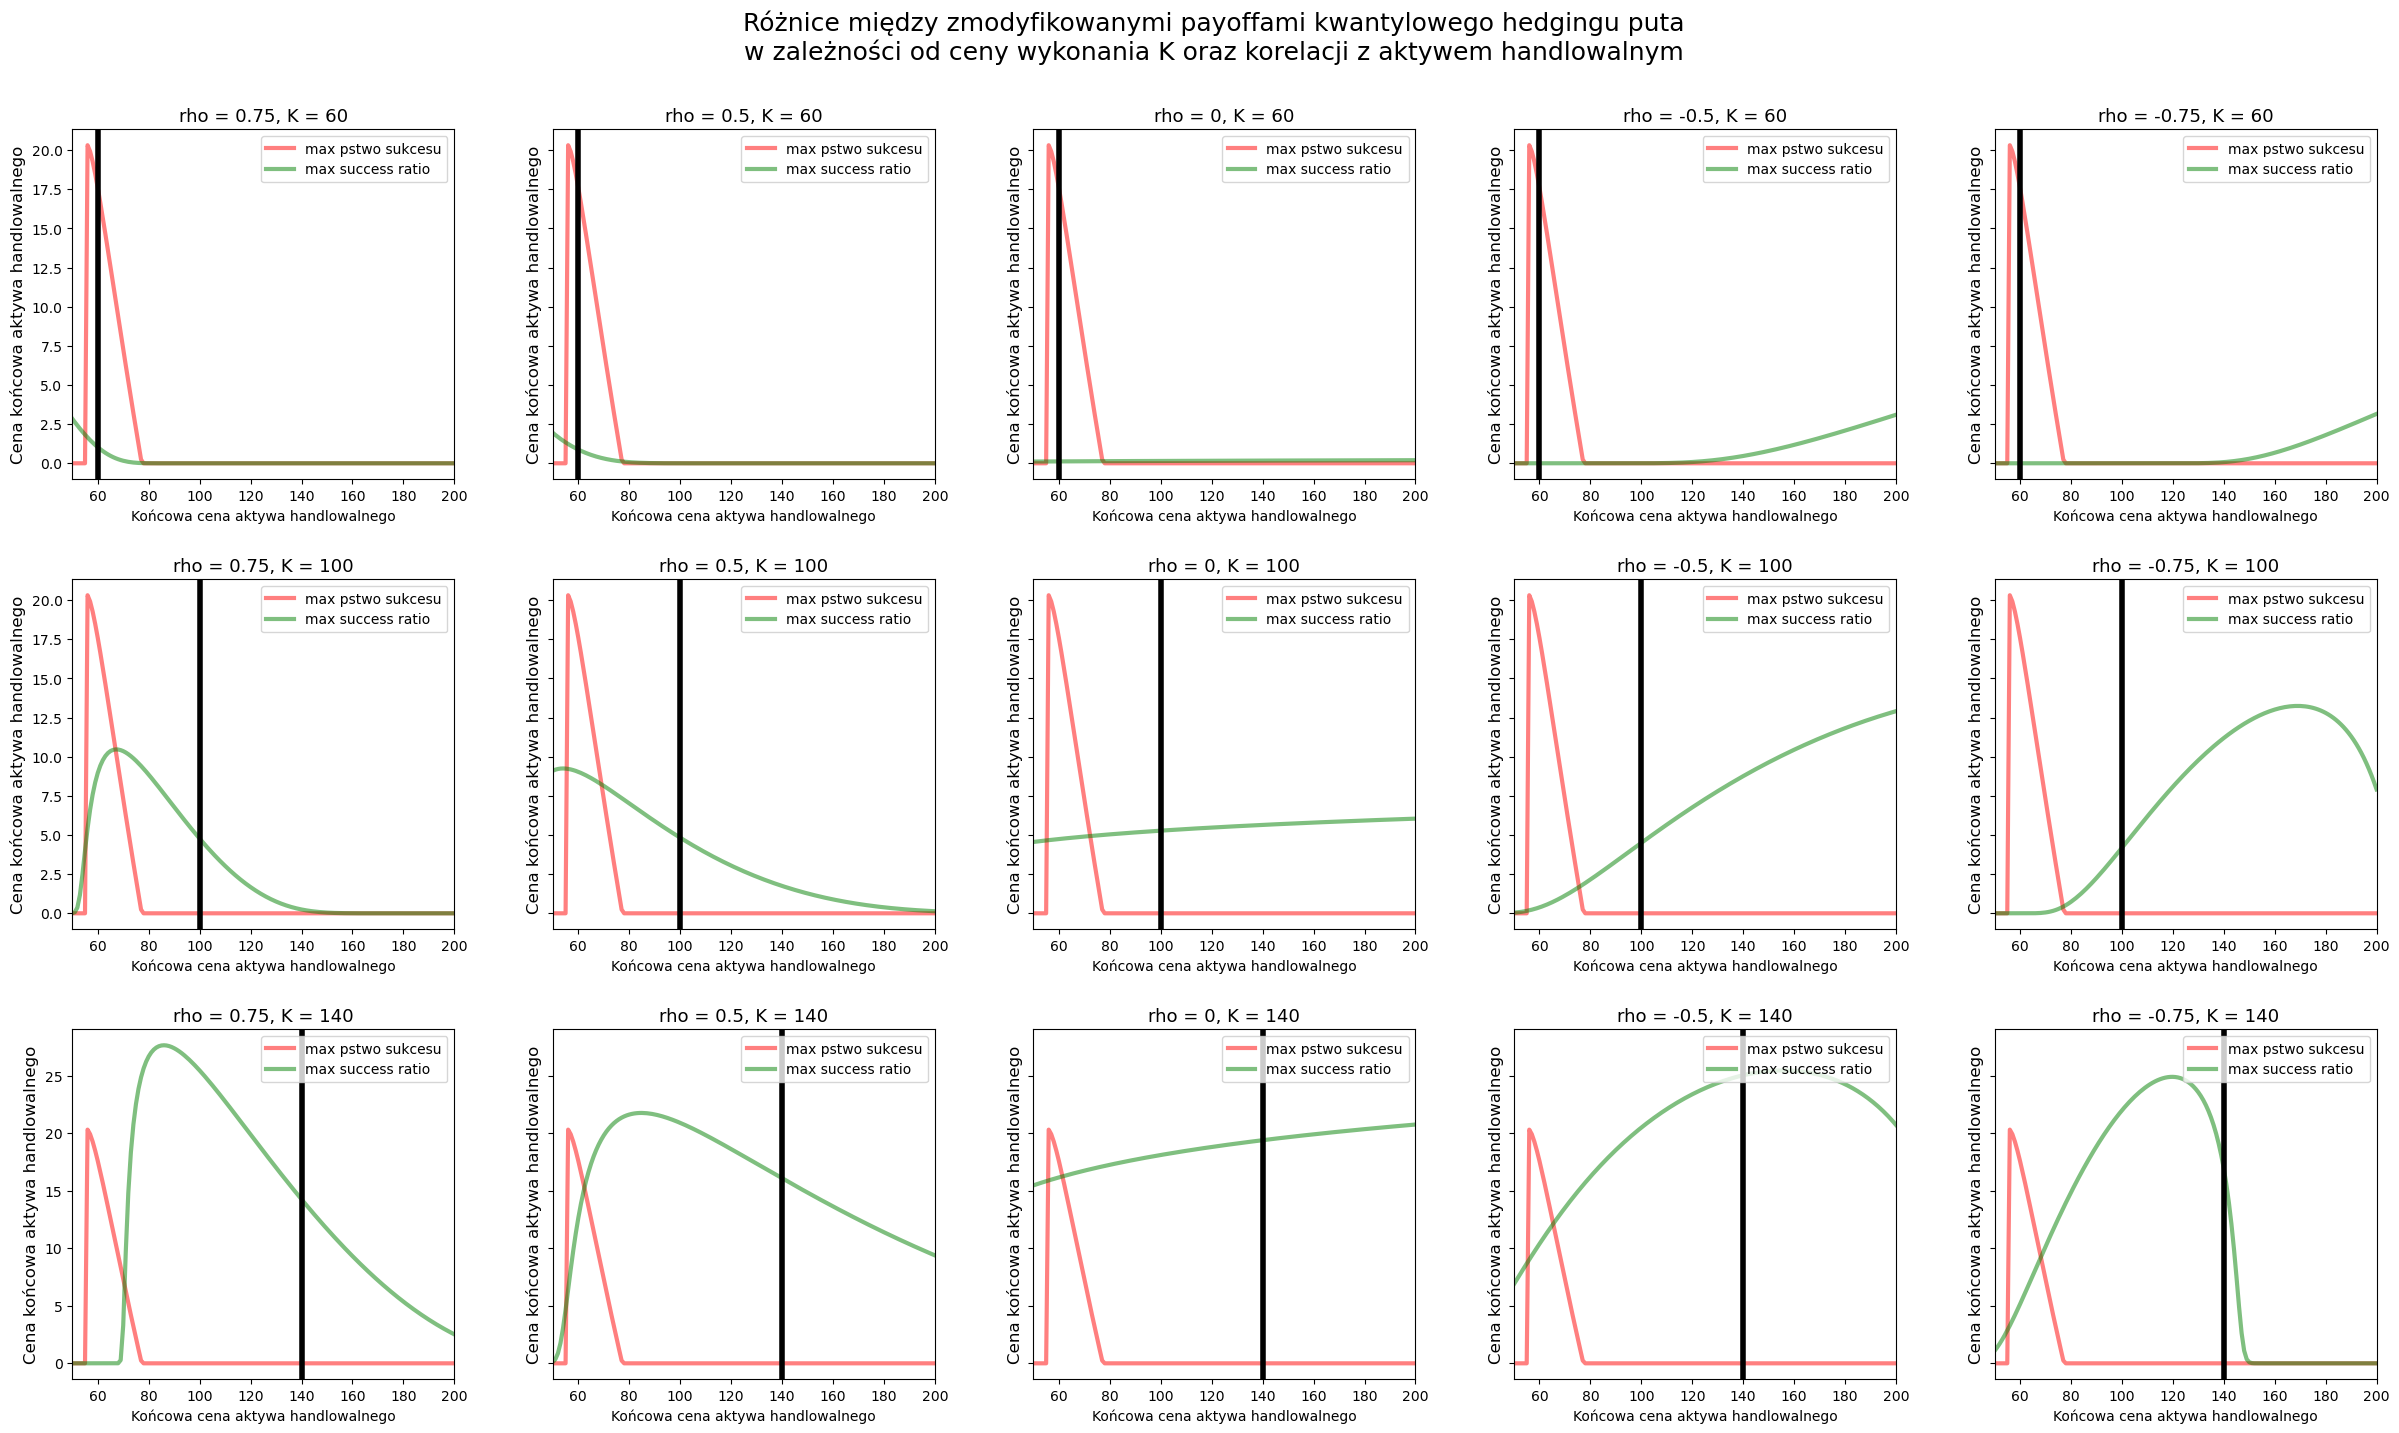

In [139]:
fig, axs = plt.subplots(3,5, figsize = (25, 15), sharey = 'row')
fig.tight_layout(pad=5.5)
plt.suptitle(f'Różnice między zmodyfikowanymi payoffami kwantylowego hedgingu puta\nw zależności od ceny wykonania K oraz korelacji z aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.9)
V0 = BS_put / 2
for idy, rho in tqdm(enumerate([0.75, 0.5, 0, -0.5, -0.75])):
    for idx, K in enumerate([60, 100, 140]):
        underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
        sims_t = pd.DataFrame(np.ones(152), columns = [0])
        sims_t[1] = np.arange(49, 201) / X0_t
        put_nt_sp = Vanilla_on_NonTraded(underlying_nt, K, T, False)
        V0 = Vanilla(underlying_t, K, T, False).get_price(X0_nt) / 2
        put_nt_sp.set_m(V0, X0_t, X0_nt)
        put_sp = put_nt_sp.payoff_special((X0_t * sims_t), X0_nt)

        put_nt_sr = Vanilla_on_NonTraded(underlying_nt, K, T, False, 'success_ratio')
        put_nt_sr.set_m(V0, X0_t, X0_nt)
        payoff_sr = put_nt_sr.payoff_special((X0_t * sims_t), X0_nt)

        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sp, lw = 3, alpha = 0.5, color = 'red', label = 'max pstwo sukcesu')
        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sr, lw = 3, alpha = 0.5, color = 'green', label = 'max success ratio')
        axs[idx, idy].legend(loc = 'upper right')
        axs[idx, idy].set_title(f'rho = {rho}, K = {K}', fontsize = 13)
        axs[idx, idy].set_xlim([50, 200])    
        axs[idx, idy].axvline(K, color = 'black', lw = 4)
        axs[idx, idy].set_xlabel('Końcowa cena aktywa handlowalnego')
        axs[idx, idy].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[idx, idy].set_ylabel('Cena końcowa aktywa handlowalnego', fontsize = 12)    

Zmodyfikowane payoffy dla opcji put są analogicznie od siebie zależne, co dla opcji call. Tym razem wraz ze wzrostem ceny wykonania payoffy te przesuwają masę ku wartościom mniejszym kiedy korelacja jest dodatnia lub większym w przypadku $\rho <0$. Kiedy aktywa są nieskorelowane payoffy "próbują" zabezpieczyć się na losowość aktywa niehandlowalnego- nie ma tu tak dużej zależności od ceny wykonania $K$.

#### Wrażliwość na procent ceny analogicznej opcji waniliowej użyty do zabezpieczania

5it [22:55, 275.07s/it]


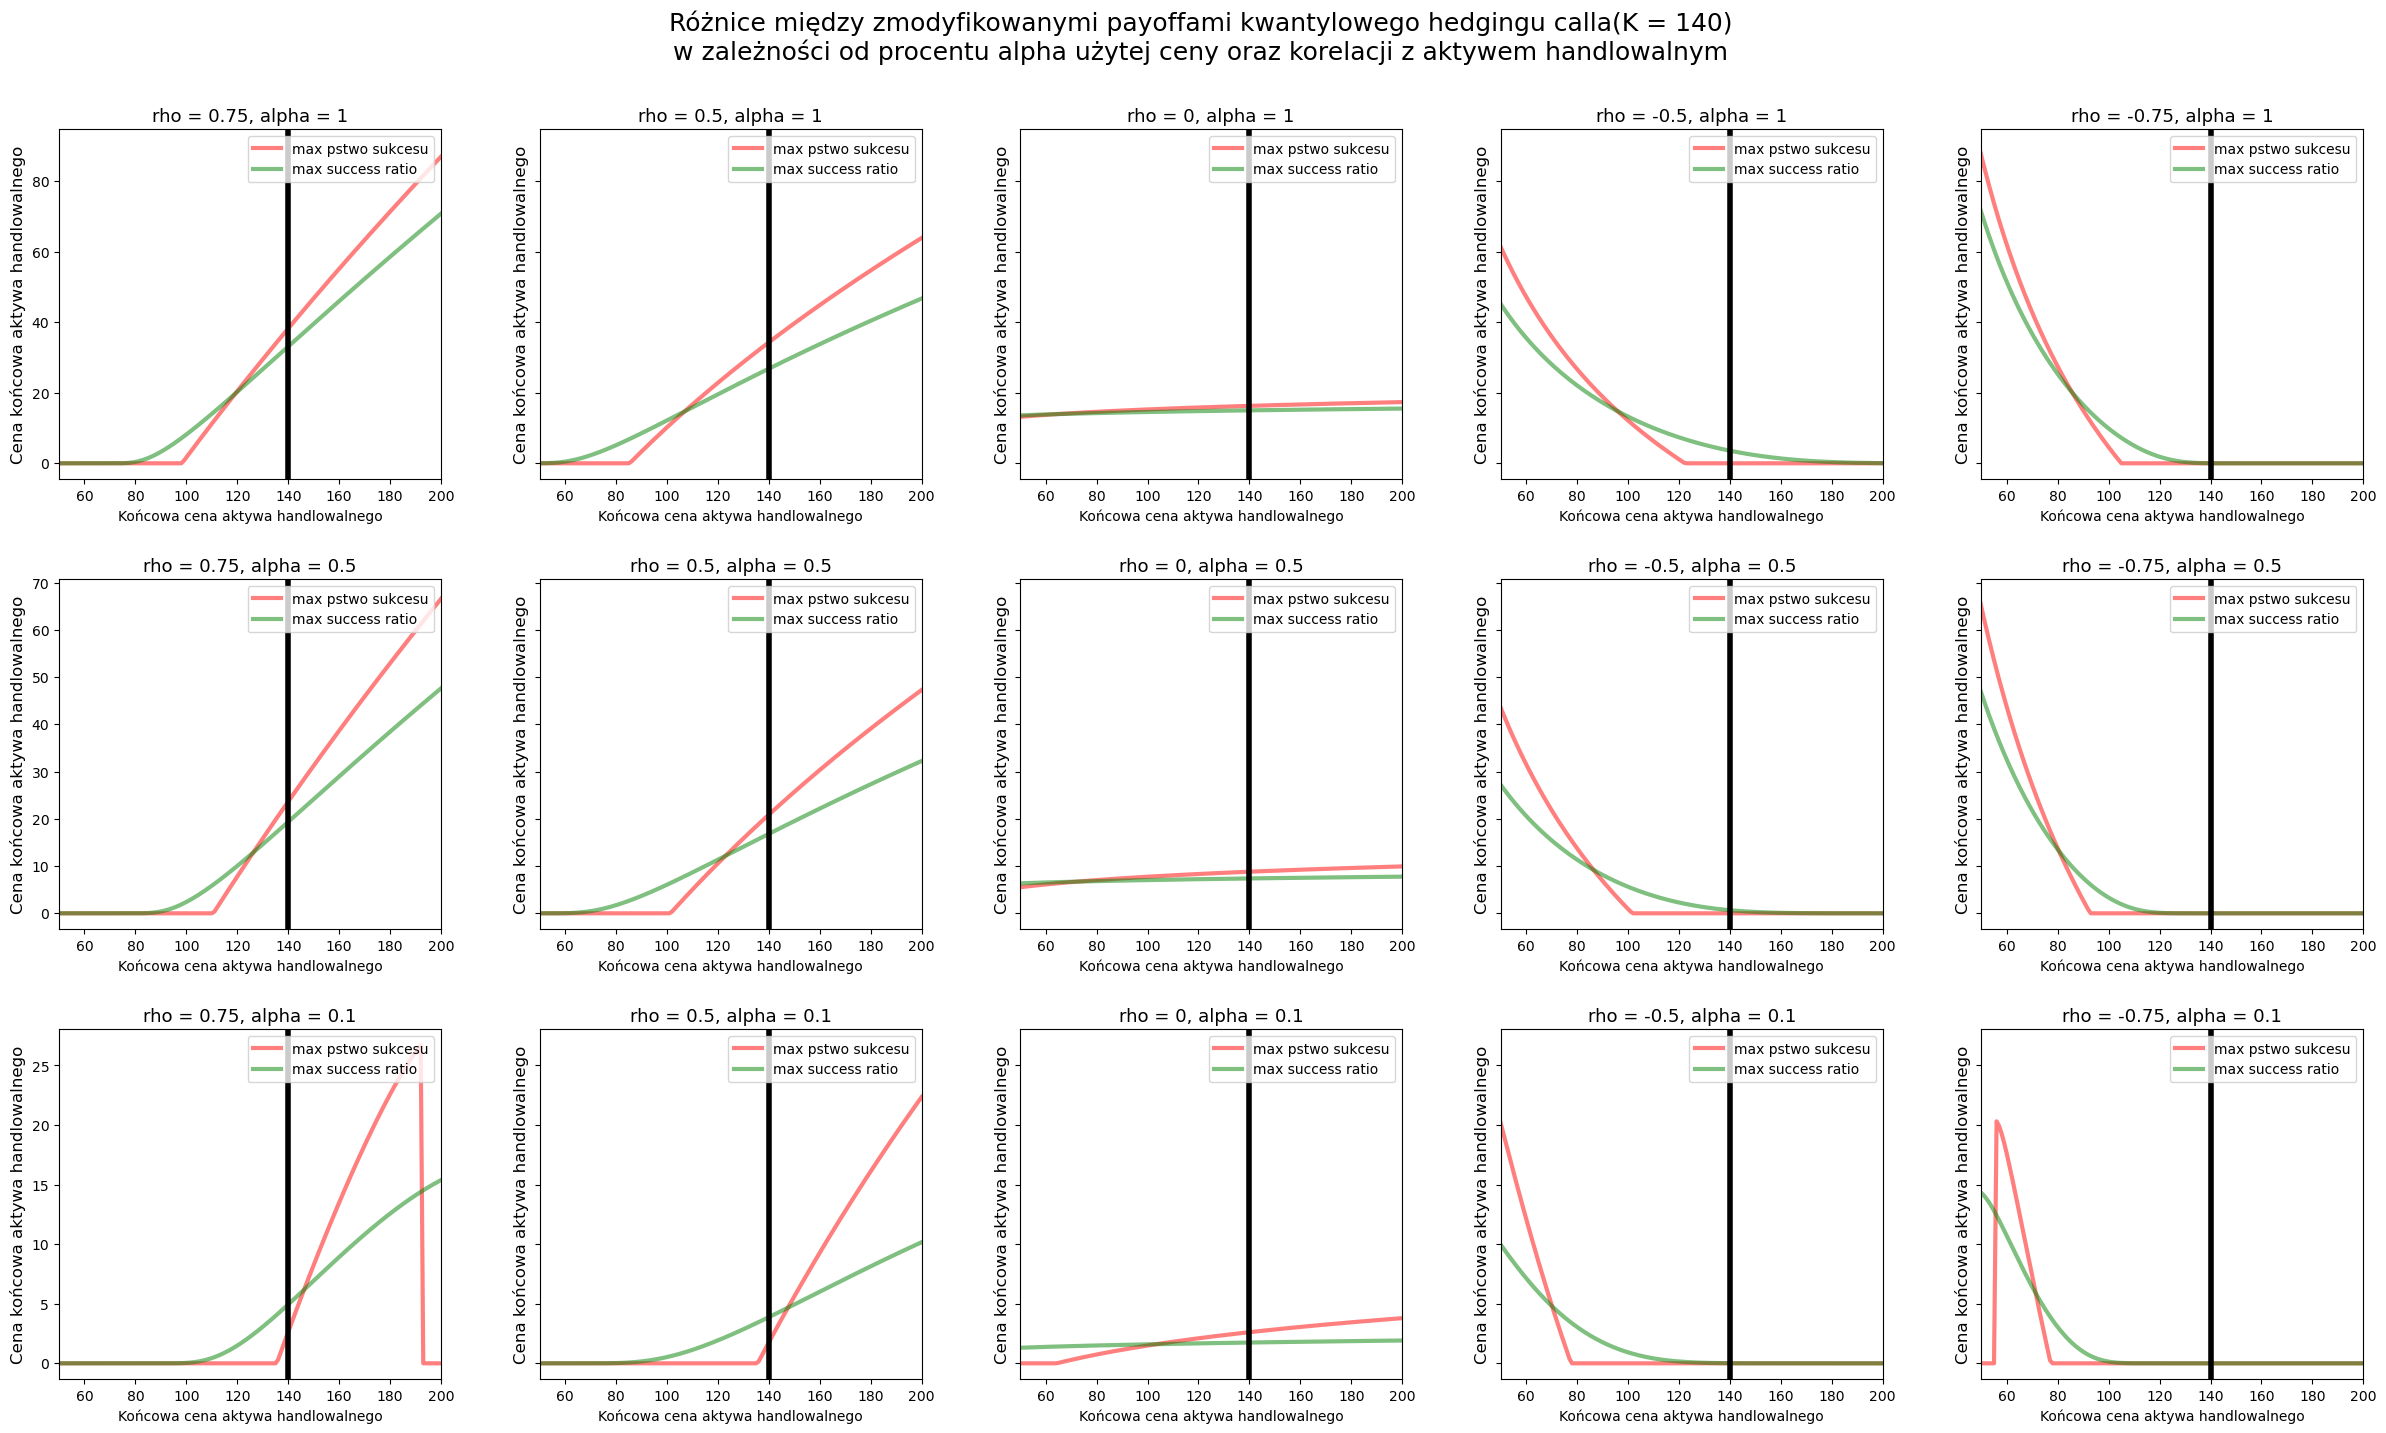

In [131]:
fig, axs = plt.subplots(3,5, figsize = (25, 15), sharey = 'row')
fig.tight_layout(pad=5.5)
plt.suptitle(f'Różnice między zmodyfikowanymi payoffami kwantylowego hedgingu calla(K = {K})\nw zależności od procentu alpha użytej ceny oraz korelacji z aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.9)
V0 = BS_call
for idy, rho in tqdm(enumerate([0.75, 0.5, 0, -0.5, -0.75])):
    for idx, alpha in enumerate([1, 0.5, 0.1]):
        underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
        sims_t = pd.DataFrame(np.ones(152), columns = [0])
        sims_t[1] = np.arange(49, 201) / X0_t
        call_nt_sp = Vanilla_on_NonTraded(underlying_nt, K, T, True)
        call_nt_sp.set_m(alpha * V0, X0_t, X0_nt)
        payoff_sp = call_nt_sp.payoff_special((X0_t * sims_t), X0_nt)

        call_nt_sr = Vanilla_on_NonTraded(underlying_nt, K, T, True, 'success_ratio')
        call_nt_sr.set_m(alpha * V0, X0_t, X0_nt)
        payoff_sr = call_nt_sr.payoff_special((X0_t * sims_t), X0_nt)

        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sp, lw = 3, alpha = 0.5, color = 'red', label = 'max pstwo sukcesu')
        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sr, lw = 3, alpha = 0.5, color = 'green', label = 'max success ratio')
        axs[idx, idy].legend(loc = 'upper right')
        axs[idx, idy].set_title(f'rho = {rho}, alpha = {alpha}', fontsize = 13)
        axs[idx, idy].set_xlim([50, 200])    
        axs[idx, idy].axvline(K, color = 'black', lw = 4)
        axs[idx, idy].set_xlabel('Końcowa cena aktywa handlowalnego')
        axs[idx, idy].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[idx, idy].set_ylabel('Cena końcowa aktywa handlowalnego', fontsize = 12)    

Zauważmy, że w przypadku gdy kapitał początkowy jest większy wykresy zmodyfikowanego payoffu dla obu funkcji celu są stosunkowo podobne. P-stwo sukcesu stanowiące jeden składnik *success ratio* dominuje tutaj i drugi składnik związany ze scenariuszami niezabezpieczonymi nie modyfikuje znacznie payoffu. Zmienia się to wraz ze spadkiem procentu użytej do hedgingu ceny standardowej wersji rozważanej opcji. Podczas gdy payoff zmodyfikowany dla prawdopodobieństwa sukcesu w przypadkach niezerowej korelacji po prostu "zwęża się", na coraz mniejszy przedział- payoff dla *success ratio* rozszerza się na coraz więcej przypadków scenariuszy, których pierwszy nie był w stanie zabezpieczyć. 

5it [19:21, 232.24s/it]


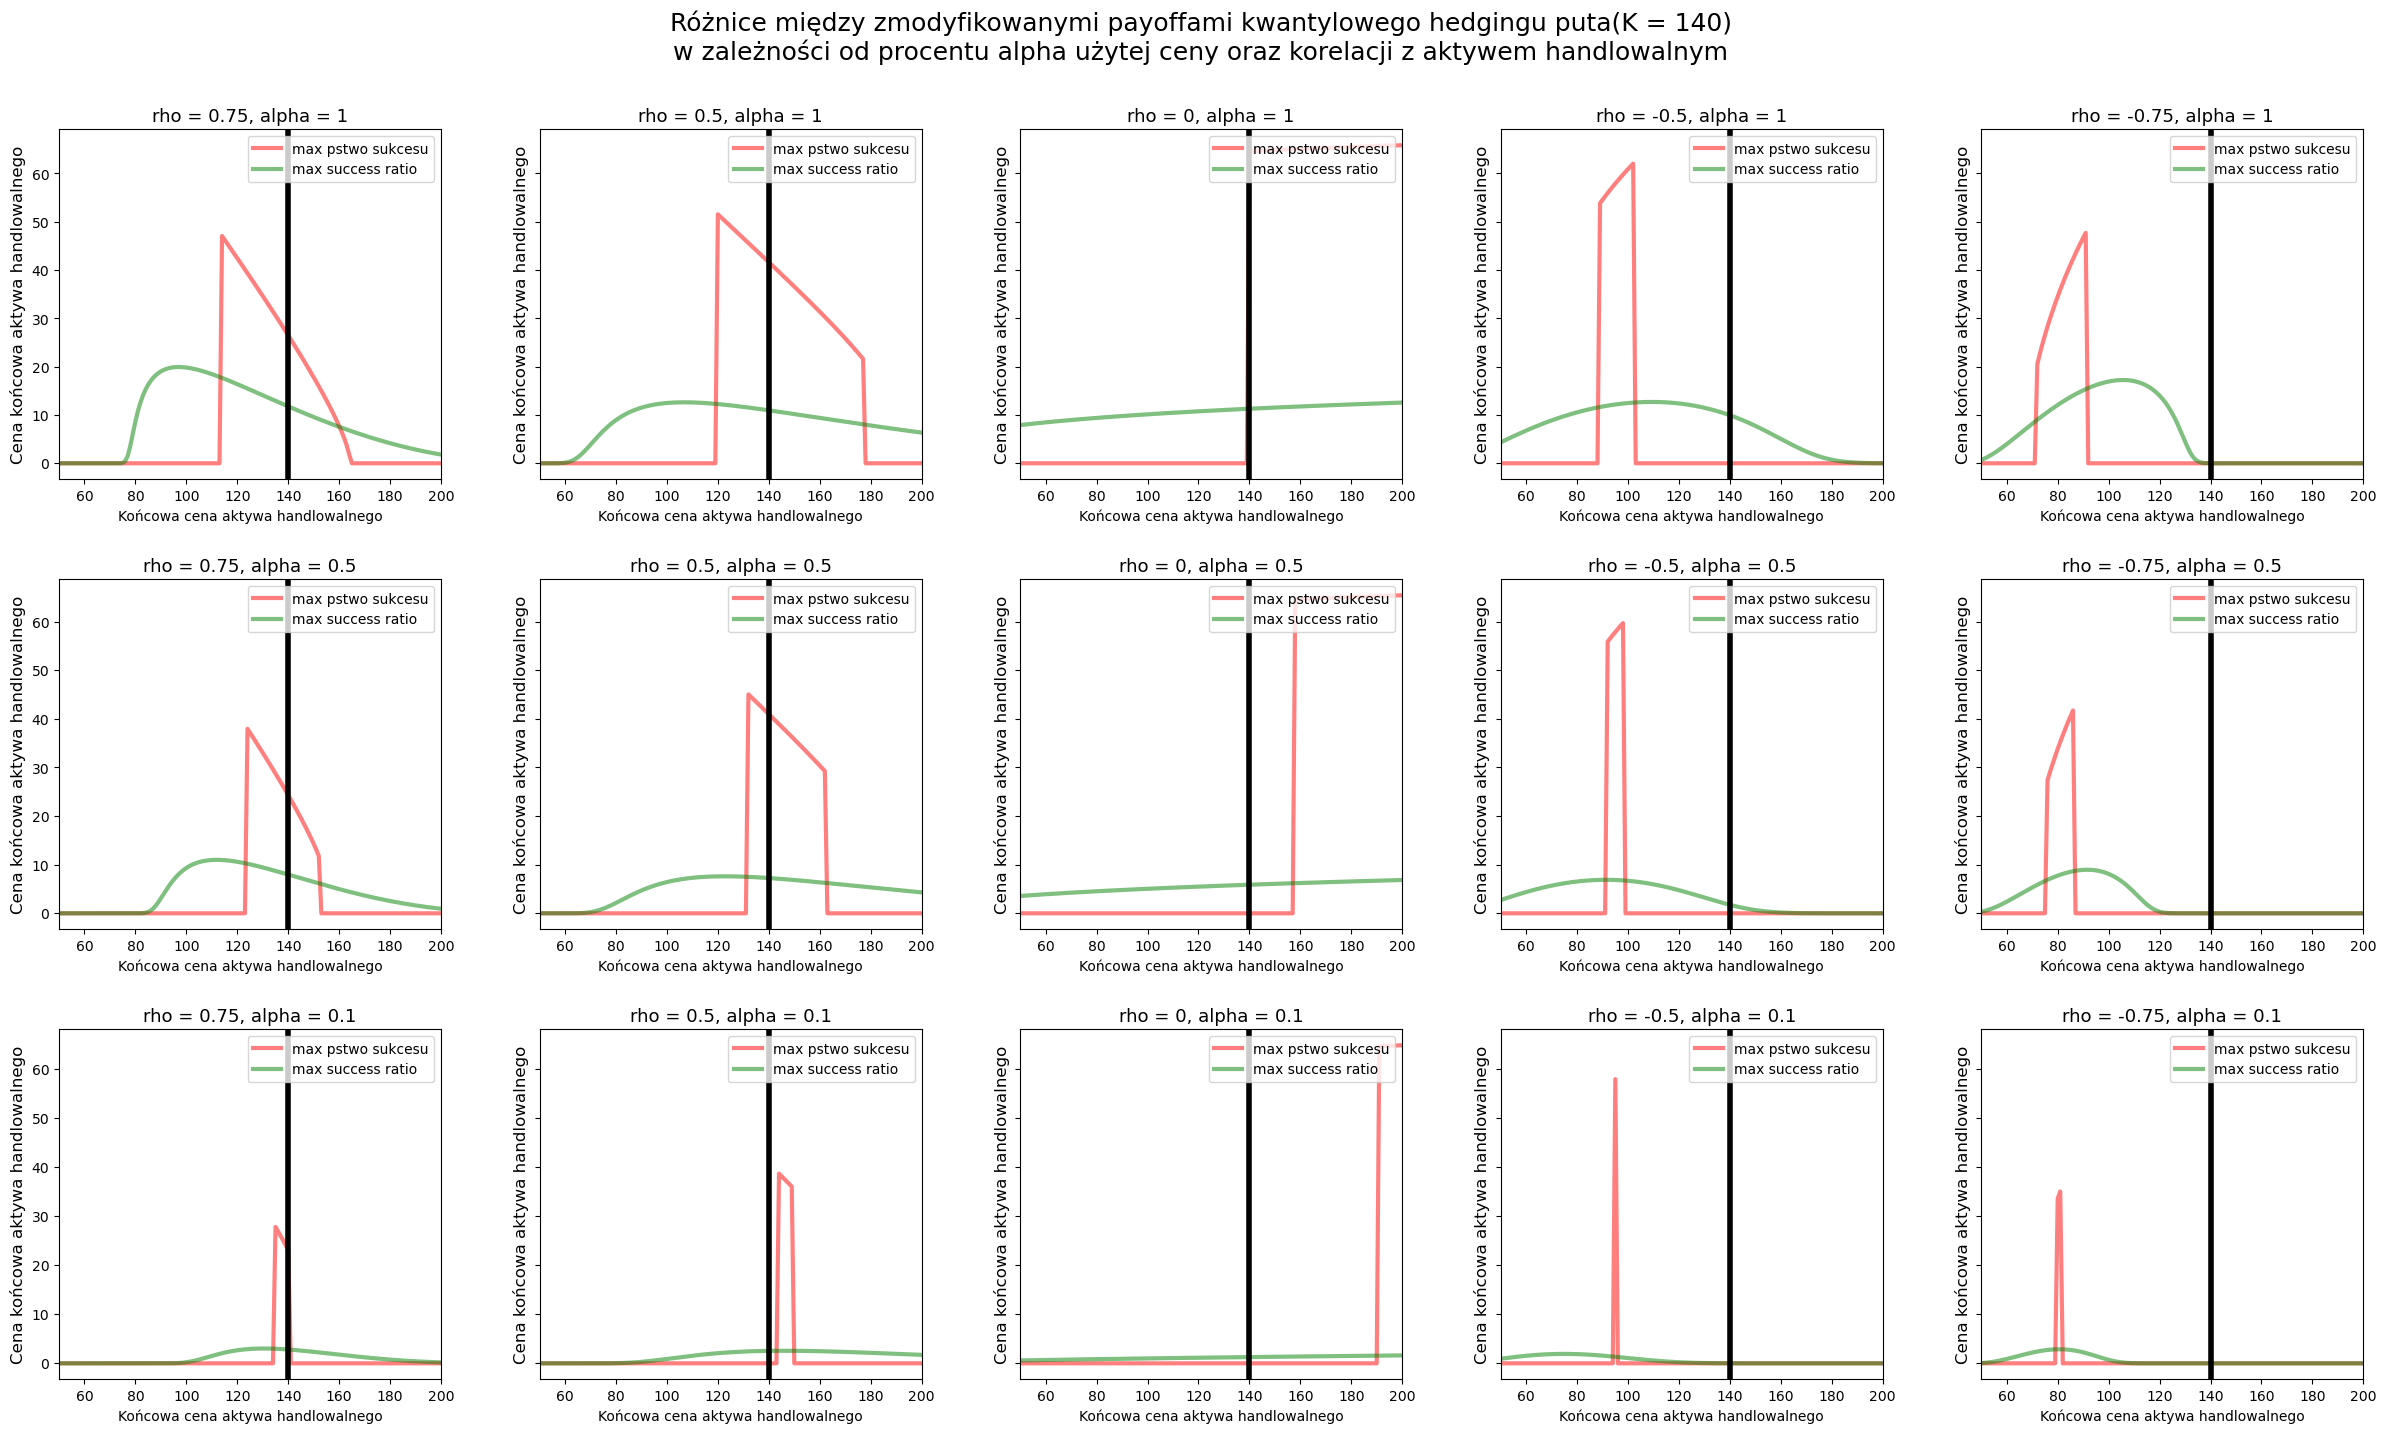

In [132]:
fig, axs = plt.subplots(3,5, figsize = (25, 15), sharey = 'row')
fig.tight_layout(pad=5.5)
plt.suptitle(f'Różnice między zmodyfikowanymi payoffami kwantylowego hedgingu puta(K = {K})\nw zależności od procentu alpha użytej ceny oraz korelacji z aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.9)
V0 = BS_put
for idy, rho in tqdm(enumerate([0.75, 0.5, 0, -0.5, -0.75])):
    for idx, alpha in enumerate([1, 0.5, 0.1]):
        underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
        sims_t = pd.DataFrame(np.ones(152), columns = [0])
        sims_t[1] = np.arange(49, 201) / X0_t
        put_nt_sp = Vanilla_on_NonTraded(underlying_nt, K, T, False)
        put_nt_sp.set_m(alpha * V0, X0_t, X0_nt)
        payoff_sp = put_nt_sp.payoff_special((X0_t * sims_t), X0_nt)

        put_nt_sr = Vanilla_on_NonTraded(underlying_nt, K, T, False, 'success_ratio')
        put_nt_sr.set_m(alpha * V0, X0_t, X0_nt)
        payoff_sr = put_nt_sr.payoff_special((X0_t * sims_t), X0_nt)

        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sp, lw = 3, alpha = 0.5, color = 'red', label = 'max pstwo sukcesu')
        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sr, lw = 3, alpha = 0.5, color = 'green', label = 'max success ratio')
        axs[idx, idy].legend(loc = 'upper right')
        axs[idx, idy].set_title(f'rho = {rho}, alpha = {alpha}', fontsize = 13)
        axs[idx, idy].set_xlim([50, 200])    
        axs[idx, idy].axvline(K, color = 'black', lw = 4)
        axs[idx, idy].set_xlabel('Końcowa cena aktywa handlowalnego')
        axs[idx, idy].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[idx, idy].set_ylabel('Cena końcowa aktywa handlowalnego', fontsize = 12)    

Wnioski w przypadku opcji put są zbliżone- payoff zaznaczony tu kolorem zielony próbuje sięgnąć dużo większej liczby scenariuszy zmniejszając jednocześnie oczekiwany od nich payoff.

#### Wrażliwość na zmienności obu aktywów

5it [12:20, 148.18s/it]


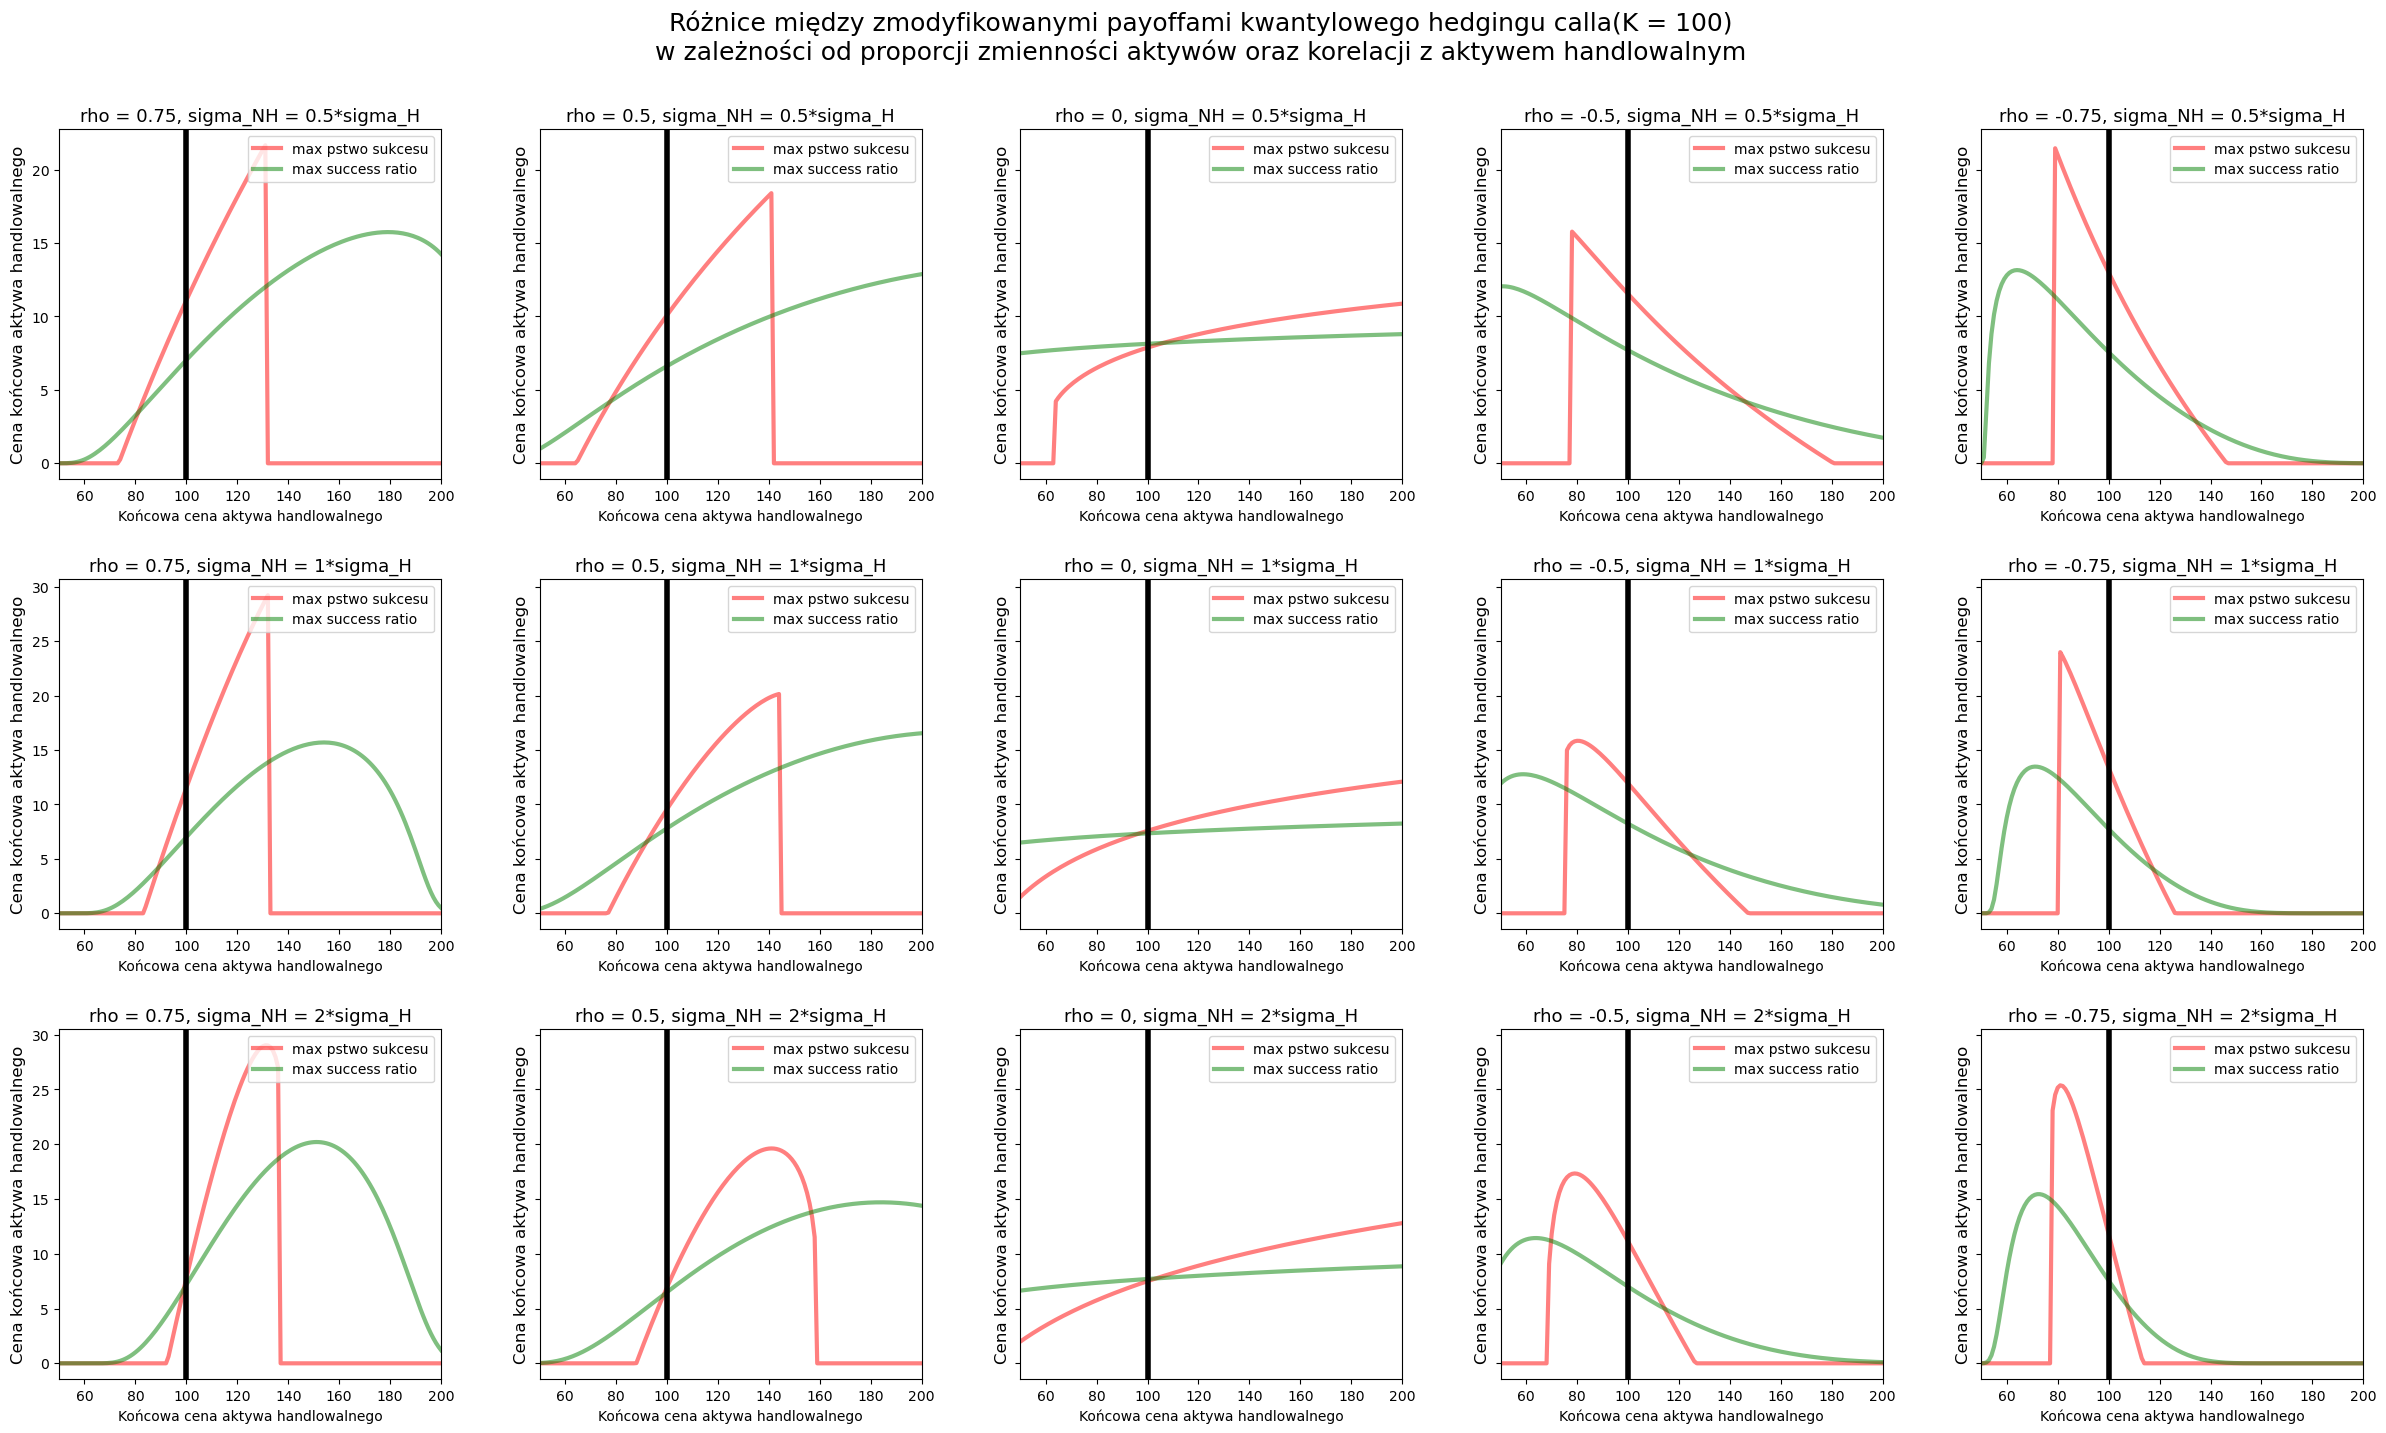

In [133]:
fig, axs = plt.subplots(3,5, figsize = (25, 15), sharey = 'row')
fig.tight_layout(pad=5.5)
K = 100
plt.suptitle(f'Różnice między zmodyfikowanymi payoffami kwantylowego hedgingu calla(K = {K})\nw zależności od proporcji zmienności aktywów oraz korelacji z aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.9)
V0 = BS_call / 2
for idy, rho in tqdm(enumerate([0.75, 0.5, 0, -0.5, -0.75])):
    for idx, prop in enumerate([1/2, 1, 2]):
        underlying_nt = NonTradedUnderlying(mu_nt, prop * sigma_t, underlying_t, rho)
        sims_t = pd.DataFrame(np.ones(152), columns = [0])
        sims_t[1] = np.arange(49, 201) / X0_t
        call_nt_sp = Vanilla_on_NonTraded(underlying_nt, K, T, True)
        call_nt_sp.set_m(V0, X0_t, X0_nt)
        payoff_sp = call_nt_sp.payoff_special((X0_t * sims_t), X0_nt)

        call_nt_sr = Vanilla_on_NonTraded(underlying_nt, K, T, True, 'success_ratio')
        call_nt_sr.set_m(V0, X0_t, X0_nt)
        payoff_sr = call_nt_sr.payoff_special((X0_t * sims_t), X0_nt)

        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sp, lw = 3, alpha = 0.5, color = 'red', label = 'max pstwo sukcesu')
        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sr, lw = 3, alpha = 0.5, color = 'green', label = 'max success ratio')
        axs[idx, idy].legend(loc = 'upper right')
        axs[idx, idy].set_title(f'rho = {rho}, sigma_NH = {prop}*sigma_H', fontsize = 13)
        axs[idx, idy].set_xlim([50, 200])   
        axs[idx, idy].axvline(K, color = 'black', lw = 4)
        axs[idx, idy].set_xlabel('Końcowa cena aktywa handlowalnego')
        axs[idx, idy].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[idx, idy].set_ylabel('Cena końcowa aktywa handlowalnego', fontsize = 12)    

W przypadku optymalizacji obu funkcji celu wzrost w zmienności aktywa niehandlowalnego skutkuje w większej wklęsłości zmodyfikowanych payoffów. Jest to widoczne bardziej w przypadku payoffów, dla maksymalizacji prawdopodobieństwa sukcesu.

5it [12:01, 144.24s/it]


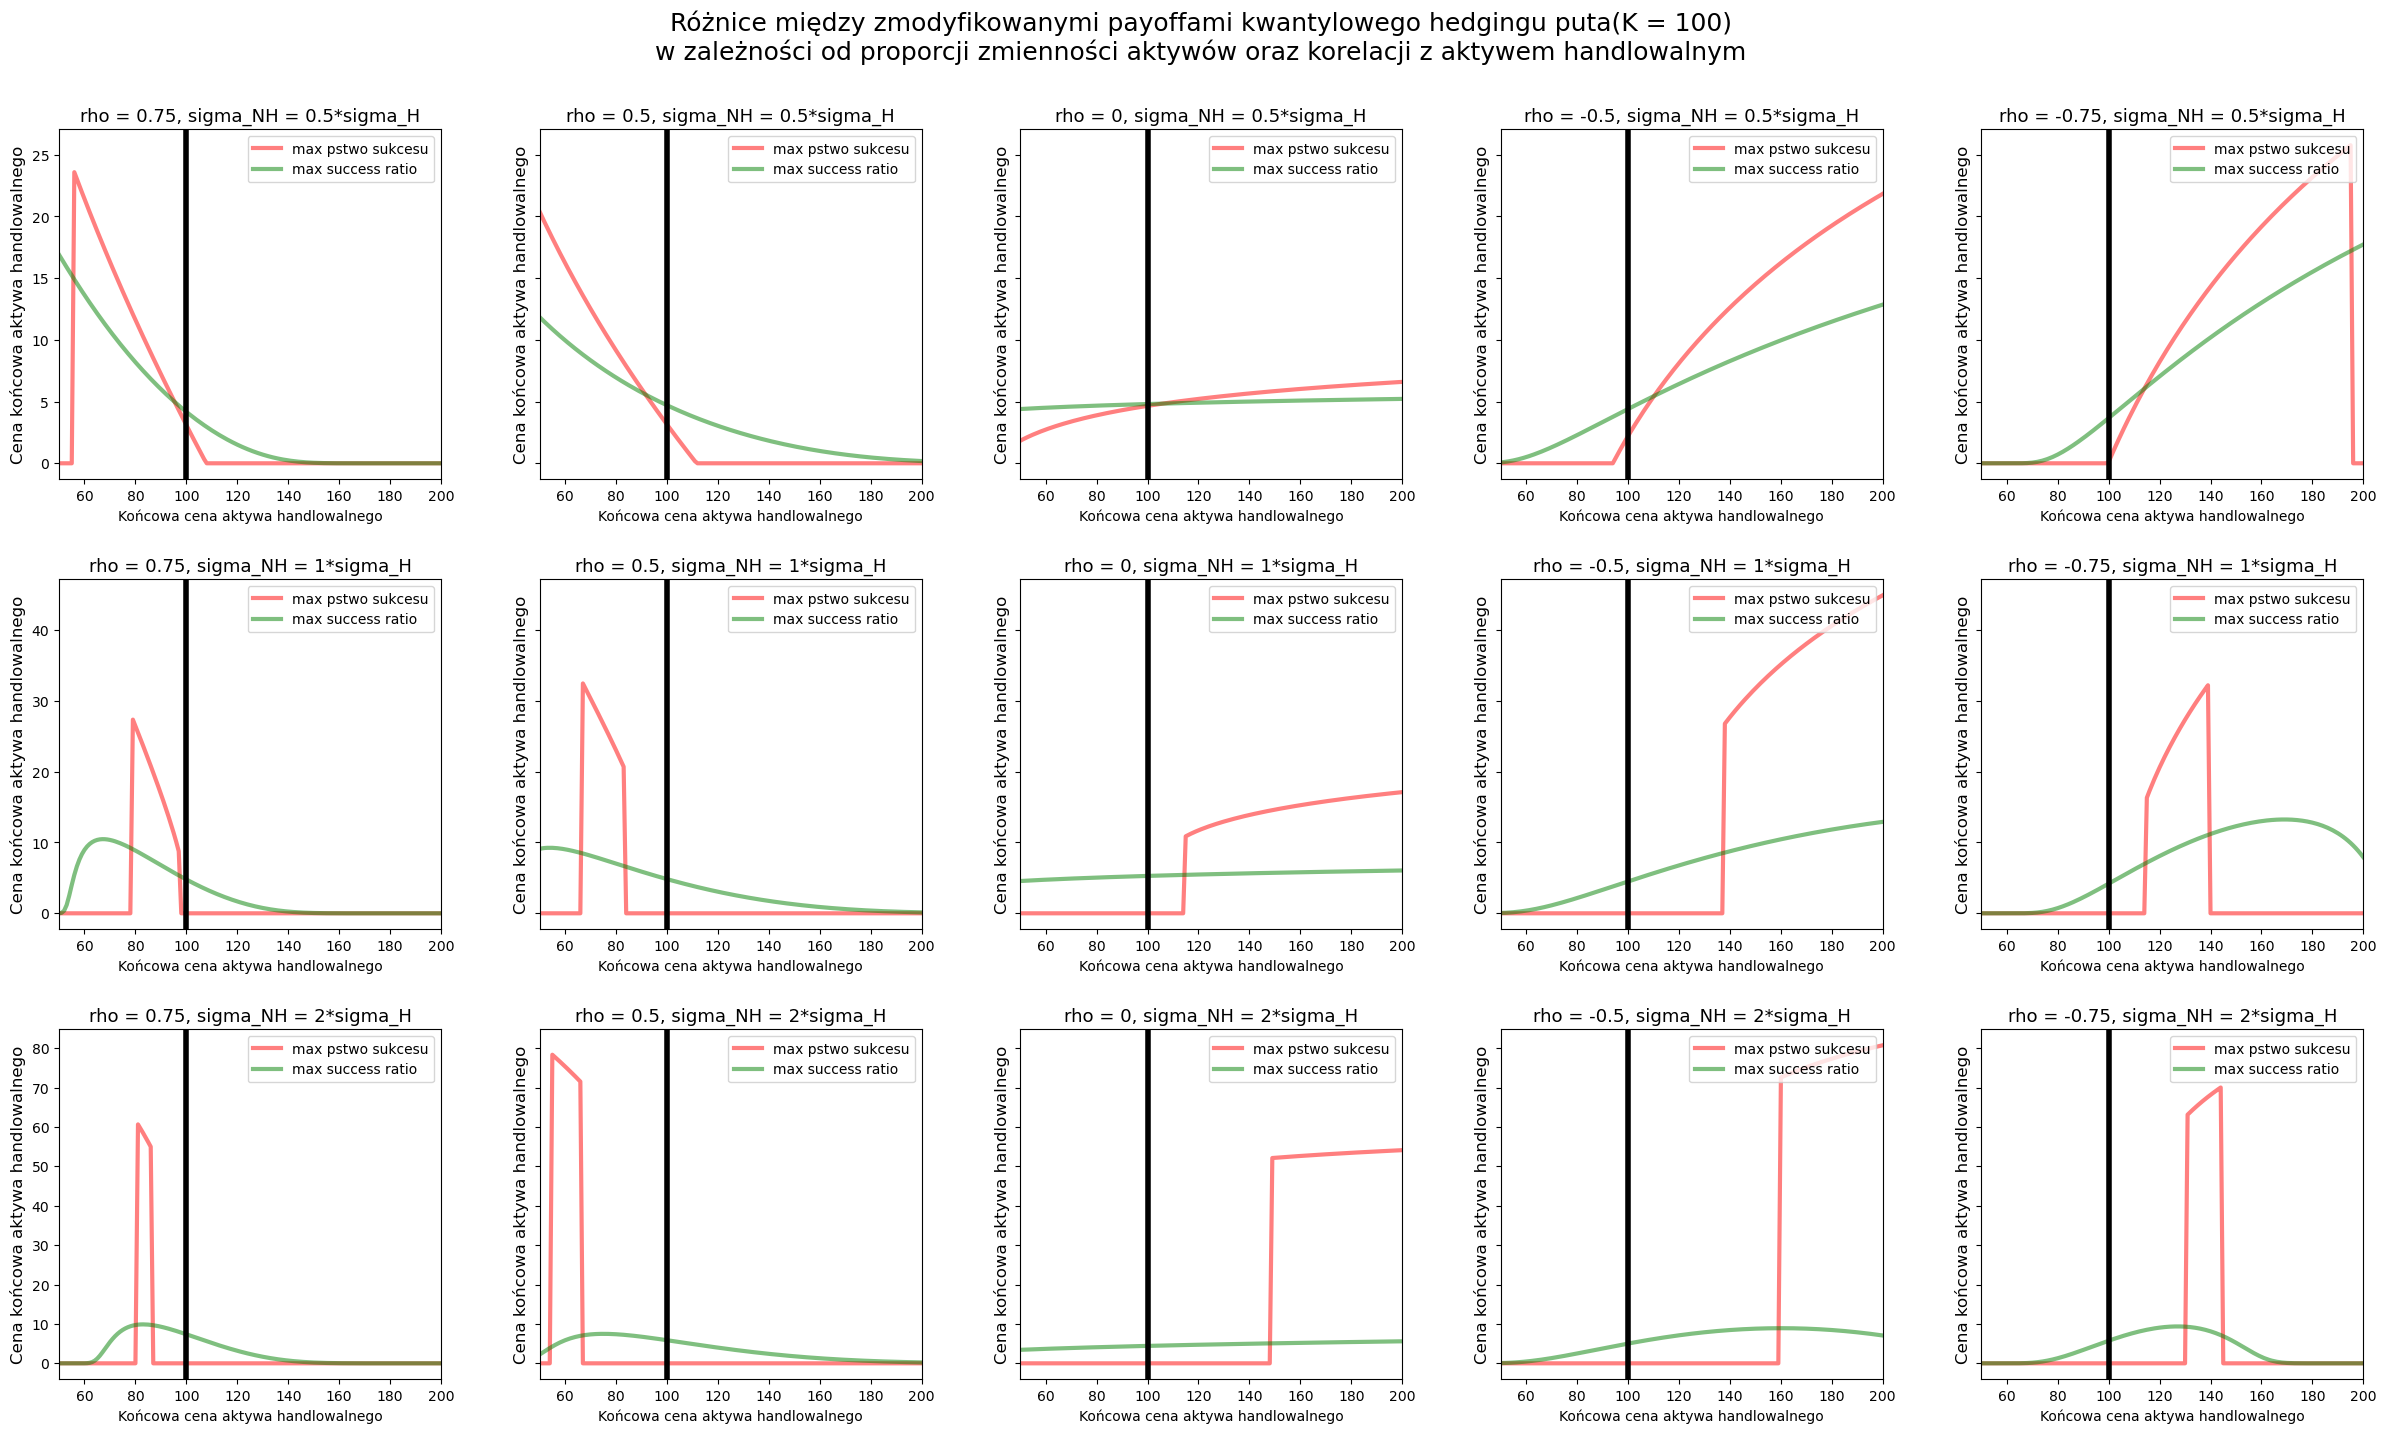

In [134]:
fig, axs = plt.subplots(3,5, figsize = (25, 15), sharey = 'row')
fig.tight_layout(pad=5.5)
K = 100
plt.suptitle(f'Różnice między zmodyfikowanymi payoffami kwantylowego hedgingu puta(K = {K})\nw zależności od proporcji zmienności aktywów oraz korelacji z aktywem handlowalnym', fontsize= 18)
plt.subplots_adjust(top=0.9)
V0 = BS_put / 2
for idy, rho in tqdm(enumerate([0.75, 0.5, 0, -0.5, -0.75])):
    for idx, prop in enumerate([1/2, 1, 2]):
        underlying_nt = NonTradedUnderlying(mu_nt, prop * sigma_t, underlying_t, rho)
        sims_t = pd.DataFrame(np.ones(152), columns = [0])
        sims_t[1] = np.arange(49, 201) / X0_t
        put_nt_sp = Vanilla_on_NonTraded(underlying_nt, K, T, False)
        put_nt_sp.set_m(V0, X0_t, X0_nt)
        payoff_sp = put_nt_sp.payoff_special((X0_t * sims_t), X0_nt)

        put_nt_sr = Vanilla_on_NonTraded(underlying_nt, K, T, False, 'success_ratio')
        put_nt_sr.set_m(V0, X0_t, X0_nt)
        payoff_sr = put_nt_sr.payoff_special((X0_t * sims_t), X0_nt)

        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sp, lw = 3, alpha = 0.5, color = 'red', label = 'max pstwo sukcesu')
        axs[idx, idy].plot((X0_t * sims_t).iloc[:,-1], payoff_sr, lw = 3, alpha = 0.5, color = 'green', label = 'max success ratio')
        axs[idx, idy].legend(loc = 'upper right')
        axs[idx, idy].set_title(f'rho = {rho}, sigma_NH = {prop}*sigma_H', fontsize = 13)
        axs[idx, idy].set_xlim([50, 200]) 
        axs[idx, idy].axvline(K, color = 'black', lw = 4)
        axs[idx, idy].set_xlabel('Końcowa cena aktywa handlowalnego')
        axs[idx, idy].set_ylabel('Payoff zmodyfikowany', fontsize = 12)    
        axs[idx, idy].set_ylabel('Cena końcowa aktywa handlowalnego', fontsize = 12)    

Wnioski dla opcji sprzedaży są zbliżone.